### ENSF 619.02 - Tutorial - group 9 - Jose Cazarin / Mohammed Adnan

This tutorial is based on the paper 
"Communication-Efficient Learning of Deep Networks from Decentralized Data"
which introduced the concept of Federated Learning in 2017 and on the code available at https://github.com/denoslab/fl-energy

This papers introduces a new decentralized approach to Machine Learning in which many separate devices learn a local model from their local data, thus those chunks of local data never leaves the device. The local models are sent to a global server which aggregates those models to create a global model.

This framework has introduced as a way of training the Google Keyboard preditive text feature across many Google (Android) smartphones that used the keyboard. The main driving force for the development of this framework was the possibility of training a global model without having to copy user data
from every smartphone due to privacy concerns

The federated learning experiment runs like this:

1. A fraction of devices are selected from a population of devices
2. Those devices receive the current "global model", which can be an uninitialized model
3. Those devices run a certain number of local epochs using their data and this global model
4. Each device will have its own local model which will be sent to the global server
5. The global server will aggregate all those local models by means of a simple weighted averaging
6. The updated global model will be distributed again to a new population of random devices (back to step 2)


The above loop will run for a certain number of global epochs, and then the training will be done and a final global model obtained.

The code in this notebook will demonstrate how this process works using convolutional neural networks and fully connected networks with the MNIST, FMNIST and CIFAR datasets.

In [1]:
# First, importing all the necessary Python modules
import os
import copy
import time
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

# This module is where the actual local learning of each device will happen
from update import LocalUpdate, test_inference

# This module is defining the CNN's and FC networks that will be used in the tutorial
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar

# Those are utility functions to get the data, average model weights, etc
from utils import get_dataset, average_weights, experiment_details


# To fix potential issues with matplot lib
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# This class contains all the parameter for the experiment
# which are explained below
class Args:
    
  # This sets the number of global epochs the experiment will run
  global_epochs = 50

  # This sets the size of the population (how many local devices may participate in the experiment) 
  num_users = 100

  # This is the fraction of devices that are selected to participate in the experiment
  # every global epoch    
  frac = 0.2

  # This sets how many local epochs each device will run before sending its local model
  # to the global server
  local_ep = 10
    
  # This sets the batch size each device will use in its local training epochs
  local_bs = 16

  # This is the learning rate used by the devices
  lr = 0.1

  # This is the optimizer used by the devices
  # It can be sgd or adam 
  optimizer = "sgd"  
    
  # This sets which model will be used
  # it can be "mlp" (fully connected) or "cnn" (convolution)
  model = "cnn"

  # This sets how many channels the input data has
  # All datasets in the experiment have 1 channel
  num_channels = 1
    
  # Selects the dataset that will be used
  # it can be: cifar, mnist or fmnist
  dataset = "cifar"
    
  # All the datasets in the experiment have 10 classes  
  num_classes = 10

  # This sets if the experiment will use non-IID data
  # non-IID data means that the data present on any given device
  # is based on the device particular usage, hence its local dataset
  # is not representative of the whole population distribution
  # Setting it to 1 to show that even in this non ideal scenario
  # model can still learn   
  iid = 1

  # Set this to one to make every device selected for training
  # have an unequal (random) amount of data
  # Keeping it to one for a more realistic scenario   
  unequal = 1
    
  # If we want verbose logs, set this one. If not, set to zero
  verbose = 1

  # Value to set the Pytorch seed, to ensure reproducibility between runs   
  seed = 1

  # If the experiment will use the GPU for training   
  gpu = None

In [4]:
start_time = time.time()

# Parses the experiments parameters
args = Args()
experiment_details(args)

# This variable is used by Pytorch to device if it is going to use GPU or not
if args.gpu is None:
    device = "cpu"
else:
    device = "cuda:0"

# Load select dataset and device population
# Device population is the population which the devices selected for training
# will be sampled from, each device will have its own local data
train_dataset, test_dataset, device_population = get_dataset(args)


Experimental details:
    Model     : cnn
    Optimizer : sgd
    Learning  : 0.1
    Global Rounds   : 50

    Federated parameters:
    IID
    Fraction of users  : 0.2
    Local Batch size   : 16
    Local Epochs       : 10

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Builds the selected model, slighty different models are used depending on the chosen dataset
if args.model == 'cnn':
    # Convolutional neural netork
    if args.dataset == 'mnist':
        global_model = CNNMnist(args=args)
    elif args.dataset == 'fmnist':
        global_model = CNNFashion_Mnist(args=args)
    elif args.dataset == 'cifar':
        global_model = CNNCifar(args=args)

elif args.model == 'mlp':
    # Multi-layer preceptron (fully connected network)
    img_size = train_dataset[0][0].shape
    len_in = 1
    for x in img_size:
        len_in *= x
        global_model = MLP(dim_in=len_in, dim_hidden=64,
                           dim_out=args.num_classes)

# Prints the model architecture on the screen
print(global_model)        

CNNCifar(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# Send the model to device (GPU or CPU).
global_model.to(device)

# Defining some helper variables for training
train_loss, train_accuracy = [], []

In [7]:
# Runs the experiment for the selected number of global epochs (rounds)
for epoch in range(args.global_epochs):
    
    print(f'Global Training Round : {epoch+1}\n')
    
    # Sample a fraction of the population
    # Each device will be represented by an integer number (ID) in the
    # "selected_devices" list     
    m = max(int(args.frac * args.num_users), 1)
    selected_devices = np.random.choice(range(args.num_users), m, replace=False)
    print("Devices selected in global round {}: {}".format(epoch+1,selected_devices))

    # Sets the model to train
    global_model.train()

     # Local weights and local losses are lists that keeps track of
    # each selected device model weights and training loss    
    local_weights, local_losses = [], []
    # For each selected device, runs the local training
    for device in selected_devices:
        
        # Creates an object of the class "LocalUpdate" which will represent
        # each device selected for training
        local_device = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=device_population[device], device_id=device)

        # This function will run the device local training and return the
        # obtained local model. Note that we are passing a full copy of the
        # global model to the device
        device_weights, device_loss = local_device.update_weights(
            model=copy.deepcopy(global_model), global_round=epoch)
        
        local_weights.append(copy.deepcopy(device_weights))
        local_losses.append(copy.deepcopy(device_loss))
        
    # This function will take all local models weights and do a simple averaging
    # of all those weights to obtain the new global model weights
    global_weights = average_weights(local_weights)

    # Load the obtained weights into the global model structure
    global_model.load_state_dict(global_weights)

    # Calculates the average loss of this global epoch by averaging all the local losses of every
    # selected device     
    loss_avg = sum(local_losses) / len(local_losses)
    
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every global epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for device in range(args.num_users):
        
        # Creates a class to represent each the local device in the whole population
        local_device = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=device_population[device], device_id=device)

        # Calculates the device accuracy and loss in its local data using the global model
        acc, loss = local_device.inference(model=global_model)

        list_acc.append(acc)
        list_loss.append(loss)

    train_accuracy.append(sum(list_acc)/len(list_acc))
    
    print(f'\nAvg Training Stats after {epoch+1} global epochs:')
    print('Global Training Loss: {:.3f}'.format(np.mean(np.array(train_loss))))
    print('Global Train Accuracy: {:.2f}%\n'.format(100*train_accuracy[-1]))

Global Training Round : 1

Devices selected in global round 1: [61 10 33 88 36  7 53 69 15 84 90 14 89 67 47 79 25 41  1 99]
| Global Round : 0 | Local Epoch : 0 on device 61 | Images on device 61 [000/400 (0%)] Loss: 2.295
| Global Round : 0 | Local Epoch : 0 on device 61 | Images on device 61 [160/400 (40%)] Loss: 2.305
| Global Round : 0 | Local Epoch : 0 on device 61 | Images on device 61 [320/400 (80%)] Loss: 2.301
| Global Round : 0 | Local Epoch : 1 on device 61 | Images on device 61 [000/400 (0%)] Loss: 2.296


E:\Mestrado\ENSF619.02\ENSF_619_02_Tutorial_Group_9\update.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


| Global Round : 0 | Local Epoch : 1 on device 61 | Images on device 61 [160/400 (40%)] Loss: 2.254
| Global Round : 0 | Local Epoch : 1 on device 61 | Images on device 61 [320/400 (80%)] Loss: 2.371
| Global Round : 0 | Local Epoch : 2 on device 61 | Images on device 61 [000/400 (0%)] Loss: 2.163
| Global Round : 0 | Local Epoch : 2 on device 61 | Images on device 61 [160/400 (40%)] Loss: 2.161
| Global Round : 0 | Local Epoch : 2 on device 61 | Images on device 61 [320/400 (80%)] Loss: 2.350
| Global Round : 0 | Local Epoch : 3 on device 61 | Images on device 61 [000/400 (0%)] Loss: 1.946
| Global Round : 0 | Local Epoch : 3 on device 61 | Images on device 61 [160/400 (40%)] Loss: 2.415
| Global Round : 0 | Local Epoch : 3 on device 61 | Images on device 61 [320/400 (80%)] Loss: 2.005
| Global Round : 0 | Local Epoch : 4 on device 61 | Images on device 61 [000/400 (0%)] Loss: 1.970
| Global Round : 0 | Local Epoch : 4 on device 61 | Images on device 61 [160/400 (40%)] Loss: 2.105
| G

| Global Round : 0 | Local Epoch : 9 on device 33 | Images on device 33 [000/400 (0%)] Loss: 1.836
| Global Round : 0 | Local Epoch : 9 on device 33 | Images on device 33 [160/400 (40%)] Loss: 1.666
| Global Round : 0 | Local Epoch : 9 on device 33 | Images on device 33 [320/400 (80%)] Loss: 1.535
| Global Round : 0 | Local Epoch : 0 on device 88 | Images on device 88 [000/400 (0%)] Loss: 2.325
| Global Round : 0 | Local Epoch : 0 on device 88 | Images on device 88 [160/400 (40%)] Loss: 2.281
| Global Round : 0 | Local Epoch : 0 on device 88 | Images on device 88 [320/400 (80%)] Loss: 2.292
| Global Round : 0 | Local Epoch : 1 on device 88 | Images on device 88 [000/400 (0%)] Loss: 2.284
| Global Round : 0 | Local Epoch : 1 on device 88 | Images on device 88 [160/400 (40%)] Loss: 2.207
| Global Round : 0 | Local Epoch : 1 on device 88 | Images on device 88 [320/400 (80%)] Loss: 2.272
| Global Round : 0 | Local Epoch : 2 on device 88 | Images on device 88 [000/400 (0%)] Loss: 2.128
| Gl

| Global Round : 0 | Local Epoch : 7 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.536
| Global Round : 0 | Local Epoch : 7 on device 7 | Images on device 7 [160/400 (40%)] Loss: 2.093
| Global Round : 0 | Local Epoch : 7 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.799
| Global Round : 0 | Local Epoch : 8 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.655
| Global Round : 0 | Local Epoch : 8 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.999
| Global Round : 0 | Local Epoch : 8 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.917
| Global Round : 0 | Local Epoch : 9 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.714
| Global Round : 0 | Local Epoch : 9 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.331
| Global Round : 0 | Local Epoch : 9 on device 7 | Images on device 7 [320/400 (80%)] Loss: 3.207
| Global Round : 0 | Local Epoch : 0 on device 53 | Images on device 53 [000/400 (0%)] Loss: 2.317
| Global Round : 0 | L

| Global Round : 0 | Local Epoch : 5 on device 15 | Images on device 15 [320/400 (80%)] Loss: 2.359
| Global Round : 0 | Local Epoch : 6 on device 15 | Images on device 15 [000/400 (0%)] Loss: 1.700
| Global Round : 0 | Local Epoch : 6 on device 15 | Images on device 15 [160/400 (40%)] Loss: 2.033
| Global Round : 0 | Local Epoch : 6 on device 15 | Images on device 15 [320/400 (80%)] Loss: 1.691
| Global Round : 0 | Local Epoch : 7 on device 15 | Images on device 15 [000/400 (0%)] Loss: 1.905
| Global Round : 0 | Local Epoch : 7 on device 15 | Images on device 15 [160/400 (40%)] Loss: 1.853
| Global Round : 0 | Local Epoch : 7 on device 15 | Images on device 15 [320/400 (80%)] Loss: 1.969
| Global Round : 0 | Local Epoch : 8 on device 15 | Images on device 15 [000/400 (0%)] Loss: 1.864
| Global Round : 0 | Local Epoch : 8 on device 15 | Images on device 15 [160/400 (40%)] Loss: 1.718
| Global Round : 0 | Local Epoch : 8 on device 15 | Images on device 15 [320/400 (80%)] Loss: 2.188
| G

| Global Round : 0 | Local Epoch : 4 on device 14 | Images on device 14 [000/400 (0%)] Loss: 1.966
| Global Round : 0 | Local Epoch : 4 on device 14 | Images on device 14 [160/400 (40%)] Loss: 1.983
| Global Round : 0 | Local Epoch : 4 on device 14 | Images on device 14 [320/400 (80%)] Loss: 1.919
| Global Round : 0 | Local Epoch : 5 on device 14 | Images on device 14 [000/400 (0%)] Loss: 1.937
| Global Round : 0 | Local Epoch : 5 on device 14 | Images on device 14 [160/400 (40%)] Loss: 1.861
| Global Round : 0 | Local Epoch : 5 on device 14 | Images on device 14 [320/400 (80%)] Loss: 2.100
| Global Round : 0 | Local Epoch : 6 on device 14 | Images on device 14 [000/400 (0%)] Loss: 1.844
| Global Round : 0 | Local Epoch : 6 on device 14 | Images on device 14 [160/400 (40%)] Loss: 1.436
| Global Round : 0 | Local Epoch : 6 on device 14 | Images on device 14 [320/400 (80%)] Loss: 1.966
| Global Round : 0 | Local Epoch : 7 on device 14 | Images on device 14 [000/400 (0%)] Loss: 1.804
| Gl

| Global Round : 0 | Local Epoch : 2 on device 47 | Images on device 47 [000/400 (0%)] Loss: 2.214
| Global Round : 0 | Local Epoch : 2 on device 47 | Images on device 47 [160/400 (40%)] Loss: 2.189
| Global Round : 0 | Local Epoch : 2 on device 47 | Images on device 47 [320/400 (80%)] Loss: 2.208
| Global Round : 0 | Local Epoch : 3 on device 47 | Images on device 47 [000/400 (0%)] Loss: 2.068
| Global Round : 0 | Local Epoch : 3 on device 47 | Images on device 47 [160/400 (40%)] Loss: 2.305
| Global Round : 0 | Local Epoch : 3 on device 47 | Images on device 47 [320/400 (80%)] Loss: 2.143
| Global Round : 0 | Local Epoch : 4 on device 47 | Images on device 47 [000/400 (0%)] Loss: 1.971
| Global Round : 0 | Local Epoch : 4 on device 47 | Images on device 47 [160/400 (40%)] Loss: 2.062
| Global Round : 0 | Local Epoch : 4 on device 47 | Images on device 47 [320/400 (80%)] Loss: 1.959
| Global Round : 0 | Local Epoch : 5 on device 47 | Images on device 47 [000/400 (0%)] Loss: 2.020
| Gl

| Global Round : 0 | Local Epoch : 0 on device 41 | Images on device 41 [320/400 (80%)] Loss: 2.288
| Global Round : 0 | Local Epoch : 1 on device 41 | Images on device 41 [000/400 (0%)] Loss: 2.263
| Global Round : 0 | Local Epoch : 1 on device 41 | Images on device 41 [160/400 (40%)] Loss: 2.334
| Global Round : 0 | Local Epoch : 1 on device 41 | Images on device 41 [320/400 (80%)] Loss: 2.348
| Global Round : 0 | Local Epoch : 2 on device 41 | Images on device 41 [000/400 (0%)] Loss: 2.212
| Global Round : 0 | Local Epoch : 2 on device 41 | Images on device 41 [160/400 (40%)] Loss: 2.253
| Global Round : 0 | Local Epoch : 2 on device 41 | Images on device 41 [320/400 (80%)] Loss: 2.412
| Global Round : 0 | Local Epoch : 3 on device 41 | Images on device 41 [000/400 (0%)] Loss: 1.976
| Global Round : 0 | Local Epoch : 3 on device 41 | Images on device 41 [160/400 (40%)] Loss: 2.187
| Global Round : 0 | Local Epoch : 3 on device 41 | Images on device 41 [320/400 (80%)] Loss: 1.968
| G

| Global Round : 0 | Local Epoch : 8 on device 99 | Images on device 99 [320/400 (80%)] Loss: 1.792
| Global Round : 0 | Local Epoch : 9 on device 99 | Images on device 99 [000/400 (0%)] Loss: 1.721
| Global Round : 0 | Local Epoch : 9 on device 99 | Images on device 99 [160/400 (40%)] Loss: 1.702
| Global Round : 0 | Local Epoch : 9 on device 99 | Images on device 99 [320/400 (80%)] Loss: 2.109

Avg Training Stats after 1 global epochs:
Global Training Loss: 2.040
Global Train Accuracy: 28.10%

Global Training Round : 2

Devices selected in global round 2: [37  7 23 80 42 68 48 20 91 52 43 56 32 83 35  0 47 18  2 26]
| Global Round : 1 | Local Epoch : 0 on device 37 | Images on device 37 [000/400 (0%)] Loss: 2.027
| Global Round : 1 | Local Epoch : 0 on device 37 | Images on device 37 [160/400 (40%)] Loss: 2.116
| Global Round : 1 | Local Epoch : 0 on device 37 | Images on device 37 [320/400 (80%)] Loss: 2.200
| Global Round : 1 | Local Epoch : 1 on device 37 | Images on device 37 [00

| Global Round : 1 | Local Epoch : 5 on device 23 | Images on device 23 [160/400 (40%)] Loss: 1.134
| Global Round : 1 | Local Epoch : 5 on device 23 | Images on device 23 [320/400 (80%)] Loss: 1.408
| Global Round : 1 | Local Epoch : 6 on device 23 | Images on device 23 [000/400 (0%)] Loss: 1.529
| Global Round : 1 | Local Epoch : 6 on device 23 | Images on device 23 [160/400 (40%)] Loss: 1.226
| Global Round : 1 | Local Epoch : 6 on device 23 | Images on device 23 [320/400 (80%)] Loss: 1.152
| Global Round : 1 | Local Epoch : 7 on device 23 | Images on device 23 [000/400 (0%)] Loss: 1.182
| Global Round : 1 | Local Epoch : 7 on device 23 | Images on device 23 [160/400 (40%)] Loss: 1.107
| Global Round : 1 | Local Epoch : 7 on device 23 | Images on device 23 [320/400 (80%)] Loss: 1.029
| Global Round : 1 | Local Epoch : 8 on device 23 | Images on device 23 [000/400 (0%)] Loss: 1.110
| Global Round : 1 | Local Epoch : 8 on device 23 | Images on device 23 [160/400 (40%)] Loss: 1.050
| G

| Global Round : 1 | Local Epoch : 4 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.159
| Global Round : 1 | Local Epoch : 4 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.486
| Global Round : 1 | Local Epoch : 4 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.842
| Global Round : 1 | Local Epoch : 5 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.423
| Global Round : 1 | Local Epoch : 5 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.997
| Global Round : 1 | Local Epoch : 5 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.818
| Global Round : 1 | Local Epoch : 6 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.742
| Global Round : 1 | Local Epoch : 6 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.419
| Global Round : 1 | Local Epoch : 6 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.291
| Global Round : 1 | Local Epoch : 7 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.009
| Gl

| Global Round : 1 | Local Epoch : 2 on device 91 | Images on device 91 [160/400 (40%)] Loss: 1.857
| Global Round : 1 | Local Epoch : 2 on device 91 | Images on device 91 [320/400 (80%)] Loss: 1.711
| Global Round : 1 | Local Epoch : 3 on device 91 | Images on device 91 [000/400 (0%)] Loss: 1.516
| Global Round : 1 | Local Epoch : 3 on device 91 | Images on device 91 [160/400 (40%)] Loss: 1.476
| Global Round : 1 | Local Epoch : 3 on device 91 | Images on device 91 [320/400 (80%)] Loss: 1.555
| Global Round : 1 | Local Epoch : 4 on device 91 | Images on device 91 [000/400 (0%)] Loss: 1.439
| Global Round : 1 | Local Epoch : 4 on device 91 | Images on device 91 [160/400 (40%)] Loss: 2.141
| Global Round : 1 | Local Epoch : 4 on device 91 | Images on device 91 [320/400 (80%)] Loss: 1.151
| Global Round : 1 | Local Epoch : 5 on device 91 | Images on device 91 [000/400 (0%)] Loss: 1.294
| Global Round : 1 | Local Epoch : 5 on device 91 | Images on device 91 [160/400 (40%)] Loss: 1.094
| G

| Global Round : 1 | Local Epoch : 0 on device 56 | Images on device 56 [000/400 (0%)] Loss: 2.058
| Global Round : 1 | Local Epoch : 0 on device 56 | Images on device 56 [160/400 (40%)] Loss: 1.934
| Global Round : 1 | Local Epoch : 0 on device 56 | Images on device 56 [320/400 (80%)] Loss: 1.814
| Global Round : 1 | Local Epoch : 1 on device 56 | Images on device 56 [000/400 (0%)] Loss: 2.062
| Global Round : 1 | Local Epoch : 1 on device 56 | Images on device 56 [160/400 (40%)] Loss: 1.795
| Global Round : 1 | Local Epoch : 1 on device 56 | Images on device 56 [320/400 (80%)] Loss: 2.204
| Global Round : 1 | Local Epoch : 2 on device 56 | Images on device 56 [000/400 (0%)] Loss: 1.788
| Global Round : 1 | Local Epoch : 2 on device 56 | Images on device 56 [160/400 (40%)] Loss: 1.621
| Global Round : 1 | Local Epoch : 2 on device 56 | Images on device 56 [320/400 (80%)] Loss: 1.461
| Global Round : 1 | Local Epoch : 3 on device 56 | Images on device 56 [000/400 (0%)] Loss: 1.445
| Gl

| Global Round : 1 | Local Epoch : 8 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.509
| Global Round : 1 | Local Epoch : 9 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.708
| Global Round : 1 | Local Epoch : 9 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.570
| Global Round : 1 | Local Epoch : 9 on device 83 | Images on device 83 [320/400 (80%)] Loss: 1.557
| Global Round : 1 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.945
| Global Round : 1 | Local Epoch : 0 on device 35 | Images on device 35 [160/400 (40%)] Loss: 2.025
| Global Round : 1 | Local Epoch : 0 on device 35 | Images on device 35 [320/400 (80%)] Loss: 2.103
| Global Round : 1 | Local Epoch : 1 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.959
| Global Round : 1 | Local Epoch : 1 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.739
| Global Round : 1 | Local Epoch : 1 on device 35 | Images on device 35 [320/400 (80%)] Loss: 2.125
| G

| Global Round : 1 | Local Epoch : 7 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.958
| Global Round : 1 | Local Epoch : 7 on device 47 | Images on device 47 [320/400 (80%)] Loss: 1.020
| Global Round : 1 | Local Epoch : 8 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.720
| Global Round : 1 | Local Epoch : 8 on device 47 | Images on device 47 [160/400 (40%)] Loss: 1.102
| Global Round : 1 | Local Epoch : 8 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.777
| Global Round : 1 | Local Epoch : 9 on device 47 | Images on device 47 [000/400 (0%)] Loss: 1.110
| Global Round : 1 | Local Epoch : 9 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.931
| Global Round : 1 | Local Epoch : 9 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.509
| Global Round : 1 | Local Epoch : 0 on device 18 | Images on device 18 [000/400 (0%)] Loss: 1.856
| Global Round : 1 | Local Epoch : 0 on device 18 | Images on device 18 [160/400 (40%)] Loss: 1.854
| G

| Global Round : 1 | Local Epoch : 5 on device 26 | Images on device 26 [000/400 (0%)] Loss: 1.532
| Global Round : 1 | Local Epoch : 5 on device 26 | Images on device 26 [160/400 (40%)] Loss: 1.155
| Global Round : 1 | Local Epoch : 5 on device 26 | Images on device 26 [320/400 (80%)] Loss: 1.114
| Global Round : 1 | Local Epoch : 6 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.860
| Global Round : 1 | Local Epoch : 6 on device 26 | Images on device 26 [160/400 (40%)] Loss: 1.243
| Global Round : 1 | Local Epoch : 6 on device 26 | Images on device 26 [320/400 (80%)] Loss: 1.897
| Global Round : 1 | Local Epoch : 7 on device 26 | Images on device 26 [000/400 (0%)] Loss: 1.376
| Global Round : 1 | Local Epoch : 7 on device 26 | Images on device 26 [160/400 (40%)] Loss: 1.179
| Global Round : 1 | Local Epoch : 7 on device 26 | Images on device 26 [320/400 (80%)] Loss: 1.635
| Global Round : 1 | Local Epoch : 8 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.825
| Gl

| Global Round : 2 | Local Epoch : 3 on device 0 | Images on device 0 [000/400 (0%)] Loss: 1.380
| Global Round : 2 | Local Epoch : 3 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.824
| Global Round : 2 | Local Epoch : 3 on device 0 | Images on device 0 [320/400 (80%)] Loss: 1.291
| Global Round : 2 | Local Epoch : 4 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.689
| Global Round : 2 | Local Epoch : 4 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.584
| Global Round : 2 | Local Epoch : 4 on device 0 | Images on device 0 [320/400 (80%)] Loss: 1.034
| Global Round : 2 | Local Epoch : 5 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.363
| Global Round : 2 | Local Epoch : 5 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.463
| Global Round : 2 | Local Epoch : 5 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.909
| Global Round : 2 | Local Epoch : 6 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.774
| Global Round : 2 | Loc

| Global Round : 2 | Local Epoch : 1 on device 22 | Images on device 22 [000/400 (0%)] Loss: 1.170
| Global Round : 2 | Local Epoch : 1 on device 22 | Images on device 22 [160/400 (40%)] Loss: 1.278
| Global Round : 2 | Local Epoch : 1 on device 22 | Images on device 22 [320/400 (80%)] Loss: 1.002
| Global Round : 2 | Local Epoch : 2 on device 22 | Images on device 22 [000/400 (0%)] Loss: 0.784
| Global Round : 2 | Local Epoch : 2 on device 22 | Images on device 22 [160/400 (40%)] Loss: 0.956
| Global Round : 2 | Local Epoch : 2 on device 22 | Images on device 22 [320/400 (80%)] Loss: 0.728
| Global Round : 2 | Local Epoch : 3 on device 22 | Images on device 22 [000/400 (0%)] Loss: 0.619
| Global Round : 2 | Local Epoch : 3 on device 22 | Images on device 22 [160/400 (40%)] Loss: 1.344
| Global Round : 2 | Local Epoch : 3 on device 22 | Images on device 22 [320/400 (80%)] Loss: 1.052
| Global Round : 2 | Local Epoch : 4 on device 22 | Images on device 22 [000/400 (0%)] Loss: 0.351
| Gl

| Global Round : 2 | Local Epoch : 9 on device 6 | Images on device 6 [320/400 (80%)] Loss: 1.016
| Global Round : 2 | Local Epoch : 0 on device 4 | Images on device 4 [000/400 (0%)] Loss: 1.799
| Global Round : 2 | Local Epoch : 0 on device 4 | Images on device 4 [160/400 (40%)] Loss: 2.071
| Global Round : 2 | Local Epoch : 0 on device 4 | Images on device 4 [320/400 (80%)] Loss: 2.168
| Global Round : 2 | Local Epoch : 1 on device 4 | Images on device 4 [000/400 (0%)] Loss: 1.786
| Global Round : 2 | Local Epoch : 1 on device 4 | Images on device 4 [160/400 (40%)] Loss: 1.573
| Global Round : 2 | Local Epoch : 1 on device 4 | Images on device 4 [320/400 (80%)] Loss: 1.604
| Global Round : 2 | Local Epoch : 2 on device 4 | Images on device 4 [000/400 (0%)] Loss: 1.246
| Global Round : 2 | Local Epoch : 2 on device 4 | Images on device 4 [160/400 (40%)] Loss: 1.023
| Global Round : 2 | Local Epoch : 2 on device 4 | Images on device 4 [320/400 (80%)] Loss: 1.581
| Global Round : 2 | Lo

| Global Round : 2 | Local Epoch : 7 on device 96 | Images on device 96 [160/400 (40%)] Loss: 1.548
| Global Round : 2 | Local Epoch : 7 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.631
| Global Round : 2 | Local Epoch : 8 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.076
| Global Round : 2 | Local Epoch : 8 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.215
| Global Round : 2 | Local Epoch : 8 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.301
| Global Round : 2 | Local Epoch : 9 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.208
| Global Round : 2 | Local Epoch : 9 on device 96 | Images on device 96 [160/400 (40%)] Loss: 2.282
| Global Round : 2 | Local Epoch : 9 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.407
| Global Round : 2 | Local Epoch : 0 on device 29 | Images on device 29 [000/400 (0%)] Loss: 1.330
| Global Round : 2 | Local Epoch : 0 on device 29 | Images on device 29 [160/400 (40%)] Loss: 1.463
| G

| Global Round : 2 | Local Epoch : 5 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.756
| Global Round : 2 | Local Epoch : 6 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.643
| Global Round : 2 | Local Epoch : 6 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.648
| Global Round : 2 | Local Epoch : 6 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.039
| Global Round : 2 | Local Epoch : 7 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.570
| Global Round : 2 | Local Epoch : 7 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.755
| Global Round : 2 | Local Epoch : 7 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.758
| Global Round : 2 | Local Epoch : 8 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.268
| Global Round : 2 | Local Epoch : 8 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.634
| Global Round : 2 | Local Epoch : 8 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.460
| G

| Global Round : 2 | Local Epoch : 4 on device 32 | Images on device 32 [160/400 (40%)] Loss: 0.721
| Global Round : 2 | Local Epoch : 4 on device 32 | Images on device 32 [320/400 (80%)] Loss: 0.732
| Global Round : 2 | Local Epoch : 5 on device 32 | Images on device 32 [000/400 (0%)] Loss: 0.838
| Global Round : 2 | Local Epoch : 5 on device 32 | Images on device 32 [160/400 (40%)] Loss: 0.659
| Global Round : 2 | Local Epoch : 5 on device 32 | Images on device 32 [320/400 (80%)] Loss: 0.487
| Global Round : 2 | Local Epoch : 6 on device 32 | Images on device 32 [000/400 (0%)] Loss: 0.371
| Global Round : 2 | Local Epoch : 6 on device 32 | Images on device 32 [160/400 (40%)] Loss: 1.115
| Global Round : 2 | Local Epoch : 6 on device 32 | Images on device 32 [320/400 (80%)] Loss: 0.944
| Global Round : 2 | Local Epoch : 7 on device 32 | Images on device 32 [000/400 (0%)] Loss: 0.520
| Global Round : 2 | Local Epoch : 7 on device 32 | Images on device 32 [160/400 (40%)] Loss: 0.180
| G

| Global Round : 2 | Local Epoch : 2 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.061
| Global Round : 2 | Local Epoch : 2 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.124
| Global Round : 2 | Local Epoch : 3 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.547
| Global Round : 2 | Local Epoch : 3 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.011
| Global Round : 2 | Local Epoch : 3 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.455
| Global Round : 2 | Local Epoch : 4 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.637
| Global Round : 2 | Local Epoch : 4 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.252
| Global Round : 2 | Local Epoch : 4 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.566
| Global Round : 2 | Local Epoch : 5 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.220
| Global Round : 2 | Local Epoch : 5 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.710
| G

| Global Round : 3 | Local Epoch : 9 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.071
| Global Round : 3 | Local Epoch : 9 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.239
| Global Round : 3 | Local Epoch : 0 on device 62 | Images on device 62 [000/400 (0%)] Loss: 2.009
| Global Round : 3 | Local Epoch : 0 on device 62 | Images on device 62 [160/400 (40%)] Loss: 1.976
| Global Round : 3 | Local Epoch : 0 on device 62 | Images on device 62 [320/400 (80%)] Loss: 1.420
| Global Round : 3 | Local Epoch : 1 on device 62 | Images on device 62 [000/400 (0%)] Loss: 1.493
| Global Round : 3 | Local Epoch : 1 on device 62 | Images on device 62 [160/400 (40%)] Loss: 1.274
| Global Round : 3 | Local Epoch : 1 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.895
| Global Round : 3 | Local Epoch : 2 on device 62 | Images on device 62 [000/400 (0%)] Loss: 1.034
| Global Round : 3 | Local Epoch : 2 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.731
| G

| Global Round : 3 | Local Epoch : 7 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.225
| Global Round : 3 | Local Epoch : 8 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.087
| Global Round : 3 | Local Epoch : 8 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.534
| Global Round : 3 | Local Epoch : 8 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.185
| Global Round : 3 | Local Epoch : 9 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.018
| Global Round : 3 | Local Epoch : 9 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.026
| Global Round : 3 | Local Epoch : 9 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.212
| Global Round : 3 | Local Epoch : 0 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.584
| Global Round : 3 | Local Epoch : 0 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.833
| Global Round : 3 | Local Epoch : 0 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.273
| G

| Global Round : 3 | Local Epoch : 5 on device 3 | Images on device 3 [160/400 (40%)] Loss: 1.495
| Global Round : 3 | Local Epoch : 5 on device 3 | Images on device 3 [320/400 (80%)] Loss: 1.302
| Global Round : 3 | Local Epoch : 6 on device 3 | Images on device 3 [000/400 (0%)] Loss: 1.025
| Global Round : 3 | Local Epoch : 6 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.623
| Global Round : 3 | Local Epoch : 6 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.683
| Global Round : 3 | Local Epoch : 7 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.399
| Global Round : 3 | Local Epoch : 7 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.215
| Global Round : 3 | Local Epoch : 7 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.323
| Global Round : 3 | Local Epoch : 8 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.481
| Global Round : 3 | Local Epoch : 8 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.699
| Global Round : 3 | Lo

| Global Round : 3 | Local Epoch : 2 on device 44 | Images on device 44 [320/400 (80%)] Loss: 1.292
| Global Round : 3 | Local Epoch : 3 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.487
| Global Round : 3 | Local Epoch : 3 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.353
| Global Round : 3 | Local Epoch : 3 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.460
| Global Round : 3 | Local Epoch : 4 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.727
| Global Round : 3 | Local Epoch : 4 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.381
| Global Round : 3 | Local Epoch : 4 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.795
| Global Round : 3 | Local Epoch : 5 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.482
| Global Round : 3 | Local Epoch : 5 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.320
| Global Round : 3 | Local Epoch : 5 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.460
| G

| Global Round : 3 | Local Epoch : 0 on device 70 | Images on device 70 [320/400 (80%)] Loss: 1.672
| Global Round : 3 | Local Epoch : 1 on device 70 | Images on device 70 [000/400 (0%)] Loss: 1.647
| Global Round : 3 | Local Epoch : 1 on device 70 | Images on device 70 [160/400 (40%)] Loss: 1.458
| Global Round : 3 | Local Epoch : 1 on device 70 | Images on device 70 [320/400 (80%)] Loss: 1.441
| Global Round : 3 | Local Epoch : 2 on device 70 | Images on device 70 [000/400 (0%)] Loss: 1.080
| Global Round : 3 | Local Epoch : 2 on device 70 | Images on device 70 [160/400 (40%)] Loss: 1.039
| Global Round : 3 | Local Epoch : 2 on device 70 | Images on device 70 [320/400 (80%)] Loss: 1.361
| Global Round : 3 | Local Epoch : 3 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.832
| Global Round : 3 | Local Epoch : 3 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.582
| Global Round : 3 | Local Epoch : 3 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.559
| G

| Global Round : 3 | Local Epoch : 9 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.353
| Global Round : 3 | Local Epoch : 9 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.846
| Global Round : 3 | Local Epoch : 0 on device 40 | Images on device 40 [000/400 (0%)] Loss: 2.466
| Global Round : 3 | Local Epoch : 0 on device 40 | Images on device 40 [160/400 (40%)] Loss: 1.716
| Global Round : 3 | Local Epoch : 0 on device 40 | Images on device 40 [320/400 (80%)] Loss: 1.708
| Global Round : 3 | Local Epoch : 1 on device 40 | Images on device 40 [000/400 (0%)] Loss: 1.094
| Global Round : 3 | Local Epoch : 1 on device 40 | Images on device 40 [160/400 (40%)] Loss: 1.273
| Global Round : 3 | Local Epoch : 1 on device 40 | Images on device 40 [320/400 (80%)] Loss: 1.767
| Global Round : 3 | Local Epoch : 2 on device 40 | Images on device 40 [000/400 (0%)] Loss: 1.092
| Global Round : 3 | Local Epoch : 2 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.642
| G

| Global Round : 3 | Local Epoch : 7 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.423
| Global Round : 3 | Local Epoch : 7 on device 54 | Images on device 54 [160/400 (40%)] Loss: 1.845
| Global Round : 3 | Local Epoch : 7 on device 54 | Images on device 54 [320/400 (80%)] Loss: 1.093
| Global Round : 3 | Local Epoch : 8 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.874
| Global Round : 3 | Local Epoch : 8 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.151
| Global Round : 3 | Local Epoch : 8 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.092
| Global Round : 3 | Local Epoch : 9 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.115
| Global Round : 3 | Local Epoch : 9 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.028
| Global Round : 3 | Local Epoch : 9 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.244
| Global Round : 3 | Local Epoch : 0 on device 76 | Images on device 76 [000/400 (0%)] Loss: 1.938
| Gl

| Global Round : 4 | Local Epoch : 3 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.371
| Global Round : 4 | Local Epoch : 4 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.485
| Global Round : 4 | Local Epoch : 4 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.195
| Global Round : 4 | Local Epoch : 4 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.674
| Global Round : 4 | Local Epoch : 5 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.265
| Global Round : 4 | Local Epoch : 5 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.284
| Global Round : 4 | Local Epoch : 5 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.128
| Global Round : 4 | Local Epoch : 6 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.186
| Global Round : 4 | Local Epoch : 6 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.085
| Global Round : 4 | Local Epoch : 6 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.091
| G

| Global Round : 4 | Local Epoch : 1 on device 81 | Images on device 81 [320/400 (80%)] Loss: 1.202
| Global Round : 4 | Local Epoch : 2 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.457
| Global Round : 4 | Local Epoch : 2 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.293
| Global Round : 4 | Local Epoch : 2 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.754
| Global Round : 4 | Local Epoch : 3 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.228
| Global Round : 4 | Local Epoch : 3 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.139
| Global Round : 4 | Local Epoch : 3 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.440
| Global Round : 4 | Local Epoch : 4 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.608
| Global Round : 4 | Local Epoch : 4 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.638
| Global Round : 4 | Local Epoch : 4 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.529
| G

| Global Round : 4 | Local Epoch : 0 on device 13 | Images on device 13 [000/400 (0%)] Loss: 1.844
| Global Round : 4 | Local Epoch : 0 on device 13 | Images on device 13 [160/400 (40%)] Loss: 1.734
| Global Round : 4 | Local Epoch : 0 on device 13 | Images on device 13 [320/400 (80%)] Loss: 1.564
| Global Round : 4 | Local Epoch : 1 on device 13 | Images on device 13 [000/400 (0%)] Loss: 1.110
| Global Round : 4 | Local Epoch : 1 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.907
| Global Round : 4 | Local Epoch : 1 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.970
| Global Round : 4 | Local Epoch : 2 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.777
| Global Round : 4 | Local Epoch : 2 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.861
| Global Round : 4 | Local Epoch : 2 on device 13 | Images on device 13 [320/400 (80%)] Loss: 1.022
| Global Round : 4 | Local Epoch : 3 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.595
| Gl

| Global Round : 4 | Local Epoch : 8 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.713
| Global Round : 4 | Local Epoch : 8 on device 48 | Images on device 48 [320/400 (80%)] Loss: 1.645
| Global Round : 4 | Local Epoch : 9 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.561
| Global Round : 4 | Local Epoch : 9 on device 48 | Images on device 48 [160/400 (40%)] Loss: 1.070
| Global Round : 4 | Local Epoch : 9 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.357
| Global Round : 4 | Local Epoch : 0 on device 90 | Images on device 90 [000/400 (0%)] Loss: 1.618
| Global Round : 4 | Local Epoch : 0 on device 90 | Images on device 90 [160/400 (40%)] Loss: 2.005
| Global Round : 4 | Local Epoch : 0 on device 90 | Images on device 90 [320/400 (80%)] Loss: 2.264
| Global Round : 4 | Local Epoch : 1 on device 90 | Images on device 90 [000/400 (0%)] Loss: 1.222
| Global Round : 4 | Local Epoch : 1 on device 90 | Images on device 90 [160/400 (40%)] Loss: 1.099
| G

| Global Round : 4 | Local Epoch : 6 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.711
| Global Round : 4 | Local Epoch : 6 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.783
| Global Round : 4 | Local Epoch : 6 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.389
| Global Round : 4 | Local Epoch : 7 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.761
| Global Round : 4 | Local Epoch : 7 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.227
| Global Round : 4 | Local Epoch : 7 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.988
| Global Round : 4 | Local Epoch : 8 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.264
| Global Round : 4 | Local Epoch : 8 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.017
| Global Round : 4 | Local Epoch : 8 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.204
| Global Round : 4 | Local Epoch : 9 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.010
| Gl

| Global Round : 4 | Local Epoch : 4 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.314
| Global Round : 4 | Local Epoch : 5 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.340
| Global Round : 4 | Local Epoch : 5 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.128
| Global Round : 4 | Local Epoch : 5 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.335
| Global Round : 4 | Local Epoch : 6 on device 2 | Images on device 2 [000/400 (0%)] Loss: 2.922
| Global Round : 4 | Local Epoch : 6 on device 2 | Images on device 2 [160/400 (40%)] Loss: 1.881
| Global Round : 4 | Local Epoch : 6 on device 2 | Images on device 2 [320/400 (80%)] Loss: 1.107
| Global Round : 4 | Local Epoch : 7 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.833
| Global Round : 4 | Local Epoch : 7 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.490
| Global Round : 4 | Local Epoch : 7 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.295
| Global Round : 4 | Lo

| Global Round : 4 | Local Epoch : 2 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.539
| Global Round : 4 | Local Epoch : 3 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.915
| Global Round : 4 | Local Epoch : 3 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.409
| Global Round : 4 | Local Epoch : 3 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.297
| Global Round : 4 | Local Epoch : 4 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.184
| Global Round : 4 | Local Epoch : 4 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.389
| Global Round : 4 | Local Epoch : 4 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.180
| Global Round : 4 | Local Epoch : 5 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.054
| Global Round : 4 | Local Epoch : 5 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.327
| Global Round : 4 | Local Epoch : 5 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.675
| G

| Global Round : 5 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.682
| Global Round : 5 | Local Epoch : 0 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.579
| Global Round : 5 | Local Epoch : 0 on device 35 | Images on device 35 [320/400 (80%)] Loss: 2.030
| Global Round : 5 | Local Epoch : 1 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.591
| Global Round : 5 | Local Epoch : 1 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.272
| Global Round : 5 | Local Epoch : 1 on device 35 | Images on device 35 [320/400 (80%)] Loss: 1.056
| Global Round : 5 | Local Epoch : 2 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.688
| Global Round : 5 | Local Epoch : 2 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.558
| Global Round : 5 | Local Epoch : 2 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.625
| Global Round : 5 | Local Epoch : 3 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.204
| Gl

| Global Round : 5 | Local Epoch : 8 on device 11 | Images on device 11 [160/400 (40%)] Loss: 0.553
| Global Round : 5 | Local Epoch : 8 on device 11 | Images on device 11 [320/400 (80%)] Loss: 0.893
| Global Round : 5 | Local Epoch : 9 on device 11 | Images on device 11 [000/400 (0%)] Loss: 0.464
| Global Round : 5 | Local Epoch : 9 on device 11 | Images on device 11 [160/400 (40%)] Loss: 0.094
| Global Round : 5 | Local Epoch : 9 on device 11 | Images on device 11 [320/400 (80%)] Loss: 0.697
| Global Round : 5 | Local Epoch : 0 on device 38 | Images on device 38 [000/400 (0%)] Loss: 1.530
| Global Round : 5 | Local Epoch : 0 on device 38 | Images on device 38 [160/400 (40%)] Loss: 1.895
| Global Round : 5 | Local Epoch : 0 on device 38 | Images on device 38 [320/400 (80%)] Loss: 1.849
| Global Round : 5 | Local Epoch : 1 on device 38 | Images on device 38 [000/400 (0%)] Loss: 1.531
| Global Round : 5 | Local Epoch : 1 on device 38 | Images on device 38 [160/400 (40%)] Loss: 1.161
| G

| Global Round : 5 | Local Epoch : 6 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.576
| Global Round : 5 | Local Epoch : 6 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.100
| Global Round : 5 | Local Epoch : 6 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.036
| Global Round : 5 | Local Epoch : 7 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.030
| Global Round : 5 | Local Epoch : 7 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.022
| Global Round : 5 | Local Epoch : 7 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.095
| Global Round : 5 | Local Epoch : 8 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.045
| Global Round : 5 | Local Epoch : 8 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.221
| Global Round : 5 | Local Epoch : 8 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.766
| Global Round : 5 | Local Epoch : 9 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.177
| Gl

| Global Round : 5 | Local Epoch : 4 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.602
| Global Round : 5 | Local Epoch : 4 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.749
| Global Round : 5 | Local Epoch : 5 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.540
| Global Round : 5 | Local Epoch : 5 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.211
| Global Round : 5 | Local Epoch : 5 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.270
| Global Round : 5 | Local Epoch : 6 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.037
| Global Round : 5 | Local Epoch : 6 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.232
| Global Round : 5 | Local Epoch : 6 on device 49 | Images on device 49 [320/400 (80%)] Loss: 1.873
| Global Round : 5 | Local Epoch : 7 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.490
| Global Round : 5 | Local Epoch : 7 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.056
| G

| Global Round : 5 | Local Epoch : 2 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.433
| Global Round : 5 | Local Epoch : 2 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.533
| Global Round : 5 | Local Epoch : 3 on device 69 | Images on device 69 [000/400 (0%)] Loss: 0.237
| Global Round : 5 | Local Epoch : 3 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.550
| Global Round : 5 | Local Epoch : 3 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.634
| Global Round : 5 | Local Epoch : 4 on device 69 | Images on device 69 [000/400 (0%)] Loss: 2.032
| Global Round : 5 | Local Epoch : 4 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.680
| Global Round : 5 | Local Epoch : 4 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.388
| Global Round : 5 | Local Epoch : 5 on device 69 | Images on device 69 [000/400 (0%)] Loss: 0.233
| Global Round : 5 | Local Epoch : 5 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.422
| G

| Global Round : 5 | Local Epoch : 1 on device 87 | Images on device 87 [000/400 (0%)] Loss: 1.456
| Global Round : 5 | Local Epoch : 1 on device 87 | Images on device 87 [160/400 (40%)] Loss: 1.105
| Global Round : 5 | Local Epoch : 1 on device 87 | Images on device 87 [320/400 (80%)] Loss: 1.726
| Global Round : 5 | Local Epoch : 2 on device 87 | Images on device 87 [000/400 (0%)] Loss: 0.772
| Global Round : 5 | Local Epoch : 2 on device 87 | Images on device 87 [160/400 (40%)] Loss: 0.533
| Global Round : 5 | Local Epoch : 2 on device 87 | Images on device 87 [320/400 (80%)] Loss: 0.648
| Global Round : 5 | Local Epoch : 3 on device 87 | Images on device 87 [000/400 (0%)] Loss: 0.255
| Global Round : 5 | Local Epoch : 3 on device 87 | Images on device 87 [160/400 (40%)] Loss: 0.402
| Global Round : 5 | Local Epoch : 3 on device 87 | Images on device 87 [320/400 (80%)] Loss: 0.242
| Global Round : 5 | Local Epoch : 4 on device 87 | Images on device 87 [000/400 (0%)] Loss: 0.268
| Gl

| Global Round : 5 | Local Epoch : 9 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.002
| Global Round : 5 | Local Epoch : 9 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.004
| Global Round : 5 | Local Epoch : 9 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.011
| Global Round : 5 | Local Epoch : 0 on device 17 | Images on device 17 [000/400 (0%)] Loss: 1.659
| Global Round : 5 | Local Epoch : 0 on device 17 | Images on device 17 [160/400 (40%)] Loss: 1.826
| Global Round : 5 | Local Epoch : 0 on device 17 | Images on device 17 [320/400 (80%)] Loss: 2.166
| Global Round : 5 | Local Epoch : 1 on device 17 | Images on device 17 [000/400 (0%)] Loss: 1.228
| Global Round : 5 | Local Epoch : 1 on device 17 | Images on device 17 [160/400 (40%)] Loss: 1.107
| Global Round : 5 | Local Epoch : 1 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.886
| Global Round : 5 | Local Epoch : 2 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.991
| Gl

| Global Round : 6 | Local Epoch : 6 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.121
| Global Round : 6 | Local Epoch : 7 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.022
| Global Round : 6 | Local Epoch : 7 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.159
| Global Round : 6 | Local Epoch : 7 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.417
| Global Round : 6 | Local Epoch : 8 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.089
| Global Round : 6 | Local Epoch : 8 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.381
| Global Round : 6 | Local Epoch : 8 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.199
| Global Round : 6 | Local Epoch : 9 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.316
| Global Round : 6 | Local Epoch : 9 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.929
| Global Round : 6 | Local Epoch : 9 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.103
| G

| Global Round : 6 | Local Epoch : 4 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.450
| Global Round : 6 | Local Epoch : 4 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.400
| Global Round : 6 | Local Epoch : 5 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.875
| Global Round : 6 | Local Epoch : 5 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.499
| Global Round : 6 | Local Epoch : 5 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.389
| Global Round : 6 | Local Epoch : 6 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.027
| Global Round : 6 | Local Epoch : 6 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.097
| Global Round : 6 | Local Epoch : 6 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.895
| Global Round : 6 | Local Epoch : 7 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.325
| Global Round : 6 | Local Epoch : 7 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.770
| G

| Global Round : 6 | Local Epoch : 3 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.347
| Global Round : 6 | Local Epoch : 3 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.305
| Global Round : 6 | Local Epoch : 3 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.622
| Global Round : 6 | Local Epoch : 4 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.561
| Global Round : 6 | Local Epoch : 4 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.180
| Global Round : 6 | Local Epoch : 4 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.127
| Global Round : 6 | Local Epoch : 5 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.091
| Global Round : 6 | Local Epoch : 5 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.338
| Global Round : 6 | Local Epoch : 5 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.358
| Global Round : 6 | Local Epoch : 6 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.273
| Gl

| Global Round : 6 | Local Epoch : 0 on device 44 | Images on device 44 [320/400 (80%)] Loss: 1.357
| Global Round : 6 | Local Epoch : 1 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.980
| Global Round : 6 | Local Epoch : 1 on device 44 | Images on device 44 [160/400 (40%)] Loss: 1.132
| Global Round : 6 | Local Epoch : 1 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.871
| Global Round : 6 | Local Epoch : 2 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.249
| Global Round : 6 | Local Epoch : 2 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.592
| Global Round : 6 | Local Epoch : 2 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.502
| Global Round : 6 | Local Epoch : 3 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.442
| Global Round : 6 | Local Epoch : 3 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.509
| Global Round : 6 | Local Epoch : 3 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.212
| G

| Global Round : 6 | Local Epoch : 9 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.355
| Global Round : 6 | Local Epoch : 9 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.146
| Global Round : 6 | Local Epoch : 9 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.736
| Global Round : 6 | Local Epoch : 0 on device 88 | Images on device 88 [000/400 (0%)] Loss: 1.899
| Global Round : 6 | Local Epoch : 0 on device 88 | Images on device 88 [160/400 (40%)] Loss: 1.616
| Global Round : 6 | Local Epoch : 0 on device 88 | Images on device 88 [320/400 (80%)] Loss: 2.264
| Global Round : 6 | Local Epoch : 1 on device 88 | Images on device 88 [000/400 (0%)] Loss: 1.154
| Global Round : 6 | Local Epoch : 1 on device 88 | Images on device 88 [160/400 (40%)] Loss: 1.571
| Global Round : 6 | Local Epoch : 1 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.660
| Global Round : 6 | Local Epoch : 2 on device 88 | Images on device 88 [000/400 (0%)] Loss: 1.070
| Gl

| Global Round : 6 | Local Epoch : 7 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.543
| Global Round : 6 | Local Epoch : 7 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.898
| Global Round : 6 | Local Epoch : 8 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.074
| Global Round : 6 | Local Epoch : 8 on device 94 | Images on device 94 [160/400 (40%)] Loss: 1.724
| Global Round : 6 | Local Epoch : 8 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.993
| Global Round : 6 | Local Epoch : 9 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.993
| Global Round : 6 | Local Epoch : 9 on device 94 | Images on device 94 [160/400 (40%)] Loss: 1.432
| Global Round : 6 | Local Epoch : 9 on device 94 | Images on device 94 [320/400 (80%)] Loss: 1.082
| Global Round : 6 | Local Epoch : 0 on device 76 | Images on device 76 [000/400 (0%)] Loss: 1.622
| Global Round : 6 | Local Epoch : 0 on device 76 | Images on device 76 [160/400 (40%)] Loss: 2.250
| G

| Global Round : 6 | Local Epoch : 5 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.624
| Global Round : 6 | Local Epoch : 6 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.469
| Global Round : 6 | Local Epoch : 6 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.289
| Global Round : 6 | Local Epoch : 6 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.340
| Global Round : 6 | Local Epoch : 7 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.349
| Global Round : 6 | Local Epoch : 7 on device 40 | Images on device 40 [160/400 (40%)] Loss: 1.277
| Global Round : 6 | Local Epoch : 7 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.807
| Global Round : 6 | Local Epoch : 8 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.522
| Global Round : 6 | Local Epoch : 8 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.169
| Global Round : 6 | Local Epoch : 8 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.427
| G

| Global Round : 7 | Local Epoch : 2 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.609
| Global Round : 7 | Local Epoch : 2 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.625
| Global Round : 7 | Local Epoch : 3 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.531
| Global Round : 7 | Local Epoch : 3 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.529
| Global Round : 7 | Local Epoch : 3 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.529
| Global Round : 7 | Local Epoch : 4 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.217
| Global Round : 7 | Local Epoch : 4 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.109
| Global Round : 7 | Local Epoch : 4 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.121
| Global Round : 7 | Local Epoch : 5 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.053
| Global Round : 7 | Local Epoch : 5 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.029
| G

| Global Round : 7 | Local Epoch : 0 on device 20 | Images on device 20 [160/400 (40%)] Loss: 2.038
| Global Round : 7 | Local Epoch : 0 on device 20 | Images on device 20 [320/400 (80%)] Loss: 2.077
| Global Round : 7 | Local Epoch : 1 on device 20 | Images on device 20 [000/400 (0%)] Loss: 1.401
| Global Round : 7 | Local Epoch : 1 on device 20 | Images on device 20 [160/400 (40%)] Loss: 1.293
| Global Round : 7 | Local Epoch : 1 on device 20 | Images on device 20 [320/400 (80%)] Loss: 1.224
| Global Round : 7 | Local Epoch : 2 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.307
| Global Round : 7 | Local Epoch : 2 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.727
| Global Round : 7 | Local Epoch : 2 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.773
| Global Round : 7 | Local Epoch : 3 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.535
| Global Round : 7 | Local Epoch : 3 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.504
| G

| Global Round : 7 | Local Epoch : 9 on device 24 | Images on device 24 [000/400 (0%)] Loss: 0.485
| Global Round : 7 | Local Epoch : 9 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.642
| Global Round : 7 | Local Epoch : 9 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.195
| Global Round : 7 | Local Epoch : 0 on device 50 | Images on device 50 [000/400 (0%)] Loss: 1.910
| Global Round : 7 | Local Epoch : 0 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.969
| Global Round : 7 | Local Epoch : 0 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.659
| Global Round : 7 | Local Epoch : 1 on device 50 | Images on device 50 [000/400 (0%)] Loss: 1.322
| Global Round : 7 | Local Epoch : 1 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.026
| Global Round : 7 | Local Epoch : 1 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.922
| Global Round : 7 | Local Epoch : 2 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.730
| Gl

| Global Round : 7 | Local Epoch : 6 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.206
| Global Round : 7 | Local Epoch : 7 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.231
| Global Round : 7 | Local Epoch : 7 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.254
| Global Round : 7 | Local Epoch : 7 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.500
| Global Round : 7 | Local Epoch : 8 on device 92 | Images on device 92 [000/400 (0%)] Loss: 1.253
| Global Round : 7 | Local Epoch : 8 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.702
| Global Round : 7 | Local Epoch : 8 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.791
| Global Round : 7 | Local Epoch : 9 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.255
| Global Round : 7 | Local Epoch : 9 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.370
| Global Round : 7 | Local Epoch : 9 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.308
| G

| Global Round : 7 | Local Epoch : 5 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.175
| Global Round : 7 | Local Epoch : 5 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.008
| Global Round : 7 | Local Epoch : 5 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.011
| Global Round : 7 | Local Epoch : 6 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.005
| Global Round : 7 | Local Epoch : 6 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.003
| Global Round : 7 | Local Epoch : 6 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.009
| Global Round : 7 | Local Epoch : 7 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.004
| Global Round : 7 | Local Epoch : 7 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.003
| Global Round : 7 | Local Epoch : 7 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.173
| Global Round : 7 | Local Epoch : 8 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.003
| Gl

| Global Round : 7 | Local Epoch : 2 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.512
| Global Round : 7 | Local Epoch : 3 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.366
| Global Round : 7 | Local Epoch : 3 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.582
| Global Round : 7 | Local Epoch : 3 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.273
| Global Round : 7 | Local Epoch : 4 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.140
| Global Round : 7 | Local Epoch : 4 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.190
| Global Round : 7 | Local Epoch : 4 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.334
| Global Round : 7 | Local Epoch : 5 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.370
| Global Round : 7 | Local Epoch : 5 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.392
| Global Round : 7 | Local Epoch : 5 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.029
| Global Round : 7 | Lo

| Global Round : 7 | Local Epoch : 1 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.731
| Global Round : 7 | Local Epoch : 1 on device 18 | Images on device 18 [160/400 (40%)] Loss: 1.112
| Global Round : 7 | Local Epoch : 1 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.771
| Global Round : 7 | Local Epoch : 2 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.575
| Global Round : 7 | Local Epoch : 2 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.548
| Global Round : 7 | Local Epoch : 2 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.410
| Global Round : 7 | Local Epoch : 3 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.384
| Global Round : 7 | Local Epoch : 3 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.242
| Global Round : 7 | Local Epoch : 3 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.147
| Global Round : 7 | Local Epoch : 4 on device 18 | Images on device 18 [000/400 (0%)] Loss: 0.028
| Gl

| Global Round : 7 | Local Epoch : 9 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.004
| Global Round : 7 | Local Epoch : 9 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.006
| Global Round : 7 | Local Epoch : 9 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.004

Avg Training Stats after 8 global epochs:
Global Training Loss: 0.961
Global Train Accuracy: 38.88%

Global Training Round : 9

Devices selected in global round 9: [66 77 26 97 91 78 49 76 96 89  2 24 82 80 32 54 86  0 35 46]
| Global Round : 8 | Local Epoch : 0 on device 66 | Images on device 66 [000/400 (0%)] Loss: 1.882
| Global Round : 8 | Local Epoch : 0 on device 66 | Images on device 66 [160/400 (40%)] Loss: 1.703
| Global Round : 8 | Local Epoch : 0 on device 66 | Images on device 66 [320/400 (80%)] Loss: 1.773
| Global Round : 8 | Local Epoch : 1 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.964
| Global Round : 8 | Local Epoch : 1 on device 66 | Images on device 66 [160

| Global Round : 8 | Local Epoch : 6 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.008
| Global Round : 8 | Local Epoch : 7 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.007
| Global Round : 8 | Local Epoch : 7 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.006
| Global Round : 8 | Local Epoch : 7 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.196
| Global Round : 8 | Local Epoch : 8 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.182
| Global Round : 8 | Local Epoch : 8 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.217
| Global Round : 8 | Local Epoch : 8 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.034
| Global Round : 8 | Local Epoch : 9 on device 26 | Images on device 26 [000/400 (0%)] Loss: 1.243
| Global Round : 8 | Local Epoch : 9 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.104
| Global Round : 8 | Local Epoch : 9 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.229
| G

| Global Round : 8 | Local Epoch : 5 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.146
| Global Round : 8 | Local Epoch : 5 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.132
| Global Round : 8 | Local Epoch : 5 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.123
| Global Round : 8 | Local Epoch : 6 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.051
| Global Round : 8 | Local Epoch : 6 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.050
| Global Round : 8 | Local Epoch : 6 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.063
| Global Round : 8 | Local Epoch : 7 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.010
| Global Round : 8 | Local Epoch : 7 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.020
| Global Round : 8 | Local Epoch : 7 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.077
| Global Round : 8 | Local Epoch : 8 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.098
| Gl

| Global Round : 8 | Local Epoch : 2 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.524
| Global Round : 8 | Local Epoch : 3 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.306
| Global Round : 8 | Local Epoch : 3 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.308
| Global Round : 8 | Local Epoch : 3 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.541
| Global Round : 8 | Local Epoch : 4 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.061
| Global Round : 8 | Local Epoch : 4 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.088
| Global Round : 8 | Local Epoch : 4 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.420
| Global Round : 8 | Local Epoch : 5 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.242
| Global Round : 8 | Local Epoch : 5 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.043
| Global Round : 8 | Local Epoch : 5 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.030
| G

| Global Round : 8 | Local Epoch : 0 on device 24 | Images on device 24 [160/400 (40%)] Loss: 1.685
| Global Round : 8 | Local Epoch : 0 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.942
| Global Round : 8 | Local Epoch : 1 on device 24 | Images on device 24 [000/400 (0%)] Loss: 1.598
| Global Round : 8 | Local Epoch : 1 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.378
| Global Round : 8 | Local Epoch : 1 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.902
| Global Round : 8 | Local Epoch : 2 on device 24 | Images on device 24 [000/400 (0%)] Loss: 0.438
| Global Round : 8 | Local Epoch : 2 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.602
| Global Round : 8 | Local Epoch : 2 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.535
| Global Round : 8 | Local Epoch : 3 on device 24 | Images on device 24 [000/400 (0%)] Loss: 0.239
| Global Round : 8 | Local Epoch : 3 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.284
| G

| Global Round : 8 | Local Epoch : 8 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.019
| Global Round : 8 | Local Epoch : 8 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.505
| Global Round : 8 | Local Epoch : 8 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.765
| Global Round : 8 | Local Epoch : 9 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.314
| Global Round : 8 | Local Epoch : 9 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.315
| Global Round : 8 | Local Epoch : 9 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.145
| Global Round : 8 | Local Epoch : 0 on device 32 | Images on device 32 [000/400 (0%)] Loss: 1.610
| Global Round : 8 | Local Epoch : 0 on device 32 | Images on device 32 [160/400 (40%)] Loss: 2.346
| Global Round : 8 | Local Epoch : 0 on device 32 | Images on device 32 [320/400 (80%)] Loss: 1.663
| Global Round : 8 | Local Epoch : 1 on device 32 | Images on device 32 [000/400 (0%)] Loss: 1.540
| Gl

| Global Round : 8 | Local Epoch : 5 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.474
| Global Round : 8 | Local Epoch : 6 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.008
| Global Round : 8 | Local Epoch : 6 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.036
| Global Round : 8 | Local Epoch : 6 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.106
| Global Round : 8 | Local Epoch : 7 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.002
| Global Round : 8 | Local Epoch : 7 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.006
| Global Round : 8 | Local Epoch : 7 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.007
| Global Round : 8 | Local Epoch : 8 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.003
| Global Round : 8 | Local Epoch : 8 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.001
| Global Round : 8 | Local Epoch : 8 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.002
| G

| Global Round : 8 | Local Epoch : 3 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.081
| Global Round : 8 | Local Epoch : 4 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.132
| Global Round : 8 | Local Epoch : 4 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.068
| Global Round : 8 | Local Epoch : 4 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.037
| Global Round : 8 | Local Epoch : 5 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.015
| Global Round : 8 | Local Epoch : 5 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.031
| Global Round : 8 | Local Epoch : 5 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.175
| Global Round : 8 | Local Epoch : 6 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.002
| Global Round : 8 | Local Epoch : 6 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.011
| Global Round : 8 | Local Epoch : 6 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.020
| G

| Global Round : 9 | Local Epoch : 1 on device 38 | Images on device 38 [000/400 (0%)] Loss: 1.694
| Global Round : 9 | Local Epoch : 1 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.912
| Global Round : 9 | Local Epoch : 1 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.832
| Global Round : 9 | Local Epoch : 2 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.977
| Global Round : 9 | Local Epoch : 2 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.693
| Global Round : 9 | Local Epoch : 2 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.694
| Global Round : 9 | Local Epoch : 3 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.320
| Global Round : 9 | Local Epoch : 3 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.780
| Global Round : 9 | Local Epoch : 3 on device 38 | Images on device 38 [320/400 (80%)] Loss: 1.122
| Global Round : 9 | Local Epoch : 4 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.457
| Gl

| Global Round : 9 | Local Epoch : 9 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.131
| Global Round : 9 | Local Epoch : 9 on device 96 | Images on device 96 [320/400 (80%)] Loss: 1.505
| Global Round : 9 | Local Epoch : 0 on device 65 | Images on device 65 [000/400 (0%)] Loss: 2.168
| Global Round : 9 | Local Epoch : 0 on device 65 | Images on device 65 [160/400 (40%)] Loss: 2.954
| Global Round : 9 | Local Epoch : 0 on device 65 | Images on device 65 [320/400 (80%)] Loss: 1.816
| Global Round : 9 | Local Epoch : 1 on device 65 | Images on device 65 [000/400 (0%)] Loss: 1.273
| Global Round : 9 | Local Epoch : 1 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.425
| Global Round : 9 | Local Epoch : 1 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.907
| Global Round : 9 | Local Epoch : 2 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.374
| Global Round : 9 | Local Epoch : 2 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.020
| G

| Global Round : 9 | Local Epoch : 8 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.082
| Global Round : 9 | Local Epoch : 8 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.782
| Global Round : 9 | Local Epoch : 8 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.301
| Global Round : 9 | Local Epoch : 9 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.075
| Global Round : 9 | Local Epoch : 9 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.541
| Global Round : 9 | Local Epoch : 9 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.324
| Global Round : 9 | Local Epoch : 0 on device 43 | Images on device 43 [000/400 (0%)] Loss: 1.287
| Global Round : 9 | Local Epoch : 0 on device 43 | Images on device 43 [160/400 (40%)] Loss: 2.119
| Global Round : 9 | Local Epoch : 0 on device 43 | Images on device 43 [320/400 (80%)] Loss: 2.872
| Global Round : 9 | Local Epoch : 1 on device 43 | Images on device 43 [000/400 (0%)] Loss: 1.319
| Global Round :

| Global Round : 9 | Local Epoch : 6 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.017
| Global Round : 9 | Local Epoch : 6 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.049
| Global Round : 9 | Local Epoch : 7 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.005
| Global Round : 9 | Local Epoch : 7 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.004
| Global Round : 9 | Local Epoch : 7 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.007
| Global Round : 9 | Local Epoch : 8 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.004
| Global Round : 9 | Local Epoch : 8 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.003
| Global Round : 9 | Local Epoch : 8 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.008
| Global Round : 9 | Local Epoch : 9 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.002
| Global Round : 9 | Local Epoch : 9 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.004
| G

| Global Round : 9 | Local Epoch : 4 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.083
| Global Round : 9 | Local Epoch : 5 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.028
| Global Round : 9 | Local Epoch : 5 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.047
| Global Round : 9 | Local Epoch : 5 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.076
| Global Round : 9 | Local Epoch : 6 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.005
| Global Round : 9 | Local Epoch : 6 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.109
| Global Round : 9 | Local Epoch : 6 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.008
| Global Round : 9 | Local Epoch : 7 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.009
| Global Round : 9 | Local Epoch : 7 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.005
| Global Round : 9 | Local Epoch : 7 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.003
| G

| Global Round : 9 | Local Epoch : 3 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.351
| Global Round : 9 | Local Epoch : 3 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.094
| Global Round : 9 | Local Epoch : 4 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.494
| Global Round : 9 | Local Epoch : 4 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.077
| Global Round : 9 | Local Epoch : 4 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.209
| Global Round : 9 | Local Epoch : 5 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.158
| Global Round : 9 | Local Epoch : 5 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.225
| Global Round : 9 | Local Epoch : 5 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.064
| Global Round : 9 | Local Epoch : 6 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.082
| Global Round : 9 | Local Epoch : 6 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.210
| G

| Global Round : 9 | Local Epoch : 1 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.094
| Global Round : 9 | Local Epoch : 1 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.392
| Global Round : 9 | Local Epoch : 1 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.222
| Global Round : 9 | Local Epoch : 2 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.859
| Global Round : 9 | Local Epoch : 2 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.679
| Global Round : 9 | Local Epoch : 2 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.249
| Global Round : 9 | Local Epoch : 3 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.255
| Global Round : 9 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.513
| Global Round : 9 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.771
| Global Round : 9 | Local Epoch : 4 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.503
| Global Round : 9 | Loc

| Global Round : 10 | Local Epoch : 8 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.024
| Global Round : 10 | Local Epoch : 9 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.603
| Global Round : 10 | Local Epoch : 9 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.013
| Global Round : 10 | Local Epoch : 9 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.010
| Global Round : 10 | Local Epoch : 0 on device 38 | Images on device 38 [000/400 (0%)] Loss: 1.688
| Global Round : 10 | Local Epoch : 0 on device 38 | Images on device 38 [160/400 (40%)] Loss: 1.460
| Global Round : 10 | Local Epoch : 0 on device 38 | Images on device 38 [320/400 (80%)] Loss: 1.646
| Global Round : 10 | Local Epoch : 1 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.807
| Global Round : 10 | Local Epoch : 1 on device 38 | Images on device 38 [160/400 (40%)] Loss: 1.228
| Global Round : 10 | Local Epoch : 1 on device 38 | Images on device 38 [320/400 (80%)] Loss:

| Global Round : 10 | Local Epoch : 6 on device 51 | Images on device 51 [320/400 (80%)] Loss: 1.191
| Global Round : 10 | Local Epoch : 7 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.842
| Global Round : 10 | Local Epoch : 7 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.166
| Global Round : 10 | Local Epoch : 7 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.289
| Global Round : 10 | Local Epoch : 8 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.438
| Global Round : 10 | Local Epoch : 8 on device 51 | Images on device 51 [160/400 (40%)] Loss: 1.061
| Global Round : 10 | Local Epoch : 8 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.130
| Global Round : 10 | Local Epoch : 9 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.528
| Global Round : 10 | Local Epoch : 9 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.197
| Global Round : 10 | Local Epoch : 9 on device 51 | Images on device 51 [320/400 (80%)] Loss:

| Global Round : 10 | Local Epoch : 4 on device 85 | Images on device 85 [000/400 (0%)] Loss: 1.134
| Global Round : 10 | Local Epoch : 4 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.278
| Global Round : 10 | Local Epoch : 4 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.134
| Global Round : 10 | Local Epoch : 5 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.107
| Global Round : 10 | Local Epoch : 5 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.012
| Global Round : 10 | Local Epoch : 5 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.175
| Global Round : 10 | Local Epoch : 6 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.143
| Global Round : 10 | Local Epoch : 6 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.098
| Global Round : 10 | Local Epoch : 6 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.147
| Global Round : 10 | Local Epoch : 7 on device 85 | Images on device 85 [000/400 (0%)] Loss: 

| Global Round : 10 | Local Epoch : 1 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.895
| Global Round : 10 | Local Epoch : 1 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.674
| Global Round : 10 | Local Epoch : 2 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.566
| Global Round : 10 | Local Epoch : 2 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.455
| Global Round : 10 | Local Epoch : 2 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.550
| Global Round : 10 | Local Epoch : 3 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.250
| Global Round : 10 | Local Epoch : 3 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.131
| Global Round : 10 | Local Epoch : 3 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.150
| Global Round : 10 | Local Epoch : 4 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.133
| Global Round : 10 | Local Epoch : 4 on device 55 | Images on device 55 [160/400 (40%)] Loss:

| Global Round : 10 | Local Epoch : 8 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.007
| Global Round : 10 | Local Epoch : 9 on device 43 | Images on device 43 [000/400 (0%)] Loss: 0.011
| Global Round : 10 | Local Epoch : 9 on device 43 | Images on device 43 [160/400 (40%)] Loss: 0.012
| Global Round : 10 | Local Epoch : 9 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.005
| Global Round : 10 | Local Epoch : 0 on device 63 | Images on device 63 [000/400 (0%)] Loss: 1.553
| Global Round : 10 | Local Epoch : 0 on device 63 | Images on device 63 [160/400 (40%)] Loss: 2.012
| Global Round : 10 | Local Epoch : 0 on device 63 | Images on device 63 [320/400 (80%)] Loss: 1.604
| Global Round : 10 | Local Epoch : 1 on device 63 | Images on device 63 [000/400 (0%)] Loss: 1.595
| Global Round : 10 | Local Epoch : 1 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.984
| Global Round : 10 | Local Epoch : 1 on device 63 | Images on device 63 [320/400 (80%)] Loss:

| Global Round : 10 | Local Epoch : 6 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.016
| Global Round : 10 | Local Epoch : 6 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.076
| Global Round : 10 | Local Epoch : 7 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.006
| Global Round : 10 | Local Epoch : 7 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.052
| Global Round : 10 | Local Epoch : 7 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.003
| Global Round : 10 | Local Epoch : 8 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.005
| Global Round : 10 | Local Epoch : 8 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.022
| Global Round : 10 | Local Epoch : 8 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.004
| Global Round : 10 | Local Epoch : 9 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.023
| Global Round : 10 | Local Epoch : 9 on device 88 | Images on device 88 [160/400 (40%)] Loss:

| Global Round : 10 | Local Epoch : 4 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.073
| Global Round : 10 | Local Epoch : 5 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.145
| Global Round : 10 | Local Epoch : 5 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.109
| Global Round : 10 | Local Epoch : 5 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.055
| Global Round : 10 | Local Epoch : 6 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.199
| Global Round : 10 | Local Epoch : 6 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.469
| Global Round : 10 | Local Epoch : 6 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.012
| Global Round : 10 | Local Epoch : 7 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.010
| Global Round : 10 | Local Epoch : 7 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.260
| Global Round : 10 | Local Epoch : 7 on device 26 | Images on device 26 [320/400 (80%)] Loss:

| Global Round : 11 | Local Epoch : 1 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.772
| Global Round : 11 | Local Epoch : 2 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.632
| Global Round : 11 | Local Epoch : 2 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.227
| Global Round : 11 | Local Epoch : 2 on device 35 | Images on device 35 [320/400 (80%)] Loss: 1.105
| Global Round : 11 | Local Epoch : 3 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.522
| Global Round : 11 | Local Epoch : 3 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.149
| Global Round : 11 | Local Epoch : 3 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.435
| Global Round : 11 | Local Epoch : 4 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.132
| Global Round : 11 | Local Epoch : 4 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.682
| Global Round : 11 | Local Epoch : 4 on device 35 | Images on device 35 [320/400 (80%)] Loss:

| Global Round : 11 | Local Epoch : 9 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.006
| Global Round : 11 | Local Epoch : 9 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.009
| Global Round : 11 | Local Epoch : 9 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.007
| Global Round : 11 | Local Epoch : 0 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.388
| Global Round : 11 | Local Epoch : 0 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.462
| Global Round : 11 | Local Epoch : 0 on device 68 | Images on device 68 [320/400 (80%)] Loss: 1.549
| Global Round : 11 | Local Epoch : 1 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.373
| Global Round : 11 | Local Epoch : 1 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.909
| Global Round : 11 | Local Epoch : 1 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.918
| Global Round : 11 | Local Epoch : 2 on device 68 | Images on device 68 [000/400 (0%)] Loss: 

| Global Round : 11 | Local Epoch : 6 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.005
| Global Round : 11 | Local Epoch : 7 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.126
| Global Round : 11 | Local Epoch : 7 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.004
| Global Round : 11 | Local Epoch : 7 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.021
| Global Round : 11 | Local Epoch : 8 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.001
| Global Round : 11 | Local Epoch : 8 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.008
| Global Round : 11 | Local Epoch : 8 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.002
| Global Round : 11 | Local Epoch : 9 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.002
| Global Round : 11 | Local Epoch : 9 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.002
| Global Round : 11 | Local Epoch : 9 on device 75 | Images on device 75 [320/400 (80%)] Loss:

| Global Round : 11 | Local Epoch : 4 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.074
| Global Round : 11 | Local Epoch : 4 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.168
| Global Round : 11 | Local Epoch : 4 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.243
| Global Round : 11 | Local Epoch : 5 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.064
| Global Round : 11 | Local Epoch : 5 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.024
| Global Round : 11 | Local Epoch : 5 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.014
| Global Round : 11 | Local Epoch : 6 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.111
| Global Round : 11 | Local Epoch : 6 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.145
| Global Round : 11 | Local Epoch : 6 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.077
| Global Round : 11 | Local Epoch : 7 on device 83 | Images on device 83 [000/400 (0%)] Loss: 

| Global Round : 11 | Local Epoch : 1 on device 90 | Images on device 90 [320/400 (80%)] Loss: 1.527
| Global Round : 11 | Local Epoch : 2 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.329
| Global Round : 11 | Local Epoch : 2 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.805
| Global Round : 11 | Local Epoch : 2 on device 90 | Images on device 90 [320/400 (80%)] Loss: 1.472
| Global Round : 11 | Local Epoch : 3 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.402
| Global Round : 11 | Local Epoch : 3 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.357
| Global Round : 11 | Local Epoch : 3 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.178
| Global Round : 11 | Local Epoch : 4 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.089
| Global Round : 11 | Local Epoch : 4 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.059
| Global Round : 11 | Local Epoch : 4 on device 90 | Images on device 90 [320/400 (80%)] Loss:

| Global Round : 11 | Local Epoch : 9 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.004
| Global Round : 11 | Local Epoch : 0 on device 0 | Images on device 0 [000/400 (0%)] Loss: 1.528
| Global Round : 11 | Local Epoch : 0 on device 0 | Images on device 0 [160/400 (40%)] Loss: 1.141
| Global Round : 11 | Local Epoch : 0 on device 0 | Images on device 0 [320/400 (80%)] Loss: 1.743
| Global Round : 11 | Local Epoch : 1 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.848
| Global Round : 11 | Local Epoch : 1 on device 0 | Images on device 0 [160/400 (40%)] Loss: 1.818
| Global Round : 11 | Local Epoch : 1 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.676
| Global Round : 11 | Local Epoch : 2 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.630
| Global Round : 11 | Local Epoch : 2 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.219
| Global Round : 11 | Local Epoch : 2 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.366
| Global Ro

| Global Round : 11 | Local Epoch : 8 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.011
| Global Round : 11 | Local Epoch : 8 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.140
| Global Round : 11 | Local Epoch : 8 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.030
| Global Round : 11 | Local Epoch : 9 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.016
| Global Round : 11 | Local Epoch : 9 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.026
| Global Round : 11 | Local Epoch : 9 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.002
| Global Round : 11 | Local Epoch : 0 on device 36 | Images on device 36 [000/400 (0%)] Loss: 1.499
| Global Round : 11 | Local Epoch : 0 on device 36 | Images on device 36 [160/400 (40%)] Loss: 1.750
| Global Round : 11 | Local Epoch : 0 on device 36 | Images on device 36 [320/400 (80%)] Loss: 2.141
| Global Round : 11 | Local Epoch : 1 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.803
| Glob

| Global Round : 12 | Local Epoch : 5 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.267
| Global Round : 12 | Local Epoch : 6 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.041
| Global Round : 12 | Local Epoch : 6 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.042
| Global Round : 12 | Local Epoch : 6 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.011
| Global Round : 12 | Local Epoch : 7 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.017
| Global Round : 12 | Local Epoch : 7 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.184
| Global Round : 12 | Local Epoch : 7 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.035
| Global Round : 12 | Local Epoch : 8 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.014
| Global Round : 12 | Local Epoch : 8 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.003
| Global Round : 12 | Local Epoch : 8 on device 79 | Images on device 79 [320/400 (80%)] Loss:

| Global Round : 12 | Local Epoch : 4 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.051
| Global Round : 12 | Local Epoch : 4 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.265
| Global Round : 12 | Local Epoch : 4 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.118
| Global Round : 12 | Local Epoch : 5 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.426
| Global Round : 12 | Local Epoch : 5 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.067
| Global Round : 12 | Local Epoch : 5 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.378
| Global Round : 12 | Local Epoch : 6 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.225
| Global Round : 12 | Local Epoch : 6 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.162
| Global Round : 12 | Local Epoch : 6 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.261
| Global Round : 12 | Local Epoch : 7 on device 21 | Images on device 21 [000/400 (0%)] Loss: 

| Global Round : 12 | Local Epoch : 2 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.044
| Global Round : 12 | Local Epoch : 2 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.658
| Global Round : 12 | Local Epoch : 3 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.174
| Global Round : 12 | Local Epoch : 3 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.153
| Global Round : 12 | Local Epoch : 3 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.117
| Global Round : 12 | Local Epoch : 4 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.103
| Global Round : 12 | Local Epoch : 4 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.031
| Global Round : 12 | Local Epoch : 4 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.269
| Global Round : 12 | Local Epoch : 5 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.084
| Global Round : 12 | Local Epoch : 5 on device 75 | Images on device 75 [160/400 (40%)] Loss:

| Global Round : 12 | Local Epoch : 0 on device 23 | Images on device 23 [000/400 (0%)] Loss: 1.863
| Global Round : 12 | Local Epoch : 0 on device 23 | Images on device 23 [160/400 (40%)] Loss: 2.112
| Global Round : 12 | Local Epoch : 0 on device 23 | Images on device 23 [320/400 (80%)] Loss: 2.309
| Global Round : 12 | Local Epoch : 1 on device 23 | Images on device 23 [000/400 (0%)] Loss: 1.107
| Global Round : 12 | Local Epoch : 1 on device 23 | Images on device 23 [160/400 (40%)] Loss: 1.398
| Global Round : 12 | Local Epoch : 1 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.705
| Global Round : 12 | Local Epoch : 2 on device 23 | Images on device 23 [000/400 (0%)] Loss: 0.599
| Global Round : 12 | Local Epoch : 2 on device 23 | Images on device 23 [160/400 (40%)] Loss: 0.487
| Global Round : 12 | Local Epoch : 2 on device 23 | Images on device 23 [320/400 (80%)] Loss: 1.379
| Global Round : 12 | Local Epoch : 3 on device 23 | Images on device 23 [000/400 (0%)] Loss: 

| Global Round : 12 | Local Epoch : 7 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.480
| Global Round : 12 | Local Epoch : 8 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.044
| Global Round : 12 | Local Epoch : 8 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.020
| Global Round : 12 | Local Epoch : 8 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.171
| Global Round : 12 | Local Epoch : 9 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.177
| Global Round : 12 | Local Epoch : 9 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.009
| Global Round : 12 | Local Epoch : 9 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.054
| Global Round : 12 | Local Epoch : 0 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.266
| Global Round : 12 | Local Epoch : 0 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.702
| Global Round : 12 | Local Epoch : 0 on device 7 | Images on device 7 [320/400 (80%)] Loss: 2.309

| Global Round : 12 | Local Epoch : 5 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.393
| Global Round : 12 | Local Epoch : 6 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.072
| Global Round : 12 | Local Epoch : 6 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.068
| Global Round : 12 | Local Epoch : 6 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.433
| Global Round : 12 | Local Epoch : 7 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.028
| Global Round : 12 | Local Epoch : 7 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.008
| Global Round : 12 | Local Epoch : 7 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.023
| Global Round : 12 | Local Epoch : 8 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.016
| Global Round : 12 | Local Epoch : 8 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.007
| Global Round : 12 | Local Epoch : 8 on device 81 | Images on device 81 [320/400 (80%)] Loss:

| Global Round : 12 | Local Epoch : 3 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.239
| Global Round : 12 | Local Epoch : 3 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.337
| Global Round : 12 | Local Epoch : 4 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.460
| Global Round : 12 | Local Epoch : 4 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.438
| Global Round : 12 | Local Epoch : 4 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.622
| Global Round : 12 | Local Epoch : 5 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.273
| Global Round : 12 | Local Epoch : 5 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.160
| Global Round : 12 | Local Epoch : 5 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.141
| Global Round : 12 | Local Epoch : 6 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.009
| Global Round : 12 | Local Epoch : 6 on device 73 | Images on device 73 [160/400 (40%)] Loss:

| Global Round : 13 | Local Epoch : 1 on device 99 | Images on device 99 [160/400 (40%)] Loss: 1.001
| Global Round : 13 | Local Epoch : 1 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.980
| Global Round : 13 | Local Epoch : 2 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.800
| Global Round : 13 | Local Epoch : 2 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.839
| Global Round : 13 | Local Epoch : 2 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.864
| Global Round : 13 | Local Epoch : 3 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.455
| Global Round : 13 | Local Epoch : 3 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.403
| Global Round : 13 | Local Epoch : 3 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.436
| Global Round : 13 | Local Epoch : 4 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.156
| Global Round : 13 | Local Epoch : 4 on device 99 | Images on device 99 [160/400 (40%)] Loss:

| Global Round : 13 | Local Epoch : 8 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.002
| Global Round : 13 | Local Epoch : 9 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.000
| Global Round : 13 | Local Epoch : 9 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.002
| Global Round : 13 | Local Epoch : 9 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.002
| Global Round : 13 | Local Epoch : 0 on device 19 | Images on device 19 [000/400 (0%)] Loss: 1.519
| Global Round : 13 | Local Epoch : 0 on device 19 | Images on device 19 [160/400 (40%)] Loss: 2.313
| Global Round : 13 | Local Epoch : 0 on device 19 | Images on device 19 [320/400 (80%)] Loss: 1.914
| Global Round : 13 | Local Epoch : 1 on device 19 | Images on device 19 [000/400 (0%)] Loss: 0.971
| Global Round : 13 | Local Epoch : 1 on device 19 | Images on device 19 [160/400 (40%)] Loss: 1.055
| Global Round : 13 | Local Epoch : 1 on device 19 | Images on device 19 [320/400 (80%)] Loss:

| Global Round : 13 | Local Epoch : 7 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.003
| Global Round : 13 | Local Epoch : 7 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.003
| Global Round : 13 | Local Epoch : 7 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.085
| Global Round : 13 | Local Epoch : 8 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.010
| Global Round : 13 | Local Epoch : 8 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.065
| Global Round : 13 | Local Epoch : 8 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.003
| Global Round : 13 | Local Epoch : 9 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.003
| Global Round : 13 | Local Epoch : 9 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.001
| Global Round : 13 | Local Epoch : 9 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.003
| Global Round : 13 | Local Epoch : 0 on device 29 | Images on device 29 [000/400 (0%)] Loss: 

| Global Round : 13 | Local Epoch : 5 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.392
| Global Round : 13 | Local Epoch : 5 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.168
| Global Round : 13 | Local Epoch : 6 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.151
| Global Round : 13 | Local Epoch : 6 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.672
| Global Round : 13 | Local Epoch : 6 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.090
| Global Round : 13 | Local Epoch : 7 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.051
| Global Round : 13 | Local Epoch : 7 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.119
| Global Round : 13 | Local Epoch : 7 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.196
| Global Round : 13 | Local Epoch : 8 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.172
| Global Round : 13 | Local Epoch : 8 on device 10 | Images on device 10 [160/400 (40%)] Loss:

| Global Round : 13 | Local Epoch : 3 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.547
| Global Round : 13 | Local Epoch : 3 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.294
| Global Round : 13 | Local Epoch : 4 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.210
| Global Round : 13 | Local Epoch : 4 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.329
| Global Round : 13 | Local Epoch : 4 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.096
| Global Round : 13 | Local Epoch : 5 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.074
| Global Round : 13 | Local Epoch : 5 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.035
| Global Round : 13 | Local Epoch : 5 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.057
| Global Round : 13 | Local Epoch : 6 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.008
| Global Round : 13 | Local Epoch : 6 on device 15 | Images on device 15 [160/400 (40%)] Loss:

| Global Round : 13 | Local Epoch : 1 on device 37 | Images on device 37 [160/400 (40%)] Loss: 1.054
| Global Round : 13 | Local Epoch : 1 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.526
| Global Round : 13 | Local Epoch : 2 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.496
| Global Round : 13 | Local Epoch : 2 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.821
| Global Round : 13 | Local Epoch : 2 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.647
| Global Round : 13 | Local Epoch : 3 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.258
| Global Round : 13 | Local Epoch : 3 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.409
| Global Round : 13 | Local Epoch : 3 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.273
| Global Round : 13 | Local Epoch : 4 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.177
| Global Round : 13 | Local Epoch : 4 on device 37 | Images on device 37 [160/400 (40%)] Loss:

| Global Round : 13 | Local Epoch : 9 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.005
| Global Round : 13 | Local Epoch : 9 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.007
| Global Round : 13 | Local Epoch : 9 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.004
| Global Round : 13 | Local Epoch : 0 on device 89 | Images on device 89 [000/400 (0%)] Loss: 2.476
| Global Round : 13 | Local Epoch : 0 on device 89 | Images on device 89 [160/400 (40%)] Loss: 1.508
| Global Round : 13 | Local Epoch : 0 on device 89 | Images on device 89 [320/400 (80%)] Loss: 1.667
| Global Round : 13 | Local Epoch : 1 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.901
| Global Round : 13 | Local Epoch : 1 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.634
| Global Round : 13 | Local Epoch : 1 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.556
| Global Round : 13 | Local Epoch : 2 on device 89 | Images on device 89 [000/400 (0%)] Loss: 

| Global Round : 13 | Local Epoch : 6 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.161
| Global Round : 13 | Local Epoch : 6 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.072
| Global Round : 13 | Local Epoch : 7 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.045
| Global Round : 13 | Local Epoch : 7 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.037
| Global Round : 13 | Local Epoch : 7 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.070
| Global Round : 13 | Local Epoch : 8 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.096
| Global Round : 13 | Local Epoch : 8 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.793
| Global Round : 13 | Local Epoch : 8 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.113
| Global Round : 13 | Local Epoch : 9 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.029
| Global Round : 13 | Local Epoch : 9 on device 54 | Images on device 54 [160/400 (40%)] Loss:

| Global Round : 14 | Local Epoch : 3 on device 23 | Images on device 23 [160/400 (40%)] Loss: 0.181
| Global Round : 14 | Local Epoch : 3 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.324
| Global Round : 14 | Local Epoch : 4 on device 23 | Images on device 23 [000/400 (0%)] Loss: 0.151
| Global Round : 14 | Local Epoch : 4 on device 23 | Images on device 23 [160/400 (40%)] Loss: 0.448
| Global Round : 14 | Local Epoch : 4 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.298
| Global Round : 14 | Local Epoch : 5 on device 23 | Images on device 23 [000/400 (0%)] Loss: 0.237
| Global Round : 14 | Local Epoch : 5 on device 23 | Images on device 23 [160/400 (40%)] Loss: 0.050
| Global Round : 14 | Local Epoch : 5 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.138
| Global Round : 14 | Local Epoch : 6 on device 23 | Images on device 23 [000/400 (0%)] Loss: 0.102
| Global Round : 14 | Local Epoch : 6 on device 23 | Images on device 23 [160/400 (40%)] Loss:

| Global Round : 14 | Local Epoch : 1 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.556
| Global Round : 14 | Local Epoch : 1 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.656
| Global Round : 14 | Local Epoch : 2 on device 94 | Images on device 94 [000/400 (0%)] Loss: 1.059
| Global Round : 14 | Local Epoch : 2 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.498
| Global Round : 14 | Local Epoch : 2 on device 94 | Images on device 94 [320/400 (80%)] Loss: 1.133
| Global Round : 14 | Local Epoch : 3 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.373
| Global Round : 14 | Local Epoch : 3 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.557
| Global Round : 14 | Local Epoch : 3 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.444
| Global Round : 14 | Local Epoch : 4 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.089
| Global Round : 14 | Local Epoch : 4 on device 94 | Images on device 94 [160/400 (40%)] Loss:

| Global Round : 14 | Local Epoch : 8 on device 36 | Images on device 36 [320/400 (80%)] Loss: 1.614
| Global Round : 14 | Local Epoch : 9 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.643
| Global Round : 14 | Local Epoch : 9 on device 36 | Images on device 36 [160/400 (40%)] Loss: 1.222
| Global Round : 14 | Local Epoch : 9 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.397
| Global Round : 14 | Local Epoch : 0 on device 39 | Images on device 39 [000/400 (0%)] Loss: 1.292
| Global Round : 14 | Local Epoch : 0 on device 39 | Images on device 39 [160/400 (40%)] Loss: 1.975
| Global Round : 14 | Local Epoch : 0 on device 39 | Images on device 39 [320/400 (80%)] Loss: 1.470
| Global Round : 14 | Local Epoch : 1 on device 39 | Images on device 39 [000/400 (0%)] Loss: 1.523
| Global Round : 14 | Local Epoch : 1 on device 39 | Images on device 39 [160/400 (40%)] Loss: 0.541
| Global Round : 14 | Local Epoch : 1 on device 39 | Images on device 39 [320/400 (80%)] Loss:

| Global Round : 14 | Local Epoch : 6 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.030
| Global Round : 14 | Local Epoch : 6 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.017
| Global Round : 14 | Local Epoch : 7 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.005
| Global Round : 14 | Local Epoch : 7 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.017
| Global Round : 14 | Local Epoch : 7 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.112
| Global Round : 14 | Local Epoch : 8 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.005
| Global Round : 14 | Local Epoch : 8 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.026
| Global Round : 14 | Local Epoch : 8 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.032
| Global Round : 14 | Local Epoch : 9 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.017
| Global Round : 14 | Local Epoch : 9 on device 66 | Images on device 66 [160/400 (40%)] Loss:

| Global Round : 14 | Local Epoch : 4 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.079
| Global Round : 14 | Local Epoch : 4 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.159
| Global Round : 14 | Local Epoch : 5 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.008
| Global Round : 14 | Local Epoch : 5 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.011
| Global Round : 14 | Local Epoch : 5 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.011
| Global Round : 14 | Local Epoch : 6 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.007
| Global Round : 14 | Local Epoch : 6 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.265
| Global Round : 14 | Local Epoch : 6 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.015
| Global Round : 14 | Local Epoch : 7 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.001
| Global Round : 14 | Local Epoch : 7 on device 68 | Images on device 68 [160/400 (40%)] Loss:

| Global Round : 14 | Local Epoch : 2 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.819
| Global Round : 14 | Local Epoch : 3 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.752
| Global Round : 14 | Local Epoch : 3 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.335
| Global Round : 14 | Local Epoch : 3 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.359
| Global Round : 14 | Local Epoch : 4 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.128
| Global Round : 14 | Local Epoch : 4 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.144
| Global Round : 14 | Local Epoch : 4 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.164
| Global Round : 14 | Local Epoch : 5 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.012
| Global Round : 14 | Local Epoch : 5 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.091
| Global Round : 14 | Local Epoch : 5 on device 60 | Images on device 60 [320/400 (80%)] Loss:

| Global Round : 14 | Local Epoch : 0 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.647
| Global Round : 14 | Local Epoch : 1 on device 85 | Images on device 85 [000/400 (0%)] Loss: 1.228
| Global Round : 14 | Local Epoch : 1 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.675
| Global Round : 14 | Local Epoch : 1 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.796
| Global Round : 14 | Local Epoch : 2 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.206
| Global Round : 14 | Local Epoch : 2 on device 85 | Images on device 85 [160/400 (40%)] Loss: 1.175
| Global Round : 14 | Local Epoch : 2 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.433
| Global Round : 14 | Local Epoch : 3 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.138
| Global Round : 14 | Local Epoch : 3 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.201
| Global Round : 14 | Local Epoch : 3 on device 85 | Images on device 85 [320/400 (80%)] Loss:

| Global Round : 15 | Local Epoch : 8 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.020
| Global Round : 15 | Local Epoch : 8 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.076
| Global Round : 15 | Local Epoch : 9 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.011
| Global Round : 15 | Local Epoch : 9 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.004
| Global Round : 15 | Local Epoch : 9 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.092
| Global Round : 15 | Local Epoch : 0 on device 54 | Images on device 54 [000/400 (0%)] Loss: 1.570
| Global Round : 15 | Local Epoch : 0 on device 54 | Images on device 54 [160/400 (40%)] Loss: 1.841
| Global Round : 15 | Local Epoch : 0 on device 54 | Images on device 54 [320/400 (80%)] Loss: 2.225
| Global Round : 15 | Local Epoch : 1 on device 54 | Images on device 54 [000/400 (0%)] Loss: 1.167
| Global Round : 15 | Local Epoch : 1 on device 54 | Images on device 54 [160/400 (40%)] Loss:

| Global Round : 15 | Local Epoch : 6 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.047
| Global Round : 15 | Local Epoch : 6 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.012
| Global Round : 15 | Local Epoch : 6 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.047
| Global Round : 15 | Local Epoch : 7 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.038
| Global Round : 15 | Local Epoch : 7 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.010
| Global Round : 15 | Local Epoch : 7 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.004
| Global Round : 15 | Local Epoch : 8 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.042
| Global Round : 15 | Local Epoch : 8 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.073
| Global Round : 15 | Local Epoch : 8 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.005
| Global Round : 15 | Local Epoch : 9 on device 31 | Images on device 31 [000/400 (0%)] Loss: 

| Global Round : 15 | Local Epoch : 3 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.189
| Global Round : 15 | Local Epoch : 3 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.174
| Global Round : 15 | Local Epoch : 4 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.288
| Global Round : 15 | Local Epoch : 4 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.475
| Global Round : 15 | Local Epoch : 4 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.113
| Global Round : 15 | Local Epoch : 5 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.015
| Global Round : 15 | Local Epoch : 5 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.195
| Global Round : 15 | Local Epoch : 5 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.103
| Global Round : 15 | Local Epoch : 6 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.021
| Global Round : 15 | Local Epoch : 6 on device 91 | Images on device 91 [160/400 (40%)] Loss:

| Global Round : 15 | Local Epoch : 1 on device 37 | Images on device 37 [160/400 (40%)] Loss: 1.190
| Global Round : 15 | Local Epoch : 1 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.672
| Global Round : 15 | Local Epoch : 2 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.317
| Global Round : 15 | Local Epoch : 2 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.592
| Global Round : 15 | Local Epoch : 2 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.370
| Global Round : 15 | Local Epoch : 3 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.068
| Global Round : 15 | Local Epoch : 3 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.094
| Global Round : 15 | Local Epoch : 3 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.106
| Global Round : 15 | Local Epoch : 4 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.116
| Global Round : 15 | Local Epoch : 4 on device 37 | Images on device 37 [160/400 (40%)] Loss:

| Global Round : 15 | Local Epoch : 8 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.021
| Global Round : 15 | Local Epoch : 9 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.071
| Global Round : 15 | Local Epoch : 9 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.161
| Global Round : 15 | Local Epoch : 9 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.010
| Global Round : 15 | Local Epoch : 0 on device 10 | Images on device 10 [000/400 (0%)] Loss: 1.444
| Global Round : 15 | Local Epoch : 0 on device 10 | Images on device 10 [160/400 (40%)] Loss: 1.599
| Global Round : 15 | Local Epoch : 0 on device 10 | Images on device 10 [320/400 (80%)] Loss: 1.617
| Global Round : 15 | Local Epoch : 1 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.963
| Global Round : 15 | Local Epoch : 1 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.865
| Global Round : 15 | Local Epoch : 1 on device 10 | Images on device 10 [320/400 (80%)] Loss:

| Global Round : 15 | Local Epoch : 6 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.021
| Global Round : 15 | Local Epoch : 7 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.002
| Global Round : 15 | Local Epoch : 7 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.005
| Global Round : 15 | Local Epoch : 7 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.300
| Global Round : 15 | Local Epoch : 8 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.021
| Global Round : 15 | Local Epoch : 8 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.114
| Global Round : 15 | Local Epoch : 8 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.005
| Global Round : 15 | Local Epoch : 9 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.002
| Global Round : 15 | Local Epoch : 9 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.006
| Global Round : 15 | Local Epoch : 9 on device 72 | Images on device 72 [320/400 (80%)] Loss:

| Global Round : 15 | Local Epoch : 5 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.028
| Global Round : 15 | Local Epoch : 5 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.275
| Global Round : 15 | Local Epoch : 6 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.019
| Global Round : 15 | Local Epoch : 6 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.070
| Global Round : 15 | Local Epoch : 6 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.077
| Global Round : 15 | Local Epoch : 7 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.032
| Global Round : 15 | Local Epoch : 7 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.062
| Global Round : 15 | Local Epoch : 7 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.345
| Global Round : 15 | Local Epoch : 8 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.009
| Global Round : 15 | Local Epoch : 8 on device 51 | Images on device 51 [160/400 (40%)] Loss:

| Global Round : 16 | Local Epoch : 3 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.822
| Global Round : 16 | Local Epoch : 3 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.177
| Global Round : 16 | Local Epoch : 3 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.441
| Global Round : 16 | Local Epoch : 4 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.010
| Global Round : 16 | Local Epoch : 4 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.048
| Global Round : 16 | Local Epoch : 4 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.007
| Global Round : 16 | Local Epoch : 5 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.009
| Global Round : 16 | Local Epoch : 5 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.014
| Global Round : 16 | Local Epoch : 5 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.038
| Global Round : 16 | Local Epoch : 6 on device 25 | Images on device 25 [000/400 (0%)] Loss: 

| Global Round : 16 | Local Epoch : 0 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.565
| Global Round : 16 | Local Epoch : 1 on device 50 | Images on device 50 [000/400 (0%)] Loss: 1.737
| Global Round : 16 | Local Epoch : 1 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.886
| Global Round : 16 | Local Epoch : 1 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.930
| Global Round : 16 | Local Epoch : 2 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.659
| Global Round : 16 | Local Epoch : 2 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.018
| Global Round : 16 | Local Epoch : 2 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.238
| Global Round : 16 | Local Epoch : 3 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.112
| Global Round : 16 | Local Epoch : 3 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.708
| Global Round : 16 | Local Epoch : 3 on device 50 | Images on device 50 [320/400 (80%)] Loss:

| Global Round : 16 | Local Epoch : 8 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.877
| Global Round : 16 | Local Epoch : 9 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.042
| Global Round : 16 | Local Epoch : 9 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.109
| Global Round : 16 | Local Epoch : 9 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.022
| Global Round : 16 | Local Epoch : 0 on device 79 | Images on device 79 [000/400 (0%)] Loss: 1.561
| Global Round : 16 | Local Epoch : 0 on device 79 | Images on device 79 [160/400 (40%)] Loss: 1.670
| Global Round : 16 | Local Epoch : 0 on device 79 | Images on device 79 [320/400 (80%)] Loss: 1.639
| Global Round : 16 | Local Epoch : 1 on device 79 | Images on device 79 [000/400 (0%)] Loss: 1.239
| Global Round : 16 | Local Epoch : 1 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.665
| Global Round : 16 | Local Epoch : 1 on device 79 | Images on device 79 [320/400 (80%)] Loss:

| Global Round : 16 | Local Epoch : 7 on device 36 | Images on device 36 [160/400 (40%)] Loss: 1.128
| Global Round : 16 | Local Epoch : 7 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.791
| Global Round : 16 | Local Epoch : 8 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.188
| Global Round : 16 | Local Epoch : 8 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.403
| Global Round : 16 | Local Epoch : 8 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.549
| Global Round : 16 | Local Epoch : 9 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.174
| Global Round : 16 | Local Epoch : 9 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.009
| Global Round : 16 | Local Epoch : 9 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.253
| Global Round : 16 | Local Epoch : 0 on device 96 | Images on device 96 [000/400 (0%)] Loss: 1.836
| Global Round : 16 | Local Epoch : 0 on device 96 | Images on device 96 [160/400 (40%)] Loss:

| Global Round : 16 | Local Epoch : 5 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.549
| Global Round : 16 | Local Epoch : 5 on device 64 | Images on device 64 [320/400 (80%)] Loss: 0.458
| Global Round : 16 | Local Epoch : 6 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.119
| Global Round : 16 | Local Epoch : 6 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.626
| Global Round : 16 | Local Epoch : 6 on device 64 | Images on device 64 [320/400 (80%)] Loss: 1.021
| Global Round : 16 | Local Epoch : 7 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.324
| Global Round : 16 | Local Epoch : 7 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.025
| Global Round : 16 | Local Epoch : 7 on device 64 | Images on device 64 [320/400 (80%)] Loss: 0.235
| Global Round : 16 | Local Epoch : 8 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.037
| Global Round : 16 | Local Epoch : 8 on device 64 | Images on device 64 [160/400 (40%)] Loss:

| Global Round : 16 | Local Epoch : 3 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.213
| Global Round : 16 | Local Epoch : 3 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.331
| Global Round : 16 | Local Epoch : 3 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.217
| Global Round : 16 | Local Epoch : 4 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.125
| Global Round : 16 | Local Epoch : 4 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.189
| Global Round : 16 | Local Epoch : 4 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.045
| Global Round : 16 | Local Epoch : 5 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.015
| Global Round : 16 | Local Epoch : 5 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.042
| Global Round : 16 | Local Epoch : 5 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.004
| Global Round : 16 | Local Epoch : 6 on device 83 | Images on device 83 [000/400 (0%)] Loss: 

| Global Round : 16 | Local Epoch : 0 on device 21 | Images on device 21 [160/400 (40%)] Loss: 1.772
| Global Round : 16 | Local Epoch : 0 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.967
| Global Round : 16 | Local Epoch : 1 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.796
| Global Round : 16 | Local Epoch : 1 on device 21 | Images on device 21 [160/400 (40%)] Loss: 1.035
| Global Round : 16 | Local Epoch : 1 on device 21 | Images on device 21 [320/400 (80%)] Loss: 1.597
| Global Round : 16 | Local Epoch : 2 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.642
| Global Round : 16 | Local Epoch : 2 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.889
| Global Round : 16 | Local Epoch : 2 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.593
| Global Round : 16 | Local Epoch : 3 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.834
| Global Round : 16 | Local Epoch : 3 on device 21 | Images on device 21 [160/400 (40%)] Loss:

| Global Round : 17 | Local Epoch : 7 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.001
| Global Round : 17 | Local Epoch : 8 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.001
| Global Round : 17 | Local Epoch : 8 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.005
| Global Round : 17 | Local Epoch : 8 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.002
| Global Round : 17 | Local Epoch : 9 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.006
| Global Round : 17 | Local Epoch : 9 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.005
| Global Round : 17 | Local Epoch : 9 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.073
| Global Round : 17 | Local Epoch : 0 on device 80 | Images on device 80 [000/400 (0%)] Loss: 1.537
| Global Round : 17 | Local Epoch : 0 on device 80 | Images on device 80 [160/400 (40%)] Loss: 2.126
| Global Round : 17 | Local Epoch : 0 on device 80 | Images on device 80 [320/400 (80%)] Loss:

| Global Round : 17 | Local Epoch : 5 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.373
| Global Round : 17 | Local Epoch : 5 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.310
| Global Round : 17 | Local Epoch : 5 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.432
| Global Round : 17 | Local Epoch : 6 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.246
| Global Round : 17 | Local Epoch : 6 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.048
| Global Round : 17 | Local Epoch : 6 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.370
| Global Round : 17 | Local Epoch : 7 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.202
| Global Round : 17 | Local Epoch : 7 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.296
| Global Round : 17 | Local Epoch : 7 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.084
| Global Round : 17 | Local Epoch : 8 on device 82 | Images on device 82 [000/400 (0%)] Loss: 

| Global Round : 17 | Local Epoch : 2 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.596
| Global Round : 17 | Local Epoch : 3 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.093
| Global Round : 17 | Local Epoch : 3 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.276
| Global Round : 17 | Local Epoch : 3 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.192
| Global Round : 17 | Local Epoch : 4 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.081
| Global Round : 17 | Local Epoch : 4 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.208
| Global Round : 17 | Local Epoch : 4 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.050
| Global Round : 17 | Local Epoch : 5 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.034
| Global Round : 17 | Local Epoch : 5 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.009
| Global Round : 17 | Local Epoch : 5 on device 29 | Images on device 29 [320/400 (80%)] Loss:

| Global Round : 17 | Local Epoch : 0 on device 25 | Images on device 25 [320/400 (80%)] Loss: 1.927
| Global Round : 17 | Local Epoch : 1 on device 25 | Images on device 25 [000/400 (0%)] Loss: 1.392
| Global Round : 17 | Local Epoch : 1 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.464
| Global Round : 17 | Local Epoch : 1 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.537
| Global Round : 17 | Local Epoch : 2 on device 25 | Images on device 25 [000/400 (0%)] Loss: 1.621
| Global Round : 17 | Local Epoch : 2 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.405
| Global Round : 17 | Local Epoch : 2 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.412
| Global Round : 17 | Local Epoch : 3 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.078
| Global Round : 17 | Local Epoch : 3 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.078
| Global Round : 17 | Local Epoch : 3 on device 25 | Images on device 25 [320/400 (80%)] Loss:

| Global Round : 17 | Local Epoch : 8 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.203
| Global Round : 17 | Local Epoch : 9 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.045
| Global Round : 17 | Local Epoch : 9 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.205
| Global Round : 17 | Local Epoch : 9 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.659
| Global Round : 17 | Local Epoch : 0 on device 44 | Images on device 44 [000/400 (0%)] Loss: 1.657
| Global Round : 17 | Local Epoch : 0 on device 44 | Images on device 44 [160/400 (40%)] Loss: 1.420
| Global Round : 17 | Local Epoch : 0 on device 44 | Images on device 44 [320/400 (80%)] Loss: 2.062
| Global Round : 17 | Local Epoch : 1 on device 44 | Images on device 44 [000/400 (0%)] Loss: 1.184
| Global Round : 17 | Local Epoch : 1 on device 44 | Images on device 44 [160/400 (40%)] Loss: 1.493
| Global Round : 17 | Local Epoch : 1 on device 44 | Images on device 44 [320/400 (80%)] Loss:

| Global Round : 17 | Local Epoch : 6 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.230
| Global Round : 17 | Local Epoch : 7 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.110
| Global Round : 17 | Local Epoch : 7 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.273
| Global Round : 17 | Local Epoch : 7 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.062
| Global Round : 17 | Local Epoch : 8 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.007
| Global Round : 17 | Local Epoch : 8 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.061
| Global Round : 17 | Local Epoch : 8 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.003
| Global Round : 17 | Local Epoch : 9 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.004
| Global Round : 17 | Local Epoch : 9 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.002
| Global Round : 17 | Local Epoch : 9 on device 49 | Images on device 49 [320/400 (80%)] Loss:

| Global Round : 17 | Local Epoch : 4 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.407
| Global Round : 17 | Local Epoch : 5 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.006
| Global Round : 17 | Local Epoch : 5 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.041
| Global Round : 17 | Local Epoch : 5 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.109
| Global Round : 17 | Local Epoch : 6 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.154
| Global Round : 17 | Local Epoch : 6 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.393
| Global Round : 17 | Local Epoch : 6 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.012
| Global Round : 17 | Local Epoch : 7 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.058
| Global Round : 17 | Local Epoch : 7 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.060
| Global Round : 17 | Local Epoch : 7 on device 41 | Images on device 41 [320/400 (80%)] Loss:

| Global Round : 18 | Local Epoch : 1 on device 60 | Images on device 60 [160/400 (40%)] Loss: 1.239
| Global Round : 18 | Local Epoch : 1 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.864
| Global Round : 18 | Local Epoch : 2 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.541
| Global Round : 18 | Local Epoch : 2 on device 60 | Images on device 60 [160/400 (40%)] Loss: 1.098
| Global Round : 18 | Local Epoch : 2 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.949
| Global Round : 18 | Local Epoch : 3 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.587
| Global Round : 18 | Local Epoch : 3 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.517
| Global Round : 18 | Local Epoch : 3 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.402
| Global Round : 18 | Local Epoch : 4 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.214
| Global Round : 18 | Local Epoch : 4 on device 60 | Images on device 60 [160/400 (40%)] Loss:

| Global Round : 18 | Local Epoch : 8 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.015
| Global Round : 18 | Local Epoch : 9 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.006
| Global Round : 18 | Local Epoch : 9 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.002
| Global Round : 18 | Local Epoch : 9 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.003
| Global Round : 18 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.134
| Global Round : 18 | Local Epoch : 0 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.452
| Global Round : 18 | Local Epoch : 0 on device 35 | Images on device 35 [320/400 (80%)] Loss: 2.323
| Global Round : 18 | Local Epoch : 1 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.006
| Global Round : 18 | Local Epoch : 1 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.020
| Global Round : 18 | Local Epoch : 1 on device 35 | Images on device 35 [320/400 (80%)] Loss:

| Global Round : 18 | Local Epoch : 6 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.578
| Global Round : 18 | Local Epoch : 7 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.263
| Global Round : 18 | Local Epoch : 7 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.328
| Global Round : 18 | Local Epoch : 7 on device 82 | Images on device 82 [320/400 (80%)] Loss: 1.010
| Global Round : 18 | Local Epoch : 8 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.525
| Global Round : 18 | Local Epoch : 8 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.070
| Global Round : 18 | Local Epoch : 8 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.148
| Global Round : 18 | Local Epoch : 9 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.163
| Global Round : 18 | Local Epoch : 9 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.068
| Global Round : 18 | Local Epoch : 9 on device 82 | Images on device 82 [320/400 (80%)] Loss:

| Global Round : 18 | Local Epoch : 4 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.048
| Global Round : 18 | Local Epoch : 5 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.055
| Global Round : 18 | Local Epoch : 5 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.615
| Global Round : 18 | Local Epoch : 5 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.181
| Global Round : 18 | Local Epoch : 6 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.146
| Global Round : 18 | Local Epoch : 6 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.100
| Global Round : 18 | Local Epoch : 6 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.082
| Global Round : 18 | Local Epoch : 7 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.104
| Global Round : 18 | Local Epoch : 7 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.372
| Global Round : 18 | Local Epoch : 7 on device 48 | Images on device 48 [320/400 (80%)] Loss:

| Global Round : 18 | Local Epoch : 2 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.342
| Global Round : 18 | Local Epoch : 3 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.248
| Global Round : 18 | Local Epoch : 3 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.327
| Global Round : 18 | Local Epoch : 3 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.470
| Global Round : 18 | Local Epoch : 4 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.029
| Global Round : 18 | Local Epoch : 4 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.058
| Global Round : 18 | Local Epoch : 4 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.435
| Global Round : 18 | Local Epoch : 5 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.163
| Global Round : 18 | Local Epoch : 5 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.119
| Global Round : 18 | Local Epoch : 5 on device 37 | Images on device 37 [320/400 (80%)] Loss:

| Global Round : 18 | Local Epoch : 0 on device 77 | Images on device 77 [160/400 (40%)] Loss: 2.469
| Global Round : 18 | Local Epoch : 0 on device 77 | Images on device 77 [320/400 (80%)] Loss: 1.457
| Global Round : 18 | Local Epoch : 1 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.914
| Global Round : 18 | Local Epoch : 1 on device 77 | Images on device 77 [160/400 (40%)] Loss: 1.034
| Global Round : 18 | Local Epoch : 1 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.962
| Global Round : 18 | Local Epoch : 2 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.308
| Global Round : 18 | Local Epoch : 2 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.332
| Global Round : 18 | Local Epoch : 2 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.651
| Global Round : 18 | Local Epoch : 3 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.323
| Global Round : 18 | Local Epoch : 3 on device 77 | Images on device 77 [160/400 (40%)] Loss:

| Global Round : 18 | Local Epoch : 8 on device 91 | Images on device 91 [000/400 (0%)] Loss: 1.077
| Global Round : 18 | Local Epoch : 8 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.303
| Global Round : 18 | Local Epoch : 8 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.755
| Global Round : 18 | Local Epoch : 9 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.106
| Global Round : 18 | Local Epoch : 9 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.712
| Global Round : 18 | Local Epoch : 9 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.360
| Global Round : 18 | Local Epoch : 0 on device 40 | Images on device 40 [000/400 (0%)] Loss: 1.881
| Global Round : 18 | Local Epoch : 0 on device 40 | Images on device 40 [160/400 (40%)] Loss: 2.367
| Global Round : 18 | Local Epoch : 0 on device 40 | Images on device 40 [320/400 (80%)] Loss: 1.989
| Global Round : 18 | Local Epoch : 1 on device 40 | Images on device 40 [000/400 (0%)] Loss: 

| Global Round : 18 | Local Epoch : 5 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.325
| Global Round : 18 | Local Epoch : 6 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.033
| Global Round : 18 | Local Epoch : 6 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.020
| Global Round : 18 | Local Epoch : 6 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.062
| Global Round : 18 | Local Epoch : 7 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.025
| Global Round : 18 | Local Epoch : 7 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.164
| Global Round : 18 | Local Epoch : 7 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.012
| Global Round : 18 | Local Epoch : 8 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.006
| Global Round : 18 | Local Epoch : 8 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.007
| Global Round : 18 | Local Epoch : 8 on device 67 | Images on device 67 [320/400 (80%)] Loss:

| Global Round : 19 | Local Epoch : 2 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.800
| Global Round : 19 | Local Epoch : 2 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.836
| Global Round : 19 | Local Epoch : 3 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.349
| Global Round : 19 | Local Epoch : 3 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.756
| Global Round : 19 | Local Epoch : 3 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.228
| Global Round : 19 | Local Epoch : 4 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.478
| Global Round : 19 | Local Epoch : 4 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.313
| Global Round : 19 | Local Epoch : 4 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.182
| Global Round : 19 | Local Epoch : 5 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.153
| Global Round : 19 | Local Epoch : 5 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.594
| Global Roun

| Global Round : 19 | Local Epoch : 0 on device 33 | Images on device 33 [000/400 (0%)] Loss: 1.321
| Global Round : 19 | Local Epoch : 0 on device 33 | Images on device 33 [160/400 (40%)] Loss: 1.733
| Global Round : 19 | Local Epoch : 0 on device 33 | Images on device 33 [320/400 (80%)] Loss: 1.665
| Global Round : 19 | Local Epoch : 1 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.960
| Global Round : 19 | Local Epoch : 1 on device 33 | Images on device 33 [160/400 (40%)] Loss: 1.061
| Global Round : 19 | Local Epoch : 1 on device 33 | Images on device 33 [320/400 (80%)] Loss: 1.000
| Global Round : 19 | Local Epoch : 2 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.556
| Global Round : 19 | Local Epoch : 2 on device 33 | Images on device 33 [160/400 (40%)] Loss: 1.491
| Global Round : 19 | Local Epoch : 2 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.295
| Global Round : 19 | Local Epoch : 3 on device 33 | Images on device 33 [000/400 (0%)] Loss: 

| Global Round : 19 | Local Epoch : 7 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.401
| Global Round : 19 | Local Epoch : 8 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.039
| Global Round : 19 | Local Epoch : 8 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.027
| Global Round : 19 | Local Epoch : 8 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.012
| Global Round : 19 | Local Epoch : 9 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.004
| Global Round : 19 | Local Epoch : 9 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.004
| Global Round : 19 | Local Epoch : 9 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.002
| Global Round : 19 | Local Epoch : 0 on device 17 | Images on device 17 [000/400 (0%)] Loss: 1.581
| Global Round : 19 | Local Epoch : 0 on device 17 | Images on device 17 [160/400 (40%)] Loss: 1.938
| Global Round : 19 | Local Epoch : 0 on device 17 | Images on device 17 [320/400 (80%)] Loss:

| Global Round : 19 | Local Epoch : 5 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.180
| Global Round : 19 | Local Epoch : 6 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.118
| Global Round : 19 | Local Epoch : 6 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.090
| Global Round : 19 | Local Epoch : 6 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.708
| Global Round : 19 | Local Epoch : 7 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.011
| Global Round : 19 | Local Epoch : 7 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.030
| Global Round : 19 | Local Epoch : 7 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.221
| Global Round : 19 | Local Epoch : 8 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.218
| Global Round : 19 | Local Epoch : 8 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.013
| Global Round : 19 | Local Epoch : 8 on device 16 | Images on device 16 [320/400 (80%)] Loss:

| Global Round : 19 | Local Epoch : 4 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.163
| Global Round : 19 | Local Epoch : 4 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.454
| Global Round : 19 | Local Epoch : 5 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.043
| Global Round : 19 | Local Epoch : 5 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.036
| Global Round : 19 | Local Epoch : 5 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.009
| Global Round : 19 | Local Epoch : 6 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.017
| Global Round : 19 | Local Epoch : 6 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.014
| Global Round : 19 | Local Epoch : 6 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.104
| Global Round : 19 | Local Epoch : 7 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.008
| Global Round : 19 | Local Epoch : 7 on device 68 | Images on device 68 [160/400 (40%)] Loss:

| Global Round : 19 | Local Epoch : 2 on device 74 | Images on device 74 [160/400 (40%)] Loss: 0.436
| Global Round : 19 | Local Epoch : 2 on device 74 | Images on device 74 [320/400 (80%)] Loss: 0.989
| Global Round : 19 | Local Epoch : 3 on device 74 | Images on device 74 [000/400 (0%)] Loss: 0.738
| Global Round : 19 | Local Epoch : 3 on device 74 | Images on device 74 [160/400 (40%)] Loss: 0.275
| Global Round : 19 | Local Epoch : 3 on device 74 | Images on device 74 [320/400 (80%)] Loss: 0.195
| Global Round : 19 | Local Epoch : 4 on device 74 | Images on device 74 [000/400 (0%)] Loss: 0.047
| Global Round : 19 | Local Epoch : 4 on device 74 | Images on device 74 [160/400 (40%)] Loss: 0.243
| Global Round : 19 | Local Epoch : 4 on device 74 | Images on device 74 [320/400 (80%)] Loss: 0.357
| Global Round : 19 | Local Epoch : 5 on device 74 | Images on device 74 [000/400 (0%)] Loss: 0.163
| Global Round : 19 | Local Epoch : 5 on device 74 | Images on device 74 [160/400 (40%)] Loss:

| Global Round : 19 | Local Epoch : 9 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.012
| Global Round : 19 | Local Epoch : 0 on device 56 | Images on device 56 [000/400 (0%)] Loss: 1.553
| Global Round : 19 | Local Epoch : 0 on device 56 | Images on device 56 [160/400 (40%)] Loss: 1.606
| Global Round : 19 | Local Epoch : 0 on device 56 | Images on device 56 [320/400 (80%)] Loss: 1.854
| Global Round : 19 | Local Epoch : 1 on device 56 | Images on device 56 [000/400 (0%)] Loss: 0.727
| Global Round : 19 | Local Epoch : 1 on device 56 | Images on device 56 [160/400 (40%)] Loss: 0.770
| Global Round : 19 | Local Epoch : 1 on device 56 | Images on device 56 [320/400 (80%)] Loss: 0.696
| Global Round : 19 | Local Epoch : 2 on device 56 | Images on device 56 [000/400 (0%)] Loss: 0.376
| Global Round : 19 | Local Epoch : 2 on device 56 | Images on device 56 [160/400 (40%)] Loss: 0.713
| Global Round : 19 | Local Epoch : 2 on device 56 | Images on device 56 [320/400 (80%)] Loss:

| Global Round : 20 | Local Epoch : 6 on device 4 | Images on device 4 [160/400 (40%)] Loss: 0.322
| Global Round : 20 | Local Epoch : 6 on device 4 | Images on device 4 [320/400 (80%)] Loss: 0.075
| Global Round : 20 | Local Epoch : 7 on device 4 | Images on device 4 [000/400 (0%)] Loss: 0.342
| Global Round : 20 | Local Epoch : 7 on device 4 | Images on device 4 [160/400 (40%)] Loss: 0.050
| Global Round : 20 | Local Epoch : 7 on device 4 | Images on device 4 [320/400 (80%)] Loss: 0.045
| Global Round : 20 | Local Epoch : 8 on device 4 | Images on device 4 [000/400 (0%)] Loss: 0.649
| Global Round : 20 | Local Epoch : 8 on device 4 | Images on device 4 [160/400 (40%)] Loss: 0.193
| Global Round : 20 | Local Epoch : 8 on device 4 | Images on device 4 [320/400 (80%)] Loss: 0.155
| Global Round : 20 | Local Epoch : 9 on device 4 | Images on device 4 [000/400 (0%)] Loss: 0.091
| Global Round : 20 | Local Epoch : 9 on device 4 | Images on device 4 [160/400 (40%)] Loss: 0.133
| Global Roun

| Global Round : 20 | Local Epoch : 4 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.703
| Global Round : 20 | Local Epoch : 4 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.440
| Global Round : 20 | Local Epoch : 4 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.175
| Global Round : 20 | Local Epoch : 5 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.833
| Global Round : 20 | Local Epoch : 5 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.158
| Global Round : 20 | Local Epoch : 5 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.425
| Global Round : 20 | Local Epoch : 6 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.351
| Global Round : 20 | Local Epoch : 6 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.483
| Global Round : 20 | Local Epoch : 6 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.987
| Global Round : 20 | Local Epoch : 7 on device 73 | Images on device 73 [000/400 (0%)] Loss: 

| Global Round : 20 | Local Epoch : 2 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.829
| Global Round : 20 | Local Epoch : 2 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.615
| Global Round : 20 | Local Epoch : 3 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.173
| Global Round : 20 | Local Epoch : 3 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.547
| Global Round : 20 | Local Epoch : 3 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.504
| Global Round : 20 | Local Epoch : 4 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.093
| Global Round : 20 | Local Epoch : 4 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.102
| Global Round : 20 | Local Epoch : 4 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.126
| Global Round : 20 | Local Epoch : 5 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.132
| Global Round : 20 | Local Epoch : 5 on device 10 | Images on device 10 [160/400 (40%)] Loss:

| Global Round : 20 | Local Epoch : 9 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.005
| Global Round : 20 | Local Epoch : 0 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.767
| Global Round : 20 | Local Epoch : 0 on device 54 | Images on device 54 [160/400 (40%)] Loss: 1.614
| Global Round : 20 | Local Epoch : 0 on device 54 | Images on device 54 [320/400 (80%)] Loss: 1.980
| Global Round : 20 | Local Epoch : 1 on device 54 | Images on device 54 [000/400 (0%)] Loss: 1.022
| Global Round : 20 | Local Epoch : 1 on device 54 | Images on device 54 [160/400 (40%)] Loss: 1.358
| Global Round : 20 | Local Epoch : 1 on device 54 | Images on device 54 [320/400 (80%)] Loss: 1.080
| Global Round : 20 | Local Epoch : 2 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.211
| Global Round : 20 | Local Epoch : 2 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.593
| Global Round : 20 | Local Epoch : 2 on device 54 | Images on device 54 [320/400 (80%)] Loss:

| Global Round : 20 | Local Epoch : 7 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.299
| Global Round : 20 | Local Epoch : 8 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.332
| Global Round : 20 | Local Epoch : 8 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.135
| Global Round : 20 | Local Epoch : 8 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.637
| Global Round : 20 | Local Epoch : 9 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.179
| Global Round : 20 | Local Epoch : 9 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.058
| Global Round : 20 | Local Epoch : 9 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.121
| Global Round : 20 | Local Epoch : 0 on device 29 | Images on device 29 [000/400 (0%)] Loss: 1.161
| Global Round : 20 | Local Epoch : 0 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.921
| Global Round : 20 | Local Epoch : 0 on device 29 | Images on device 29 [320/400 (80%)] Loss:

| Global Round : 20 | Local Epoch : 6 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.005
| Global Round : 20 | Local Epoch : 6 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.006
| Global Round : 20 | Local Epoch : 6 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.012
| Global Round : 20 | Local Epoch : 7 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.134
| Global Round : 20 | Local Epoch : 7 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.002
| Global Round : 20 | Local Epoch : 7 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.086
| Global Round : 20 | Local Epoch : 8 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.003
| Global Round : 20 | Local Epoch : 8 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.006
| Global Round : 20 | Local Epoch : 8 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.003
| Global Round : 20 | Local Epoch : 9 on device 60 | Images on device 60 [000/400 (0%)] Loss: 

| Global Round : 20 | Local Epoch : 3 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.385
| Global Round : 20 | Local Epoch : 4 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.164
| Global Round : 20 | Local Epoch : 4 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.168
| Global Round : 20 | Local Epoch : 4 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.459
| Global Round : 20 | Local Epoch : 5 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.180
| Global Round : 20 | Local Epoch : 5 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.123
| Global Round : 20 | Local Epoch : 5 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.056
| Global Round : 20 | Local Epoch : 6 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.092
| Global Round : 20 | Local Epoch : 6 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.009
| Global Round : 20 | Local Epoch : 6 on device 30 | Images on device 30 [320/400 (80%)] Loss:

| Global Round : 21 | Local Epoch : 0 on device 48 | Images on device 48 [160/400 (40%)] Loss: 1.598
| Global Round : 21 | Local Epoch : 0 on device 48 | Images on device 48 [320/400 (80%)] Loss: 2.489
| Global Round : 21 | Local Epoch : 1 on device 48 | Images on device 48 [000/400 (0%)] Loss: 1.130
| Global Round : 21 | Local Epoch : 1 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.789
| Global Round : 21 | Local Epoch : 1 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.823
| Global Round : 21 | Local Epoch : 2 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.250
| Global Round : 21 | Local Epoch : 2 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.095
| Global Round : 21 | Local Epoch : 2 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.451
| Global Round : 21 | Local Epoch : 3 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.527
| Global Round : 21 | Local Epoch : 3 on device 48 | Images on device 48 [160/400 (40%)] Loss:

| Global Round : 21 | Local Epoch : 8 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.247
| Global Round : 21 | Local Epoch : 9 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.240
| Global Round : 21 | Local Epoch : 9 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.096
| Global Round : 21 | Local Epoch : 9 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.033
| Global Round : 21 | Local Epoch : 0 on device 86 | Images on device 86 [000/400 (0%)] Loss: 1.621
| Global Round : 21 | Local Epoch : 0 on device 86 | Images on device 86 [160/400 (40%)] Loss: 2.435
| Global Round : 21 | Local Epoch : 0 on device 86 | Images on device 86 [320/400 (80%)] Loss: 1.285
| Global Round : 21 | Local Epoch : 1 on device 86 | Images on device 86 [000/400 (0%)] Loss: 1.589
| Global Round : 21 | Local Epoch : 1 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.866
| Global Round : 21 | Local Epoch : 1 on device 86 | Images on device 86 [320/400 (80%)] Loss:

| Global Round : 21 | Local Epoch : 7 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.003
| Global Round : 21 | Local Epoch : 7 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.037
| Global Round : 21 | Local Epoch : 8 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.001
| Global Round : 21 | Local Epoch : 8 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.004
| Global Round : 21 | Local Epoch : 8 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.003
| Global Round : 21 | Local Epoch : 9 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.002
| Global Round : 21 | Local Epoch : 9 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.003
| Global Round : 21 | Local Epoch : 9 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.004
| Global Round : 21 | Local Epoch : 0 on device 70 | Images on device 70 [000/400 (0%)] Loss: 1.507
| Global Round : 21 | Local Epoch : 0 on device 70 | Images on device 70 [160/400 (40%)] Loss:

| Global Round : 21 | Local Epoch : 4 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.484
| Global Round : 21 | Local Epoch : 5 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.083
| Global Round : 21 | Local Epoch : 5 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.160
| Global Round : 21 | Local Epoch : 5 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.132
| Global Round : 21 | Local Epoch : 6 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.065
| Global Round : 21 | Local Epoch : 6 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.065
| Global Round : 21 | Local Epoch : 6 on device 66 | Images on device 66 [320/400 (80%)] Loss: 0.407
| Global Round : 21 | Local Epoch : 7 on device 66 | Images on device 66 [000/400 (0%)] Loss: 0.149
| Global Round : 21 | Local Epoch : 7 on device 66 | Images on device 66 [160/400 (40%)] Loss: 0.262
| Global Round : 21 | Local Epoch : 7 on device 66 | Images on device 66 [320/400 (80%)] Loss:

| Global Round : 21 | Local Epoch : 2 on device 5 | Images on device 5 [160/400 (40%)] Loss: 0.672
| Global Round : 21 | Local Epoch : 2 on device 5 | Images on device 5 [320/400 (80%)] Loss: 0.569
| Global Round : 21 | Local Epoch : 3 on device 5 | Images on device 5 [000/400 (0%)] Loss: 0.208
| Global Round : 21 | Local Epoch : 3 on device 5 | Images on device 5 [160/400 (40%)] Loss: 0.163
| Global Round : 21 | Local Epoch : 3 on device 5 | Images on device 5 [320/400 (80%)] Loss: 0.502
| Global Round : 21 | Local Epoch : 4 on device 5 | Images on device 5 [000/400 (0%)] Loss: 0.079
| Global Round : 21 | Local Epoch : 4 on device 5 | Images on device 5 [160/400 (40%)] Loss: 0.384
| Global Round : 21 | Local Epoch : 4 on device 5 | Images on device 5 [320/400 (80%)] Loss: 0.538
| Global Round : 21 | Local Epoch : 5 on device 5 | Images on device 5 [000/400 (0%)] Loss: 0.101
| Global Round : 21 | Local Epoch : 5 on device 5 | Images on device 5 [160/400 (40%)] Loss: 0.100
| Global Roun

| Global Round : 21 | Local Epoch : 0 on device 51 | Images on device 51 [160/400 (40%)] Loss: 2.184
| Global Round : 21 | Local Epoch : 0 on device 51 | Images on device 51 [320/400 (80%)] Loss: 1.888
| Global Round : 21 | Local Epoch : 1 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.854
| Global Round : 21 | Local Epoch : 1 on device 51 | Images on device 51 [160/400 (40%)] Loss: 1.025
| Global Round : 21 | Local Epoch : 1 on device 51 | Images on device 51 [320/400 (80%)] Loss: 1.546
| Global Round : 21 | Local Epoch : 2 on device 51 | Images on device 51 [000/400 (0%)] Loss: 1.110
| Global Round : 21 | Local Epoch : 2 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.703
| Global Round : 21 | Local Epoch : 2 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.884
| Global Round : 21 | Local Epoch : 3 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.152
| Global Round : 21 | Local Epoch : 3 on device 51 | Images on device 51 [160/400 (40%)] Loss:

| Global Round : 21 | Local Epoch : 8 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.214
| Global Round : 21 | Local Epoch : 9 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.099
| Global Round : 21 | Local Epoch : 9 on device 91 | Images on device 91 [160/400 (40%)] Loss: 0.737
| Global Round : 21 | Local Epoch : 9 on device 91 | Images on device 91 [320/400 (80%)] Loss: 0.579
| Global Round : 21 | Local Epoch : 0 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.701
| Global Round : 21 | Local Epoch : 0 on device 83 | Images on device 83 [160/400 (40%)] Loss: 1.422
| Global Round : 21 | Local Epoch : 0 on device 83 | Images on device 83 [320/400 (80%)] Loss: 2.191
| Global Round : 21 | Local Epoch : 1 on device 83 | Images on device 83 [000/400 (0%)] Loss: 1.353
| Global Round : 21 | Local Epoch : 1 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.654
| Global Round : 21 | Local Epoch : 1 on device 83 | Images on device 83 [320/400 (80%)] Loss:

| Global Round : 22 | Local Epoch : 6 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.015
| Global Round : 22 | Local Epoch : 6 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.011
| Global Round : 22 | Local Epoch : 6 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.020
| Global Round : 22 | Local Epoch : 7 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.006
| Global Round : 22 | Local Epoch : 7 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.088
| Global Round : 22 | Local Epoch : 7 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.008
| Global Round : 22 | Local Epoch : 8 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.073
| Global Round : 22 | Local Epoch : 8 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.001
| Global Round : 22 | Local Epoch : 8 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.008
| Global Round : 22 | Local Epoch : 9 on device 89 | Images on device 89 [000/400 (0%)] Loss: 

| Global Round : 22 | Local Epoch : 3 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.524
| Global Round : 22 | Local Epoch : 4 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.127
| Global Round : 22 | Local Epoch : 4 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.228
| Global Round : 22 | Local Epoch : 4 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.109
| Global Round : 22 | Local Epoch : 5 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.010
| Global Round : 22 | Local Epoch : 5 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.008
| Global Round : 22 | Local Epoch : 5 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.090
| Global Round : 22 | Local Epoch : 6 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.052
| Global Round : 22 | Local Epoch : 6 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.035
| Global Round : 22 | Local Epoch : 6 on device 26 | Images on device 26 [320/400 (80%)] Loss:

| Global Round : 22 | Local Epoch : 1 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.572
| Global Round : 22 | Local Epoch : 1 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.569
| Global Round : 22 | Local Epoch : 2 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.226
| Global Round : 22 | Local Epoch : 2 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.377
| Global Round : 22 | Local Epoch : 2 on device 84 | Images on device 84 [320/400 (80%)] Loss: 1.265
| Global Round : 22 | Local Epoch : 3 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.471
| Global Round : 22 | Local Epoch : 3 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.478
| Global Round : 22 | Local Epoch : 3 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.226
| Global Round : 22 | Local Epoch : 4 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.022
| Global Round : 22 | Local Epoch : 4 on device 84 | Images on device 84 [160/400 (40%)] Loss:

| Global Round : 22 | Local Epoch : 9 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.004
| Global Round : 22 | Local Epoch : 0 on device 49 | Images on device 49 [000/400 (0%)] Loss: 1.068
| Global Round : 22 | Local Epoch : 0 on device 49 | Images on device 49 [160/400 (40%)] Loss: 1.721
| Global Round : 22 | Local Epoch : 0 on device 49 | Images on device 49 [320/400 (80%)] Loss: 1.364
| Global Round : 22 | Local Epoch : 1 on device 49 | Images on device 49 [000/400 (0%)] Loss: 1.387
| Global Round : 22 | Local Epoch : 1 on device 49 | Images on device 49 [160/400 (40%)] Loss: 1.003
| Global Round : 22 | Local Epoch : 1 on device 49 | Images on device 49 [320/400 (80%)] Loss: 1.376
| Global Round : 22 | Local Epoch : 2 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.238
| Global Round : 22 | Local Epoch : 2 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.317
| Global Round : 22 | Local Epoch : 2 on device 49 | Images on device 49 [320/400 (80%)] Loss:

| Global Round : 22 | Local Epoch : 7 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.004
| Global Round : 22 | Local Epoch : 8 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.014
| Global Round : 22 | Local Epoch : 8 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.003
| Global Round : 22 | Local Epoch : 8 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.002
| Global Round : 22 | Local Epoch : 9 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.182
| Global Round : 22 | Local Epoch : 9 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.164
| Global Round : 22 | Local Epoch : 9 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.003
| Global Round : 22 | Local Epoch : 0 on device 20 | Images on device 20 [000/400 (0%)] Loss: 2.122
| Global Round : 22 | Local Epoch : 0 on device 20 | Images on device 20 [160/400 (40%)] Loss: 1.856
| Global Round : 22 | Local Epoch : 0 on device 20 | Images on device 20 [320/400 (80%)] Loss:

| Global Round : 22 | Local Epoch : 5 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.009
| Global Round : 22 | Local Epoch : 5 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.230
| Global Round : 22 | Local Epoch : 5 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.164
| Global Round : 22 | Local Epoch : 6 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.066
| Global Round : 22 | Local Epoch : 6 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.022
| Global Round : 22 | Local Epoch : 6 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.003
| Global Round : 22 | Local Epoch : 7 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.077
| Global Round : 22 | Local Epoch : 7 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.012
| Global Round : 22 | Local Epoch : 7 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.003
| Global Round : 22 | Local Epoch : 8 on device 35 | Images on device 35 [000/400 (0%)] Loss: 

| Global Round : 22 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.675
| Global Round : 22 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.093
| Global Round : 22 | Local Epoch : 4 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.027
| Global Round : 22 | Local Epoch : 4 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.218
| Global Round : 22 | Local Epoch : 4 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.563
| Global Round : 22 | Local Epoch : 5 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.035
| Global Round : 22 | Local Epoch : 5 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.173
| Global Round : 22 | Local Epoch : 5 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.004
| Global Round : 22 | Local Epoch : 6 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.135
| Global Round : 22 | Local Epoch : 6 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.054
| Global Roun

| Global Round : 23 | Local Epoch : 1 on device 42 | Images on device 42 [000/400 (0%)] Loss: 1.241
| Global Round : 23 | Local Epoch : 1 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.967
| Global Round : 23 | Local Epoch : 1 on device 42 | Images on device 42 [320/400 (80%)] Loss: 1.523
| Global Round : 23 | Local Epoch : 2 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.464
| Global Round : 23 | Local Epoch : 2 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.583
| Global Round : 23 | Local Epoch : 2 on device 42 | Images on device 42 [320/400 (80%)] Loss: 1.303
| Global Round : 23 | Local Epoch : 3 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.048
| Global Round : 23 | Local Epoch : 3 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.337
| Global Round : 23 | Local Epoch : 3 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.332
| Global Round : 23 | Local Epoch : 4 on device 42 | Images on device 42 [000/400 (0%)] Loss: 

| Global Round : 23 | Local Epoch : 8 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.007
| Global Round : 23 | Local Epoch : 8 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.005
| Global Round : 23 | Local Epoch : 9 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.004
| Global Round : 23 | Local Epoch : 9 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.005
| Global Round : 23 | Local Epoch : 9 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.006
| Global Round : 23 | Local Epoch : 0 on device 50 | Images on device 50 [000/400 (0%)] Loss: 1.312
| Global Round : 23 | Local Epoch : 0 on device 50 | Images on device 50 [160/400 (40%)] Loss: 2.553
| Global Round : 23 | Local Epoch : 0 on device 50 | Images on device 50 [320/400 (80%)] Loss: 2.106
| Global Round : 23 | Local Epoch : 1 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.924
| Global Round : 23 | Local Epoch : 1 on device 50 | Images on device 50 [160/400 (40%)] Loss:

| Global Round : 23 | Local Epoch : 6 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.049
| Global Round : 23 | Local Epoch : 7 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.006
| Global Round : 23 | Local Epoch : 7 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.088
| Global Round : 23 | Local Epoch : 7 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.009
| Global Round : 23 | Local Epoch : 8 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.097
| Global Round : 23 | Local Epoch : 8 on device 79 | Images on device 79 [160/400 (40%)] Loss: 1.117
| Global Round : 23 | Local Epoch : 8 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.140
| Global Round : 23 | Local Epoch : 9 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.002
| Global Round : 23 | Local Epoch : 9 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.990
| Global Round : 23 | Local Epoch : 9 on device 79 | Images on device 79 [320/400 (80%)] Loss:

| Global Round : 23 | Local Epoch : 4 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.024
| Global Round : 23 | Local Epoch : 4 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.301
| Global Round : 23 | Local Epoch : 4 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.430
| Global Round : 23 | Local Epoch : 5 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.013
| Global Round : 23 | Local Epoch : 5 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.009
| Global Round : 23 | Local Epoch : 5 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.035
| Global Round : 23 | Local Epoch : 6 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.007
| Global Round : 23 | Local Epoch : 6 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.007
| Global Round : 23 | Local Epoch : 6 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.020
| Global Round : 23 | Local Epoch : 7 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.010
| Global Round

| Global Round : 23 | Local Epoch : 1 on device 41 | Images on device 41 [160/400 (40%)] Loss: 1.849
| Global Round : 23 | Local Epoch : 1 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.577
| Global Round : 23 | Local Epoch : 2 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.601
| Global Round : 23 | Local Epoch : 2 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.739
| Global Round : 23 | Local Epoch : 2 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.416
| Global Round : 23 | Local Epoch : 3 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.440
| Global Round : 23 | Local Epoch : 3 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.097
| Global Round : 23 | Local Epoch : 3 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.446
| Global Round : 23 | Local Epoch : 4 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.047
| Global Round : 23 | Local Epoch : 4 on device 41 | Images on device 41 [160/400 (40%)] Loss:

| Global Round : 23 | Local Epoch : 9 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.031
| Global Round : 23 | Local Epoch : 0 on device 82 | Images on device 82 [000/400 (0%)] Loss: 1.112
| Global Round : 23 | Local Epoch : 0 on device 82 | Images on device 82 [160/400 (40%)] Loss: 1.795
| Global Round : 23 | Local Epoch : 0 on device 82 | Images on device 82 [320/400 (80%)] Loss: 1.579
| Global Round : 23 | Local Epoch : 1 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.399
| Global Round : 23 | Local Epoch : 1 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.883
| Global Round : 23 | Local Epoch : 1 on device 82 | Images on device 82 [320/400 (80%)] Loss: 1.063
| Global Round : 23 | Local Epoch : 2 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.445
| Global Round : 23 | Local Epoch : 2 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.691
| Global Round : 23 | Local Epoch : 2 on device 82 | Images on device 82 [320/400 (80%)] Loss:

| Global Round : 23 | Local Epoch : 8 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.006
| Global Round : 23 | Local Epoch : 8 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.070
| Global Round : 23 | Local Epoch : 8 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.019
| Global Round : 23 | Local Epoch : 9 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.002
| Global Round : 23 | Local Epoch : 9 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.006
| Global Round : 23 | Local Epoch : 9 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.004
| Global Round : 23 | Local Epoch : 0 on device 64 | Images on device 64 [000/400 (0%)] Loss: 2.473
| Global Round : 23 | Local Epoch : 0 on device 64 | Images on device 64 [160/400 (40%)] Loss: 2.115
| Global Round : 23 | Local Epoch : 0 on device 64 | Images on device 64 [320/400 (80%)] Loss: 1.085
| Global Round : 23 | Local Epoch : 1 on device 64 | Images on device 64 [000/400 (0%)] Loss: 

| Global Round : 23 | Local Epoch : 6 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.019
| Global Round : 23 | Local Epoch : 6 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.014
| Global Round : 23 | Local Epoch : 7 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.810
| Global Round : 23 | Local Epoch : 7 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.011
| Global Round : 23 | Local Epoch : 7 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.004
| Global Round : 23 | Local Epoch : 8 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.015
| Global Round : 23 | Local Epoch : 8 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.008
| Global Round : 23 | Local Epoch : 8 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.004
| Global Round : 23 | Local Epoch : 9 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.002
| Global Round : 23 | Local Epoch : 9 on device 58 | Images on device 58 [160/400 (40%)] Loss:

| Global Round : 24 | Local Epoch : 3 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.048
| Global Round : 24 | Local Epoch : 3 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.387
| Global Round : 24 | Local Epoch : 4 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.054
| Global Round : 24 | Local Epoch : 4 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.310
| Global Round : 24 | Local Epoch : 4 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.148
| Global Round : 24 | Local Epoch : 5 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.138
| Global Round : 24 | Local Epoch : 5 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.054
| Global Round : 24 | Local Epoch : 5 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.944
| Global Round : 24 | Local Epoch : 6 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.637
| Global Round : 24 | Local Epoch : 6 on device 35 | Images on device 35 [160/400 (40%)] Loss:

| Global Round : 24 | Local Epoch : 1 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.943
| Global Round : 24 | Local Epoch : 1 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.078
| Global Round : 24 | Local Epoch : 2 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.674
| Global Round : 24 | Local Epoch : 2 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.376
| Global Round : 24 | Local Epoch : 2 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.207
| Global Round : 24 | Local Epoch : 3 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.411
| Global Round : 24 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.322
| Global Round : 24 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.159
| Global Round : 24 | Local Epoch : 4 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.067
| Global Round : 24 | Local Epoch : 4 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.140
| Global Roun

| Global Round : 24 | Local Epoch : 9 on device 19 | Images on device 19 [320/400 (80%)] Loss: 0.467
| Global Round : 24 | Local Epoch : 0 on device 80 | Images on device 80 [000/400 (0%)] Loss: 1.754
| Global Round : 24 | Local Epoch : 0 on device 80 | Images on device 80 [160/400 (40%)] Loss: 1.175
| Global Round : 24 | Local Epoch : 0 on device 80 | Images on device 80 [320/400 (80%)] Loss: 1.324
| Global Round : 24 | Local Epoch : 1 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.577
| Global Round : 24 | Local Epoch : 1 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.444
| Global Round : 24 | Local Epoch : 1 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.853
| Global Round : 24 | Local Epoch : 2 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.040
| Global Round : 24 | Local Epoch : 2 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.510
| Global Round : 24 | Local Epoch : 2 on device 80 | Images on device 80 [320/400 (80%)] Loss:

| Global Round : 24 | Local Epoch : 7 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.268
| Global Round : 24 | Local Epoch : 8 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.017
| Global Round : 24 | Local Epoch : 8 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.261
| Global Round : 24 | Local Epoch : 8 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.062
| Global Round : 24 | Local Epoch : 9 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.362
| Global Round : 24 | Local Epoch : 9 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.009
| Global Round : 24 | Local Epoch : 9 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.020
| Global Round : 24 | Local Epoch : 0 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.234
| Global Round : 24 | Local Epoch : 0 on device 68 | Images on device 68 [160/400 (40%)] Loss: 2.062
| Global Round : 24 | Local Epoch : 0 on device 68 | Images on device 68 [320/400 (80%)] Loss:

| Global Round : 24 | Local Epoch : 5 on device 6 | Images on device 6 [320/400 (80%)] Loss: 0.086
| Global Round : 24 | Local Epoch : 6 on device 6 | Images on device 6 [000/400 (0%)] Loss: 0.224
| Global Round : 24 | Local Epoch : 6 on device 6 | Images on device 6 [160/400 (40%)] Loss: 0.276
| Global Round : 24 | Local Epoch : 6 on device 6 | Images on device 6 [320/400 (80%)] Loss: 0.055
| Global Round : 24 | Local Epoch : 7 on device 6 | Images on device 6 [000/400 (0%)] Loss: 0.005
| Global Round : 24 | Local Epoch : 7 on device 6 | Images on device 6 [160/400 (40%)] Loss: 0.049
| Global Round : 24 | Local Epoch : 7 on device 6 | Images on device 6 [320/400 (80%)] Loss: 0.159
| Global Round : 24 | Local Epoch : 8 on device 6 | Images on device 6 [000/400 (0%)] Loss: 0.007
| Global Round : 24 | Local Epoch : 8 on device 6 | Images on device 6 [160/400 (40%)] Loss: 0.213
| Global Round : 24 | Local Epoch : 8 on device 6 | Images on device 6 [320/400 (80%)] Loss: 0.097
| Global Roun

| Global Round : 24 | Local Epoch : 4 on device 39 | Images on device 39 [000/400 (0%)] Loss: 0.022
| Global Round : 24 | Local Epoch : 4 on device 39 | Images on device 39 [160/400 (40%)] Loss: 0.243
| Global Round : 24 | Local Epoch : 4 on device 39 | Images on device 39 [320/400 (80%)] Loss: 0.304
| Global Round : 24 | Local Epoch : 5 on device 39 | Images on device 39 [000/400 (0%)] Loss: 0.067
| Global Round : 24 | Local Epoch : 5 on device 39 | Images on device 39 [160/400 (40%)] Loss: 0.050
| Global Round : 24 | Local Epoch : 5 on device 39 | Images on device 39 [320/400 (80%)] Loss: 0.023
| Global Round : 24 | Local Epoch : 6 on device 39 | Images on device 39 [000/400 (0%)] Loss: 0.020
| Global Round : 24 | Local Epoch : 6 on device 39 | Images on device 39 [160/400 (40%)] Loss: 0.040
| Global Round : 24 | Local Epoch : 6 on device 39 | Images on device 39 [320/400 (80%)] Loss: 0.083
| Global Round : 24 | Local Epoch : 7 on device 39 | Images on device 39 [000/400 (0%)] Loss: 

| Global Round : 24 | Local Epoch : 2 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.457
| Global Round : 24 | Local Epoch : 2 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.250
| Global Round : 24 | Local Epoch : 3 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.057
| Global Round : 24 | Local Epoch : 3 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.144
| Global Round : 24 | Local Epoch : 3 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.160
| Global Round : 24 | Local Epoch : 4 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.081
| Global Round : 24 | Local Epoch : 4 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.089
| Global Round : 24 | Local Epoch : 4 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.290
| Global Round : 24 | Local Epoch : 5 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.108
| Global Round : 24 | Local Epoch : 5 on device 76 | Images on device 76 [160/400 (40%)] Loss:

| Global Round : 25 | Local Epoch : 9 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.138
| Global Round : 25 | Local Epoch : 0 on device 41 | Images on device 41 [000/400 (0%)] Loss: 1.707
| Global Round : 25 | Local Epoch : 0 on device 41 | Images on device 41 [160/400 (40%)] Loss: 1.740
| Global Round : 25 | Local Epoch : 0 on device 41 | Images on device 41 [320/400 (80%)] Loss: 2.227
| Global Round : 25 | Local Epoch : 1 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.819
| Global Round : 25 | Local Epoch : 1 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.445
| Global Round : 25 | Local Epoch : 1 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.619
| Global Round : 25 | Local Epoch : 2 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.462
| Global Round : 25 | Local Epoch : 2 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.408
| Global Round : 25 | Local Epoch : 2 on device 41 | Images on device 41 [320/400 (80%)] Loss:

| Global Round : 25 | Local Epoch : 7 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.020
| Global Round : 25 | Local Epoch : 8 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.003
| Global Round : 25 | Local Epoch : 8 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.001
| Global Round : 25 | Local Epoch : 8 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.004
| Global Round : 25 | Local Epoch : 9 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.002
| Global Round : 25 | Local Epoch : 9 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.014
| Global Round : 25 | Local Epoch : 9 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.015
| Global Round : 25 | Local Epoch : 0 on device 95 | Images on device 95 [000/400 (0%)] Loss: 0.848
| Global Round : 25 | Local Epoch : 0 on device 95 | Images on device 95 [160/400 (40%)] Loss: 1.895
| Global Round : 25 | Local Epoch : 0 on device 95 | Images on device 95 [320/400 (80%)] Loss:

| Global Round : 25 | Local Epoch : 5 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.011
| Global Round : 25 | Local Epoch : 6 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.009
| Global Round : 25 | Local Epoch : 6 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.006
| Global Round : 25 | Local Epoch : 6 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.005
| Global Round : 25 | Local Epoch : 7 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.003
| Global Round : 25 | Local Epoch : 7 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.003
| Global Round : 25 | Local Epoch : 7 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.002
| Global Round : 25 | Local Epoch : 8 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.002
| Global Round : 25 | Local Epoch : 8 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.001
| Global Round : 25 | Local Epoch : 8 on device 17 | Images on device 17 [320/400 (80%)] Loss:

| Global Round : 25 | Local Epoch : 3 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.712
| Global Round : 25 | Local Epoch : 4 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.726
| Global Round : 25 | Local Epoch : 4 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.269
| Global Round : 25 | Local Epoch : 4 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.552
| Global Round : 25 | Local Epoch : 5 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.818
| Global Round : 25 | Local Epoch : 5 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.467
| Global Round : 25 | Local Epoch : 5 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.336
| Global Round : 25 | Local Epoch : 6 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.384
| Global Round : 25 | Local Epoch : 6 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.079
| Global Round : 25 | Local Epoch : 6 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.098
| Global Roun

| Global Round : 25 | Local Epoch : 1 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.314
| Global Round : 25 | Local Epoch : 1 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.919
| Global Round : 25 | Local Epoch : 2 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.119
| Global Round : 25 | Local Epoch : 2 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.343
| Global Round : 25 | Local Epoch : 2 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.267
| Global Round : 25 | Local Epoch : 3 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.032
| Global Round : 25 | Local Epoch : 3 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.495
| Global Round : 25 | Local Epoch : 3 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.280
| Global Round : 25 | Local Epoch : 4 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.334
| Global Round : 25 | Local Epoch : 4 on device 27 | Images on device 27 [160/400 (40%)] Loss:

| Global Round : 25 | Local Epoch : 9 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.300
| Global Round : 25 | Local Epoch : 0 on device 80 | Images on device 80 [000/400 (0%)] Loss: 1.241
| Global Round : 25 | Local Epoch : 0 on device 80 | Images on device 80 [160/400 (40%)] Loss: 1.171
| Global Round : 25 | Local Epoch : 0 on device 80 | Images on device 80 [320/400 (80%)] Loss: 1.024
| Global Round : 25 | Local Epoch : 1 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.558
| Global Round : 25 | Local Epoch : 1 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.575
| Global Round : 25 | Local Epoch : 1 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.425
| Global Round : 25 | Local Epoch : 2 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.214
| Global Round : 25 | Local Epoch : 2 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.336
| Global Round : 25 | Local Epoch : 2 on device 80 | Images on device 80 [320/400 (80%)] Loss:

| Global Round : 25 | Local Epoch : 7 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.009
| Global Round : 25 | Local Epoch : 7 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.012
| Global Round : 25 | Local Epoch : 7 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.012
| Global Round : 25 | Local Epoch : 8 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.003
| Global Round : 25 | Local Epoch : 8 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.003
| Global Round : 25 | Local Epoch : 8 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.005
| Global Round : 25 | Local Epoch : 9 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.225
| Global Round : 25 | Local Epoch : 9 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.002
| Global Round : 25 | Local Epoch : 9 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.004
| Global Round : 25 | Local Epoch : 0 on device 42 | Images on device 42 [000/400 (0%)] Loss: 

| Global Round : 26 | Local Epoch : 4 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.031
| Global Round : 26 | Local Epoch : 4 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.057
| Global Round : 26 | Local Epoch : 4 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.262
| Global Round : 26 | Local Epoch : 5 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.043
| Global Round : 26 | Local Epoch : 5 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.004
| Global Round : 26 | Local Epoch : 5 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.006
| Global Round : 26 | Local Epoch : 6 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.009
| Global Round : 26 | Local Epoch : 6 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.023
| Global Round : 26 | Local Epoch : 6 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.119
| Global Round : 26 | Local Epoch : 7 on device 77 | Images on device 77 [000/400 (0%)] Loss: 

| Global Round : 26 | Local Epoch : 2 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.423
| Global Round : 26 | Local Epoch : 2 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.756
| Global Round : 26 | Local Epoch : 3 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.155
| Global Round : 26 | Local Epoch : 3 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.361
| Global Round : 26 | Local Epoch : 3 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.170
| Global Round : 26 | Local Epoch : 4 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.337
| Global Round : 26 | Local Epoch : 4 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.054
| Global Round : 26 | Local Epoch : 4 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.117
| Global Round : 26 | Local Epoch : 5 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.235
| Global Round : 26 | Local Epoch : 5 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.149
| Global Roun

| Global Round : 26 | Local Epoch : 0 on device 37 | Images on device 37 [160/400 (40%)] Loss: 2.016
| Global Round : 26 | Local Epoch : 0 on device 37 | Images on device 37 [320/400 (80%)] Loss: 1.469
| Global Round : 26 | Local Epoch : 1 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.683
| Global Round : 26 | Local Epoch : 1 on device 37 | Images on device 37 [160/400 (40%)] Loss: 1.340
| Global Round : 26 | Local Epoch : 1 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.625
| Global Round : 26 | Local Epoch : 2 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.554
| Global Round : 26 | Local Epoch : 2 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.409
| Global Round : 26 | Local Epoch : 2 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.377
| Global Round : 26 | Local Epoch : 3 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.129
| Global Round : 26 | Local Epoch : 3 on device 37 | Images on device 37 [160/400 (40%)] Loss:

| Global Round : 26 | Local Epoch : 8 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.368
| Global Round : 26 | Local Epoch : 8 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.105
| Global Round : 26 | Local Epoch : 8 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.063
| Global Round : 26 | Local Epoch : 9 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.036
| Global Round : 26 | Local Epoch : 9 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.700
| Global Round : 26 | Local Epoch : 9 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.602
| Global Round : 26 | Local Epoch : 0 on device 31 | Images on device 31 [000/400 (0%)] Loss: 1.727
| Global Round : 26 | Local Epoch : 0 on device 31 | Images on device 31 [160/400 (40%)] Loss: 2.252
| Global Round : 26 | Local Epoch : 0 on device 31 | Images on device 31 [320/400 (80%)] Loss: 1.844
| Global Round : 26 | Local Epoch : 1 on device 31 | Images on device 31 [000/400 (0%)] Loss: 

| Global Round : 26 | Local Epoch : 6 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.006
| Global Round : 26 | Local Epoch : 6 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.002
| Global Round : 26 | Local Epoch : 6 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.003
| Global Round : 26 | Local Epoch : 7 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.001
| Global Round : 26 | Local Epoch : 7 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.003
| Global Round : 26 | Local Epoch : 7 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.002
| Global Round : 26 | Local Epoch : 8 on device 36 | Images on device 36 [000/400 (0%)] Loss: 0.002
| Global Round : 26 | Local Epoch : 8 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.002
| Global Round : 26 | Local Epoch : 8 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.001
| Global Round : 26 | Local Epoch : 9 on device 36 | Images on device 36 [000/400 (0%)] Loss: 

| Global Round : 26 | Local Epoch : 4 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.009
| Global Round : 26 | Local Epoch : 4 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.047
| Global Round : 26 | Local Epoch : 4 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.126
| Global Round : 26 | Local Epoch : 5 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.133
| Global Round : 26 | Local Epoch : 5 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.972
| Global Round : 26 | Local Epoch : 5 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.339
| Global Round : 26 | Local Epoch : 6 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.091
| Global Round : 26 | Local Epoch : 6 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.223
| Global Round : 26 | Local Epoch : 6 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.316
| Global Round : 26 | Local Epoch : 7 on device 14 | Images on device 14 [000/400 (0%)] Loss: 

| Global Round : 26 | Local Epoch : 1 on device 84 | Images on device 84 [320/400 (80%)] Loss: 1.117
| Global Round : 26 | Local Epoch : 2 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.690
| Global Round : 26 | Local Epoch : 2 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.500
| Global Round : 26 | Local Epoch : 2 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.459
| Global Round : 26 | Local Epoch : 3 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.328
| Global Round : 26 | Local Epoch : 3 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.181
| Global Round : 26 | Local Epoch : 3 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.259
| Global Round : 26 | Local Epoch : 4 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.227
| Global Round : 26 | Local Epoch : 4 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.672
| Global Round : 26 | Local Epoch : 4 on device 84 | Images on device 84 [320/400 (80%)] Loss:

| Global Round : 27 | Local Epoch : 8 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.006
| Global Round : 27 | Local Epoch : 9 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.002
| Global Round : 27 | Local Epoch : 9 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.009
| Global Round : 27 | Local Epoch : 9 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.125
| Global Round : 27 | Local Epoch : 0 on device 65 | Images on device 65 [000/400 (0%)] Loss: 1.679
| Global Round : 27 | Local Epoch : 0 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.519
| Global Round : 27 | Local Epoch : 0 on device 65 | Images on device 65 [320/400 (80%)] Loss: 1.665
| Global Round : 27 | Local Epoch : 1 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.664
| Global Round : 27 | Local Epoch : 1 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.740
| Global Round : 27 | Local Epoch : 1 on device 65 | Images on device 65 [320/400 (80%)] Loss:

| Global Round : 27 | Local Epoch : 6 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.026
| Global Round : 27 | Local Epoch : 6 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.581
| Global Round : 27 | Local Epoch : 7 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.023
| Global Round : 27 | Local Epoch : 7 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.017
| Global Round : 27 | Local Epoch : 7 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.017
| Global Round : 27 | Local Epoch : 8 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.054
| Global Round : 27 | Local Epoch : 8 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.016
| Global Round : 27 | Local Epoch : 8 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.125
| Global Round : 27 | Local Epoch : 9 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.005
| Global Round : 27 | Local Epoch : 9 on device 60 | Images on device 60 [160/400 (40%)] Loss:

| Global Round : 27 | Local Epoch : 4 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.029
| Global Round : 27 | Local Epoch : 4 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.114
| Global Round : 27 | Local Epoch : 4 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.022
| Global Round : 27 | Local Epoch : 5 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.367
| Global Round : 27 | Local Epoch : 5 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.006
| Global Round : 27 | Local Epoch : 5 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.007
| Global Round : 27 | Local Epoch : 6 on device 40 | Images on device 40 [000/400 (0%)] Loss: 0.008
| Global Round : 27 | Local Epoch : 6 on device 40 | Images on device 40 [160/400 (40%)] Loss: 0.004
| Global Round : 27 | Local Epoch : 6 on device 40 | Images on device 40 [320/400 (80%)] Loss: 0.006
| Global Round : 27 | Local Epoch : 7 on device 40 | Images on device 40 [000/400 (0%)] Loss: 

| Global Round : 27 | Local Epoch : 1 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.434
| Global Round : 27 | Local Epoch : 1 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.909
| Global Round : 27 | Local Epoch : 2 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.787
| Global Round : 27 | Local Epoch : 2 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.150
| Global Round : 27 | Local Epoch : 2 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.527
| Global Round : 27 | Local Epoch : 3 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.125
| Global Round : 27 | Local Epoch : 3 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.160
| Global Round : 27 | Local Epoch : 3 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.230
| Global Round : 27 | Local Epoch : 4 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.028
| Global Round : 27 | Local Epoch : 4 on device 48 | Images on device 48 [160/400 (40%)] Loss:

| Global Round : 27 | Local Epoch : 9 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.006
| Global Round : 27 | Local Epoch : 9 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.007
| Global Round : 27 | Local Epoch : 9 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.006
| Global Round : 27 | Local Epoch : 0 on device 85 | Images on device 85 [000/400 (0%)] Loss: 2.123
| Global Round : 27 | Local Epoch : 0 on device 85 | Images on device 85 [160/400 (40%)] Loss: 1.394
| Global Round : 27 | Local Epoch : 0 on device 85 | Images on device 85 [320/400 (80%)] Loss: 2.138
| Global Round : 27 | Local Epoch : 1 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.913
| Global Round : 27 | Local Epoch : 1 on device 85 | Images on device 85 [160/400 (40%)] Loss: 1.248
| Global Round : 27 | Local Epoch : 1 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.893
| Global Round : 27 | Local Epoch : 2 on device 85 | Images on device 85 [000/400 (0%)] Loss: 

| Global Round : 27 | Local Epoch : 6 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.061
| Global Round : 27 | Local Epoch : 7 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.028
| Global Round : 27 | Local Epoch : 7 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.123
| Global Round : 27 | Local Epoch : 7 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.007
| Global Round : 27 | Local Epoch : 8 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.223
| Global Round : 27 | Local Epoch : 8 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.003
| Global Round : 27 | Local Epoch : 8 on device 88 | Images on device 88 [320/400 (80%)] Loss: 0.004
| Global Round : 27 | Local Epoch : 9 on device 88 | Images on device 88 [000/400 (0%)] Loss: 0.008
| Global Round : 27 | Local Epoch : 9 on device 88 | Images on device 88 [160/400 (40%)] Loss: 0.018
| Global Round : 27 | Local Epoch : 9 on device 88 | Images on device 88 [320/400 (80%)] Loss:

| Global Round : 27 | Local Epoch : 4 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.005
| Global Round : 27 | Local Epoch : 4 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.204
| Global Round : 27 | Local Epoch : 4 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.087
| Global Round : 27 | Local Epoch : 5 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.076
| Global Round : 27 | Local Epoch : 5 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.027
| Global Round : 27 | Local Epoch : 5 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.199
| Global Round : 27 | Local Epoch : 6 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.002
| Global Round : 27 | Local Epoch : 6 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.079
| Global Round : 27 | Local Epoch : 6 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.009
| Global Round : 27 | Local Epoch : 7 on device 10 | Images on device 10 [000/400 (0%)] Loss: 

| Global Round : 28 | Local Epoch : 1 on device 48 | Images on device 48 [000/400 (0%)] Loss: 1.366
| Global Round : 28 | Local Epoch : 1 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.451
| Global Round : 28 | Local Epoch : 1 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.379
| Global Round : 28 | Local Epoch : 2 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.263
| Global Round : 28 | Local Epoch : 2 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.821
| Global Round : 28 | Local Epoch : 2 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.555
| Global Round : 28 | Local Epoch : 3 on device 48 | Images on device 48 [000/400 (0%)] Loss: 0.123
| Global Round : 28 | Local Epoch : 3 on device 48 | Images on device 48 [160/400 (40%)] Loss: 0.393
| Global Round : 28 | Local Epoch : 3 on device 48 | Images on device 48 [320/400 (80%)] Loss: 0.079
| Global Round : 28 | Local Epoch : 4 on device 48 | Images on device 48 [000/400 (0%)] Loss: 

| Global Round : 28 | Local Epoch : 9 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.132
| Global Round : 28 | Local Epoch : 9 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.004
| Global Round : 28 | Local Epoch : 9 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.004
| Global Round : 28 | Local Epoch : 0 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.676
| Global Round : 28 | Local Epoch : 0 on device 63 | Images on device 63 [160/400 (40%)] Loss: 1.628
| Global Round : 28 | Local Epoch : 0 on device 63 | Images on device 63 [320/400 (80%)] Loss: 1.630
| Global Round : 28 | Local Epoch : 1 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.964
| Global Round : 28 | Local Epoch : 1 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.488
| Global Round : 28 | Local Epoch : 1 on device 63 | Images on device 63 [320/400 (80%)] Loss: 1.012
| Global Round : 28 | Local Epoch : 2 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.191


| Global Round : 28 | Local Epoch : 6 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.033
| Global Round : 28 | Local Epoch : 7 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.002
| Global Round : 28 | Local Epoch : 7 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.011
| Global Round : 28 | Local Epoch : 7 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.036
| Global Round : 28 | Local Epoch : 8 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.003
| Global Round : 28 | Local Epoch : 8 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.007
| Global Round : 28 | Local Epoch : 8 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.013
| Global Round : 28 | Local Epoch : 9 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.004
| Global Round : 28 | Local Epoch : 9 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.002
| Global Round : 28 | Local Epoch : 9 on device 50 | Images on device 50 [320/400 (80%)] Loss:

| Global Round : 28 | Local Epoch : 4 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.063
| Global Round : 28 | Local Epoch : 4 on device 97 | Images on device 97 [320/400 (80%)] Loss: 0.393
| Global Round : 28 | Local Epoch : 5 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.213
| Global Round : 28 | Local Epoch : 5 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.135
| Global Round : 28 | Local Epoch : 5 on device 97 | Images on device 97 [320/400 (80%)] Loss: 0.060
| Global Round : 28 | Local Epoch : 6 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.017
| Global Round : 28 | Local Epoch : 6 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.036
| Global Round : 28 | Local Epoch : 6 on device 97 | Images on device 97 [320/400 (80%)] Loss: 0.019
| Global Round : 28 | Local Epoch : 7 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.153
| Global Round : 28 | Local Epoch : 7 on device 97 | Images on device 97 [160/400 (40%)] Loss:

| Global Round : 28 | Local Epoch : 2 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.528
| Global Round : 28 | Local Epoch : 2 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.814
| Global Round : 28 | Local Epoch : 3 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.113
| Global Round : 28 | Local Epoch : 3 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.352
| Global Round : 28 | Local Epoch : 3 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.272
| Global Round : 28 | Local Epoch : 4 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.267
| Global Round : 28 | Local Epoch : 4 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.016
| Global Round : 28 | Local Epoch : 4 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.149
| Global Round : 28 | Local Epoch : 5 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.007
| Global Round : 28 | Local Epoch : 5 on device 86 | Images on device 86 [160/400 (40%)] Loss:

| Global Round : 28 | Local Epoch : 0 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.874
| Global Round : 28 | Local Epoch : 0 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.985
| Global Round : 28 | Local Epoch : 1 on device 24 | Images on device 24 [000/400 (0%)] Loss: 1.231
| Global Round : 28 | Local Epoch : 1 on device 24 | Images on device 24 [160/400 (40%)] Loss: 0.734
| Global Round : 28 | Local Epoch : 1 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.505
| Global Round : 28 | Local Epoch : 2 on device 24 | Images on device 24 [000/400 (0%)] Loss: 0.275
| Global Round : 28 | Local Epoch : 2 on device 24 | Images on device 24 [160/400 (40%)] Loss: 1.019
| Global Round : 28 | Local Epoch : 2 on device 24 | Images on device 24 [320/400 (80%)] Loss: 0.651
| Global Round : 28 | Local Epoch : 3 on device 24 | Images on device 24 [000/400 (0%)] Loss: 0.121
| Global Round : 28 | Local Epoch : 3 on device 24 | Images on device 24 [160/400 (40%)] Loss:

| Global Round : 28 | Local Epoch : 8 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.011
| Global Round : 28 | Local Epoch : 8 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.002
| Global Round : 28 | Local Epoch : 9 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.002
| Global Round : 28 | Local Epoch : 9 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.001
| Global Round : 28 | Local Epoch : 9 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.011
| Global Round : 28 | Local Epoch : 0 on device 30 | Images on device 30 [000/400 (0%)] Loss: 2.206
| Global Round : 28 | Local Epoch : 0 on device 30 | Images on device 30 [160/400 (40%)] Loss: 1.457
| Global Round : 28 | Local Epoch : 0 on device 30 | Images on device 30 [320/400 (80%)] Loss: 1.779
| Global Round : 28 | Local Epoch : 1 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.350
| Global Round : 28 | Local Epoch : 1 on device 30 | Images on device 30 [160/400 (40%)] Loss:

| Global Round : 28 | Local Epoch : 6 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.031
| Global Round : 28 | Local Epoch : 6 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.027
| Global Round : 28 | Local Epoch : 6 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.101
| Global Round : 28 | Local Epoch : 7 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.014
| Global Round : 28 | Local Epoch : 7 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.016
| Global Round : 28 | Local Epoch : 7 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.007
| Global Round : 28 | Local Epoch : 8 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.006
| Global Round : 28 | Local Epoch : 8 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.007
| Global Round : 28 | Local Epoch : 8 on device 55 | Images on device 55 [320/400 (80%)] Loss: 0.004
| Global Round : 28 | Local Epoch : 9 on device 55 | Images on device 55 [000/400 (0%)] Loss: 

| Global Round : 29 | Local Epoch : 3 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.947
| Global Round : 29 | Local Epoch : 3 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.102
| Global Round : 29 | Local Epoch : 4 on device 69 | Images on device 69 [000/400 (0%)] Loss: 0.246
| Global Round : 29 | Local Epoch : 4 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.082
| Global Round : 29 | Local Epoch : 4 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.083
| Global Round : 29 | Local Epoch : 5 on device 69 | Images on device 69 [000/400 (0%)] Loss: 0.384
| Global Round : 29 | Local Epoch : 5 on device 69 | Images on device 69 [160/400 (40%)] Loss: 0.082
| Global Round : 29 | Local Epoch : 5 on device 69 | Images on device 69 [320/400 (80%)] Loss: 0.618
| Global Round : 29 | Local Epoch : 6 on device 69 | Images on device 69 [000/400 (0%)] Loss: 0.167
| Global Round : 29 | Local Epoch : 6 on device 69 | Images on device 69 [160/400 (40%)] Loss:

| Global Round : 29 | Local Epoch : 1 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.817
| Global Round : 29 | Local Epoch : 1 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.669
| Global Round : 29 | Local Epoch : 1 on device 15 | Images on device 15 [320/400 (80%)] Loss: 1.071
| Global Round : 29 | Local Epoch : 2 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.371
| Global Round : 29 | Local Epoch : 2 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.301
| Global Round : 29 | Local Epoch : 2 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.183
| Global Round : 29 | Local Epoch : 3 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.457
| Global Round : 29 | Local Epoch : 3 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.257
| Global Round : 29 | Local Epoch : 3 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.519
| Global Round : 29 | Local Epoch : 4 on device 15 | Images on device 15 [000/400 (0%)] Loss: 

| Global Round : 29 | Local Epoch : 8 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.002
| Global Round : 29 | Local Epoch : 8 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.008
| Global Round : 29 | Local Epoch : 9 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.020
| Global Round : 29 | Local Epoch : 9 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.012
| Global Round : 29 | Local Epoch : 9 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.011
| Global Round : 29 | Local Epoch : 0 on device 68 | Images on device 68 [000/400 (0%)] Loss: 1.583
| Global Round : 29 | Local Epoch : 0 on device 68 | Images on device 68 [160/400 (40%)] Loss: 1.247
| Global Round : 29 | Local Epoch : 0 on device 68 | Images on device 68 [320/400 (80%)] Loss: 2.106
| Global Round : 29 | Local Epoch : 1 on device 68 | Images on device 68 [000/400 (0%)] Loss: 0.759
| Global Round : 29 | Local Epoch : 1 on device 68 | Images on device 68 [160/400 (40%)] Loss:

| Global Round : 29 | Local Epoch : 6 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.004
| Global Round : 29 | Local Epoch : 6 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.007
| Global Round : 29 | Local Epoch : 6 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.038
| Global Round : 29 | Local Epoch : 7 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.019
| Global Round : 29 | Local Epoch : 7 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.003
| Global Round : 29 | Local Epoch : 7 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.024
| Global Round : 29 | Local Epoch : 8 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.014
| Global Round : 29 | Local Epoch : 8 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.002
| Global Round : 29 | Local Epoch : 8 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.002
| Global Round : 29 | Local Epoch : 9 on device 82 | Images on device 82 [000/400 (0%)] Loss: 

| Global Round : 29 | Local Epoch : 4 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.028
| Global Round : 29 | Local Epoch : 4 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.021
| Global Round : 29 | Local Epoch : 5 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.011
| Global Round : 29 | Local Epoch : 5 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.006
| Global Round : 29 | Local Epoch : 5 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.008
| Global Round : 29 | Local Epoch : 6 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.023
| Global Round : 29 | Local Epoch : 6 on device 78 | Images on device 78 [160/400 (40%)] Loss: 0.015
| Global Round : 29 | Local Epoch : 6 on device 78 | Images on device 78 [320/400 (80%)] Loss: 0.004
| Global Round : 29 | Local Epoch : 7 on device 78 | Images on device 78 [000/400 (0%)] Loss: 0.005
| Global Round : 29 | Local Epoch : 7 on device 78 | Images on device 78 [160/400 (40%)] Loss:

| Global Round : 29 | Local Epoch : 1 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.903
| Global Round : 29 | Local Epoch : 2 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.680
| Global Round : 29 | Local Epoch : 2 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.469
| Global Round : 29 | Local Epoch : 2 on device 9 | Images on device 9 [320/400 (80%)] Loss: 1.276
| Global Round : 29 | Local Epoch : 3 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.199
| Global Round : 29 | Local Epoch : 3 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.274
| Global Round : 29 | Local Epoch : 3 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.515
| Global Round : 29 | Local Epoch : 4 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.193
| Global Round : 29 | Local Epoch : 4 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.070
| Global Round : 29 | Local Epoch : 4 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.215
| Global Roun

| Global Round : 29 | Local Epoch : 0 on device 25 | Images on device 25 [160/400 (40%)] Loss: 1.745
| Global Round : 29 | Local Epoch : 0 on device 25 | Images on device 25 [320/400 (80%)] Loss: 1.191
| Global Round : 29 | Local Epoch : 1 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.524
| Global Round : 29 | Local Epoch : 1 on device 25 | Images on device 25 [160/400 (40%)] Loss: 1.270
| Global Round : 29 | Local Epoch : 1 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.624
| Global Round : 29 | Local Epoch : 2 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.243
| Global Round : 29 | Local Epoch : 2 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.282
| Global Round : 29 | Local Epoch : 2 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.096
| Global Round : 29 | Local Epoch : 3 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.090
| Global Round : 29 | Local Epoch : 3 on device 25 | Images on device 25 [160/400 (40%)] Loss:

| Global Round : 30 | Local Epoch : 7 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.003
| Global Round : 30 | Local Epoch : 7 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.052
| Global Round : 30 | Local Epoch : 8 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.114
| Global Round : 30 | Local Epoch : 8 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 8 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 9 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.004
| Global Round : 30 | Local Epoch : 9 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.002
| Global Round : 30 | Local Epoch : 9 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.006
| Global Round : 30 | Local Epoch : 0 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.460
| Global Round : 30 | Local Epoch : 0 on device 86 | Images on device 86 [160/400 (40%)] Loss: 1.461
| Global 

| Global Round : 30 | Local Epoch : 5 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.002
| Global Round : 30 | Local Epoch : 5 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 5 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.003
| Global Round : 30 | Local Epoch : 6 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.004
| Global Round : 30 | Local Epoch : 6 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.004
| Global Round : 30 | Local Epoch : 6 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.033
| Global Round : 30 | Local Epoch : 7 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.010
| Global Round : 30 | Local Epoch : 7 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 7 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.001
| Global Round : 30 | Local Epoch : 8 on device 80 | Images on device 80 [000/400 (0%)] Loss: 

| Global Round : 30 | Local Epoch : 3 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.144
| Global Round : 30 | Local Epoch : 3 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.232
| Global Round : 30 | Local Epoch : 3 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.109
| Global Round : 30 | Local Epoch : 4 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.105
| Global Round : 30 | Local Epoch : 4 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.083
| Global Round : 30 | Local Epoch : 4 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.100
| Global Round : 30 | Local Epoch : 5 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.022
| Global Round : 30 | Local Epoch : 5 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.135
| Global Round : 30 | Local Epoch : 5 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.476
| Global Round : 30 | Local Epoch : 6 on device 89 | Images on device 89 [000/400 (0%)] Loss: 

| Global Round : 30 | Local Epoch : 0 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.987
| Global Round : 30 | Local Epoch : 0 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.865
| Global Round : 30 | Local Epoch : 1 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.744
| Global Round : 30 | Local Epoch : 1 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.956
| Global Round : 30 | Local Epoch : 1 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.158
| Global Round : 30 | Local Epoch : 2 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.283
| Global Round : 30 | Local Epoch : 2 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.356
| Global Round : 30 | Local Epoch : 2 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.398
| Global Round : 30 | Local Epoch : 3 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.248
| Global Round : 30 | Local Epoch : 3 on device 50 | Images on device 50 [160/400 (40%)] Loss:

| Global Round : 30 | Local Epoch : 8 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.001
| Global Round : 30 | Local Epoch : 9 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.002
| Global Round : 30 | Local Epoch : 9 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.003
| Global Round : 30 | Local Epoch : 9 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.002
| Global Round : 30 | Local Epoch : 0 on device 7 | Images on device 7 [000/400 (0%)] Loss: 1.058
| Global Round : 30 | Local Epoch : 0 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.900
| Global Round : 30 | Local Epoch : 0 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.165
| Global Round : 30 | Local Epoch : 1 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.780
| Global Round : 30 | Local Epoch : 1 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.494
| Global Round : 30 | Local Epoch : 1 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.752
| Glo

| Global Round : 30 | Local Epoch : 6 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.009
| Global Round : 30 | Local Epoch : 7 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.019
| Global Round : 30 | Local Epoch : 7 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.011
| Global Round : 30 | Local Epoch : 7 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.250
| Global Round : 30 | Local Epoch : 8 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.195
| Global Round : 30 | Local Epoch : 8 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.003
| Global Round : 30 | Local Epoch : 8 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.051
| Global Round : 30 | Local Epoch : 9 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.002
| Global Round : 30 | Local Epoch : 9 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 9 on device 81 | Images on device 81 [320/400 (80%)] Loss:

| Global Round : 30 | Local Epoch : 4 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.127
| Global Round : 30 | Local Epoch : 4 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.336
| Global Round : 30 | Local Epoch : 5 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.188
| Global Round : 30 | Local Epoch : 5 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.124
| Global Round : 30 | Local Epoch : 5 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.082
| Global Round : 30 | Local Epoch : 6 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.071
| Global Round : 30 | Local Epoch : 6 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.005
| Global Round : 30 | Local Epoch : 6 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.242
| Global Round : 30 | Local Epoch : 7 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.006
| Global Round : 30 | Local Epoch : 7 on device 61 | Images on device 61 [160/400 (40%)] Loss:

| Global Round : 31 | Local Epoch : 1 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.884
| Global Round : 31 | Local Epoch : 2 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.282
| Global Round : 31 | Local Epoch : 2 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.316
| Global Round : 31 | Local Epoch : 2 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.834
| Global Round : 31 | Local Epoch : 3 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.248
| Global Round : 31 | Local Epoch : 3 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.258
| Global Round : 31 | Local Epoch : 3 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.423
| Global Round : 31 | Local Epoch : 4 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.013
| Global Round : 31 | Local Epoch : 4 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.126
| Global Round : 31 | Local Epoch : 4 on device 76 | Images on device 76 [320/400 (80%)] Loss:

| Global Round : 31 | Local Epoch : 9 on device 70 | Images on device 70 [000/400 (0%)] Loss: 1.627
| Global Round : 31 | Local Epoch : 9 on device 70 | Images on device 70 [160/400 (40%)] Loss: 1.344
| Global Round : 31 | Local Epoch : 9 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.538
| Global Round : 31 | Local Epoch : 0 on device 58 | Images on device 58 [000/400 (0%)] Loss: 1.414
| Global Round : 31 | Local Epoch : 0 on device 58 | Images on device 58 [160/400 (40%)] Loss: 2.495
| Global Round : 31 | Local Epoch : 0 on device 58 | Images on device 58 [320/400 (80%)] Loss: 1.465
| Global Round : 31 | Local Epoch : 1 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.845
| Global Round : 31 | Local Epoch : 1 on device 58 | Images on device 58 [160/400 (40%)] Loss: 1.175
| Global Round : 31 | Local Epoch : 1 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.808
| Global Round : 31 | Local Epoch : 2 on device 58 | Images on device 58 [000/400 (0%)] Loss: 

| Global Round : 31 | Local Epoch : 7 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.002
| Global Round : 31 | Local Epoch : 7 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.110
| Global Round : 31 | Local Epoch : 7 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.006
| Global Round : 31 | Local Epoch : 8 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.002
| Global Round : 31 | Local Epoch : 8 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.005
| Global Round : 31 | Local Epoch : 8 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.001
| Global Round : 31 | Local Epoch : 9 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.003
| Global Round : 31 | Local Epoch : 9 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.006
| Global Round : 31 | Local Epoch : 9 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.044
| Global Round : 31 | Local Epoch : 0 on device 45 | Images on device 45 [000/400 (0%)] Loss: 

| Global Round : 31 | Local Epoch : 5 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.510
| Global Round : 31 | Local Epoch : 5 on device 1 | Images on device 1 [320/400 (80%)] Loss: 1.222
| Global Round : 31 | Local Epoch : 6 on device 1 | Images on device 1 [000/400 (0%)] Loss: 1.771
| Global Round : 31 | Local Epoch : 6 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.218
| Global Round : 31 | Local Epoch : 6 on device 1 | Images on device 1 [320/400 (80%)] Loss: 0.039
| Global Round : 31 | Local Epoch : 7 on device 1 | Images on device 1 [000/400 (0%)] Loss: 0.271
| Global Round : 31 | Local Epoch : 7 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.163
| Global Round : 31 | Local Epoch : 7 on device 1 | Images on device 1 [320/400 (80%)] Loss: 0.570
| Global Round : 31 | Local Epoch : 8 on device 1 | Images on device 1 [000/400 (0%)] Loss: 0.173
| Global Round : 31 | Local Epoch : 8 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.106
| Global Roun

| Global Round : 31 | Local Epoch : 2 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.818
| Global Round : 31 | Local Epoch : 3 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.329
| Global Round : 31 | Local Epoch : 3 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.131
| Global Round : 31 | Local Epoch : 3 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.180
| Global Round : 31 | Local Epoch : 4 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.227
| Global Round : 31 | Local Epoch : 4 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.091
| Global Round : 31 | Local Epoch : 4 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.150
| Global Round : 31 | Local Epoch : 5 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.020
| Global Round : 31 | Local Epoch : 5 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.038
| Global Round : 31 | Local Epoch : 5 on device 71 | Images on device 71 [320/400 (80%)] Loss:

| Global Round : 31 | Local Epoch : 0 on device 73 | Images on device 73 [000/400 (0%)] Loss: 1.322
| Global Round : 31 | Local Epoch : 0 on device 73 | Images on device 73 [160/400 (40%)] Loss: 1.332
| Global Round : 31 | Local Epoch : 0 on device 73 | Images on device 73 [320/400 (80%)] Loss: 1.508
| Global Round : 31 | Local Epoch : 1 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.568
| Global Round : 31 | Local Epoch : 1 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.226
| Global Round : 31 | Local Epoch : 1 on device 73 | Images on device 73 [320/400 (80%)] Loss: 1.012
| Global Round : 31 | Local Epoch : 2 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.094
| Global Round : 31 | Local Epoch : 2 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.226
| Global Round : 31 | Local Epoch : 2 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.131
| Global Round : 31 | Local Epoch : 3 on device 73 | Images on device 73 [000/400 (0%)] Loss: 

| Global Round : 31 | Local Epoch : 8 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.006
| Global Round : 31 | Local Epoch : 8 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.001
| Global Round : 31 | Local Epoch : 9 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.002
| Global Round : 31 | Local Epoch : 9 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.096
| Global Round : 31 | Local Epoch : 9 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.003
| Global Round : 31 | Local Epoch : 0 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.459
| Global Round : 31 | Local Epoch : 0 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.430
| Global Round : 31 | Local Epoch : 0 on device 65 | Images on device 65 [320/400 (80%)] Loss: 1.189
| Global Round : 31 | Local Epoch : 1 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.686
| Global Round : 31 | Local Epoch : 1 on device 65 | Images on device 65 [160/400 (40%)] Loss:

| Global Round : 32 | Local Epoch : 5 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.233
| Global Round : 32 | Local Epoch : 6 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.431
| Global Round : 32 | Local Epoch : 6 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.074
| Global Round : 32 | Local Epoch : 6 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.522
| Global Round : 32 | Local Epoch : 7 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.407
| Global Round : 32 | Local Epoch : 7 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.189
| Global Round : 32 | Local Epoch : 7 on device 33 | Images on device 33 [320/400 (80%)] Loss: 0.076
| Global Round : 32 | Local Epoch : 8 on device 33 | Images on device 33 [000/400 (0%)] Loss: 0.012
| Global Round : 32 | Local Epoch : 8 on device 33 | Images on device 33 [160/400 (40%)] Loss: 0.754
| Global Round : 32 | Local Epoch : 8 on device 33 | Images on device 33 [320/400 (80%)] Loss:

| Global Round : 32 | Local Epoch : 3 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.011
| Global Round : 32 | Local Epoch : 3 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.072
| Global Round : 32 | Local Epoch : 4 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.004
| Global Round : 32 | Local Epoch : 4 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.015
| Global Round : 32 | Local Epoch : 4 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.004
| Global Round : 32 | Local Epoch : 5 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.007
| Global Round : 32 | Local Epoch : 5 on device 81 | Images on device 81 [160/400 (40%)] Loss: 0.006
| Global Round : 32 | Local Epoch : 5 on device 81 | Images on device 81 [320/400 (80%)] Loss: 0.010
| Global Round : 32 | Local Epoch : 6 on device 81 | Images on device 81 [000/400 (0%)] Loss: 0.001
| Global Round : 32 | Local Epoch : 6 on device 81 | Images on device 81 [160/400 (40%)] Loss:

| Global Round : 32 | Local Epoch : 0 on device 62 | Images on device 62 [320/400 (80%)] Loss: 2.072
| Global Round : 32 | Local Epoch : 1 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.983
| Global Round : 32 | Local Epoch : 1 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.883
| Global Round : 32 | Local Epoch : 1 on device 62 | Images on device 62 [320/400 (80%)] Loss: 1.269
| Global Round : 32 | Local Epoch : 2 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.552
| Global Round : 32 | Local Epoch : 2 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.357
| Global Round : 32 | Local Epoch : 2 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.445
| Global Round : 32 | Local Epoch : 3 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.219
| Global Round : 32 | Local Epoch : 3 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.227
| Global Round : 32 | Local Epoch : 3 on device 62 | Images on device 62 [320/400 (80%)] Loss:

| Global Round : 32 | Local Epoch : 8 on device 11 | Images on device 11 [000/400 (0%)] Loss: 0.277
| Global Round : 32 | Local Epoch : 8 on device 11 | Images on device 11 [160/400 (40%)] Loss: 0.057
| Global Round : 32 | Local Epoch : 8 on device 11 | Images on device 11 [320/400 (80%)] Loss: 0.051
| Global Round : 32 | Local Epoch : 9 on device 11 | Images on device 11 [000/400 (0%)] Loss: 0.093
| Global Round : 32 | Local Epoch : 9 on device 11 | Images on device 11 [160/400 (40%)] Loss: 0.026
| Global Round : 32 | Local Epoch : 9 on device 11 | Images on device 11 [320/400 (80%)] Loss: 0.011
| Global Round : 32 | Local Epoch : 0 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.794
| Global Round : 32 | Local Epoch : 0 on device 84 | Images on device 84 [160/400 (40%)] Loss: 1.086
| Global Round : 32 | Local Epoch : 0 on device 84 | Images on device 84 [320/400 (80%)] Loss: 1.619
| Global Round : 32 | Local Epoch : 1 on device 84 | Images on device 84 [000/400 (0%)] Loss: 

| Global Round : 32 | Local Epoch : 6 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.009
| Global Round : 32 | Local Epoch : 6 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.382
| Global Round : 32 | Local Epoch : 6 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.055
| Global Round : 32 | Local Epoch : 7 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.116
| Global Round : 32 | Local Epoch : 7 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.504
| Global Round : 32 | Local Epoch : 7 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.073
| Global Round : 32 | Local Epoch : 8 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.008
| Global Round : 32 | Local Epoch : 8 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.168
| Global Round : 32 | Local Epoch : 8 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.534
| Global Round : 32 | Local Epoch : 9 on device 54 | Images on device 54 [000/400 (0%)] Loss: 

| Global Round : 32 | Local Epoch : 4 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.023
| Global Round : 32 | Local Epoch : 4 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.111
| Global Round : 32 | Local Epoch : 4 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.199
| Global Round : 32 | Local Epoch : 5 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.037
| Global Round : 32 | Local Epoch : 5 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.033
| Global Round : 32 | Local Epoch : 5 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.053
| Global Round : 32 | Local Epoch : 6 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.300
| Global Round : 32 | Local Epoch : 6 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.042
| Global Round : 32 | Local Epoch : 6 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.037
| Global Round : 32 | Local Epoch : 7 on device 98 | Images on device 98 [000/400 (0%)] Loss: 

| Global Round : 32 | Local Epoch : 2 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.338
| Global Round : 32 | Local Epoch : 2 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.231
| Global Round : 32 | Local Epoch : 3 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.083
| Global Round : 32 | Local Epoch : 3 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.077
| Global Round : 32 | Local Epoch : 3 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.294
| Global Round : 32 | Local Epoch : 4 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.050
| Global Round : 32 | Local Epoch : 4 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.010
| Global Round : 32 | Local Epoch : 4 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.013
| Global Round : 32 | Local Epoch : 5 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.089
| Global Round : 32 | Local Epoch : 5 on device 26 | Images on device 26 [160/400 (40%)] Loss:

| Global Round : 32 | Local Epoch : 9 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.002

Avg Training Stats after 33 global epochs:
Global Training Loss: 0.563
Global Train Accuracy: 45.48%

Global Training Round : 34

Devices selected in global round 34: [92 61 35 64 13 47 45 11 77 80 86 94 59 14 88 73 62  0 69 41]
| Global Round : 33 | Local Epoch : 0 on device 92 | Images on device 92 [000/400 (0%)] Loss: 2.140
| Global Round : 33 | Local Epoch : 0 on device 92 | Images on device 92 [160/400 (40%)] Loss: 1.171
| Global Round : 33 | Local Epoch : 0 on device 92 | Images on device 92 [320/400 (80%)] Loss: 1.618
| Global Round : 33 | Local Epoch : 1 on device 92 | Images on device 92 [000/400 (0%)] Loss: 1.362
| Global Round : 33 | Local Epoch : 1 on device 92 | Images on device 92 [160/400 (40%)] Loss: 1.308
| Global Round : 33 | Local Epoch : 1 on device 92 | Images on device 92 [320/400 (80%)] Loss: 1.097
| Global Round : 33 | Local Epoch : 2 on device 92 | Images on de

| Global Round : 33 | Local Epoch : 6 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.032
| Global Round : 33 | Local Epoch : 7 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.057
| Global Round : 33 | Local Epoch : 7 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.018
| Global Round : 33 | Local Epoch : 7 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.026
| Global Round : 33 | Local Epoch : 8 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.010
| Global Round : 33 | Local Epoch : 8 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.003
| Global Round : 33 | Local Epoch : 8 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.061
| Global Round : 33 | Local Epoch : 9 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.002
| Global Round : 33 | Local Epoch : 9 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.007
| Global Round : 33 | Local Epoch : 9 on device 35 | Images on device 35 [320/400 (80%)] Loss:

| Global Round : 33 | Local Epoch : 4 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.044
| Global Round : 33 | Local Epoch : 5 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.013
| Global Round : 33 | Local Epoch : 5 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.018
| Global Round : 33 | Local Epoch : 5 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 6 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.009
| Global Round : 33 | Local Epoch : 6 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 6 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.015
| Global Round : 33 | Local Epoch : 7 on device 47 | Images on device 47 [000/400 (0%)] Loss: 0.011
| Global Round : 33 | Local Epoch : 7 on device 47 | Images on device 47 [160/400 (40%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 7 on device 47 | Images on device 47 [320/400 (80%)] Loss:

| Global Round : 33 | Local Epoch : 2 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.614
| Global Round : 33 | Local Epoch : 2 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.379
| Global Round : 33 | Local Epoch : 2 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.111
| Global Round : 33 | Local Epoch : 3 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.133
| Global Round : 33 | Local Epoch : 3 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.120
| Global Round : 33 | Local Epoch : 3 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.210
| Global Round : 33 | Local Epoch : 4 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.010
| Global Round : 33 | Local Epoch : 4 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.053
| Global Round : 33 | Local Epoch : 4 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.688
| Global Round : 33 | Local Epoch : 5 on device 77 | Images on device 77 [000/400 (0%)] Loss: 

| Global Round : 33 | Local Epoch : 9 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 0 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.531
| Global Round : 33 | Local Epoch : 0 on device 94 | Images on device 94 [160/400 (40%)] Loss: 1.732
| Global Round : 33 | Local Epoch : 0 on device 94 | Images on device 94 [320/400 (80%)] Loss: 1.462
| Global Round : 33 | Local Epoch : 1 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.975
| Global Round : 33 | Local Epoch : 1 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.953
| Global Round : 33 | Local Epoch : 1 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.666
| Global Round : 33 | Local Epoch : 2 on device 94 | Images on device 94 [000/400 (0%)] Loss: 0.394
| Global Round : 33 | Local Epoch : 2 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.258
| Global Round : 33 | Local Epoch : 2 on device 94 | Images on device 94 [320/400 (80%)] Loss:

| Global Round : 33 | Local Epoch : 7 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.002
| Global Round : 33 | Local Epoch : 7 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.040
| Global Round : 33 | Local Epoch : 8 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.001
| Global Round : 33 | Local Epoch : 8 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.517
| Global Round : 33 | Local Epoch : 8 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.261
| Global Round : 33 | Local Epoch : 9 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 9 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.008
| Global Round : 33 | Local Epoch : 9 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.387
| Global Round : 33 | Local Epoch : 0 on device 88 | Images on device 88 [000/400 (0%)] Loss: 1.497
| Global Round : 33 | Local Epoch : 0 on device 88 | Images on device 88 [160/400 (40%)] Loss:

| Global Round : 33 | Local Epoch : 4 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.061
| Global Round : 33 | Local Epoch : 5 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.091
| Global Round : 33 | Local Epoch : 5 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.004
| Global Round : 33 | Local Epoch : 5 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.009
| Global Round : 33 | Local Epoch : 6 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.025
| Global Round : 33 | Local Epoch : 6 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.030
| Global Round : 33 | Local Epoch : 6 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.008
| Global Round : 33 | Local Epoch : 7 on device 62 | Images on device 62 [000/400 (0%)] Loss: 0.003
| Global Round : 33 | Local Epoch : 7 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.012
| Global Round : 33 | Local Epoch : 7 on device 62 | Images on device 62 [320/400 (80%)] Loss:

| Global Round : 33 | Local Epoch : 2 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.946
| Global Round : 33 | Local Epoch : 3 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.216
| Global Round : 33 | Local Epoch : 3 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.117
| Global Round : 33 | Local Epoch : 3 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.162
| Global Round : 33 | Local Epoch : 4 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.018
| Global Round : 33 | Local Epoch : 4 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.135
| Global Round : 33 | Local Epoch : 4 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.019
| Global Round : 33 | Local Epoch : 5 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.041
| Global Round : 33 | Local Epoch : 5 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.070
| Global Round : 33 | Local Epoch : 5 on device 41 | Images on device 41 [320/400 (80%)] Loss:

| Global Round : 34 | Local Epoch : 9 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.009
| Global Round : 34 | Local Epoch : 9 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.016
| Global Round : 34 | Local Epoch : 0 on device 98 | Images on device 98 [000/400 (0%)] Loss: 2.188
| Global Round : 34 | Local Epoch : 0 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.717
| Global Round : 34 | Local Epoch : 0 on device 98 | Images on device 98 [320/400 (80%)] Loss: 1.292
| Global Round : 34 | Local Epoch : 1 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.438
| Global Round : 34 | Local Epoch : 1 on device 98 | Images on device 98 [160/400 (40%)] Loss: 1.064
| Global Round : 34 | Local Epoch : 1 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.645
| Global Round : 34 | Local Epoch : 2 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.275
| Global Round : 34 | Local Epoch : 2 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.1

| Global Round : 34 | Local Epoch : 7 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 7 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.046
| Global Round : 34 | Local Epoch : 8 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.004
| Global Round : 34 | Local Epoch : 8 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.002
| Global Round : 34 | Local Epoch : 8 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 9 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.001
| Global Round : 34 | Local Epoch : 9 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 9 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.012
| Global Round : 34 | Local Epoch : 0 on device 29 | Images on device 29 [000/400 (0%)] Loss: 1.669
| Global Round : 34 | Local Epoch : 0 on device 29 | Images on device 29 [160/400 (40%)] Loss:

| Global Round : 34 | Local Epoch : 5 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.021
| Global Round : 34 | Local Epoch : 5 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.007
| Global Round : 34 | Local Epoch : 5 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.002
| Global Round : 34 | Local Epoch : 6 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.005
| Global Round : 34 | Local Epoch : 6 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.002
| Global Round : 34 | Local Epoch : 6 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.006
| Global Round : 34 | Local Epoch : 7 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 7 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 7 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.004
| Global Round : 34 | Local Epoch : 8 on device 35 | Images on device 35 [000/400 (0%)] Loss: 

| Global Round : 34 | Local Epoch : 2 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.213
| Global Round : 34 | Local Epoch : 2 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.157
| Global Round : 34 | Local Epoch : 3 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.106
| Global Round : 34 | Local Epoch : 3 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.622
| Global Round : 34 | Local Epoch : 3 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.042
| Global Round : 34 | Local Epoch : 4 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.042
| Global Round : 34 | Local Epoch : 4 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.039
| Global Round : 34 | Local Epoch : 4 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.120
| Global Round : 34 | Local Epoch : 5 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.008
| Global Round : 34 | Local Epoch : 5 on device 30 | Images on device 30 [160/400 (40%)] Loss:

| Global Round : 34 | Local Epoch : 0 on device 93 | Images on device 93 [160/400 (40%)] Loss: 1.918
| Global Round : 34 | Local Epoch : 0 on device 93 | Images on device 93 [320/400 (80%)] Loss: 1.316
| Global Round : 34 | Local Epoch : 1 on device 93 | Images on device 93 [000/400 (0%)] Loss: 0.764
| Global Round : 34 | Local Epoch : 1 on device 93 | Images on device 93 [160/400 (40%)] Loss: 0.875
| Global Round : 34 | Local Epoch : 1 on device 93 | Images on device 93 [320/400 (80%)] Loss: 1.012
| Global Round : 34 | Local Epoch : 2 on device 93 | Images on device 93 [000/400 (0%)] Loss: 0.394
| Global Round : 34 | Local Epoch : 2 on device 93 | Images on device 93 [160/400 (40%)] Loss: 0.393
| Global Round : 34 | Local Epoch : 2 on device 93 | Images on device 93 [320/400 (80%)] Loss: 0.486
| Global Round : 34 | Local Epoch : 3 on device 93 | Images on device 93 [000/400 (0%)] Loss: 0.100
| Global Round : 34 | Local Epoch : 3 on device 93 | Images on device 93 [160/400 (40%)] Loss:

| Global Round : 34 | Local Epoch : 7 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.025
| Global Round : 34 | Local Epoch : 8 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.003
| Global Round : 34 | Local Epoch : 8 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.011
| Global Round : 34 | Local Epoch : 8 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.001
| Global Round : 34 | Local Epoch : 9 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.001
| Global Round : 34 | Local Epoch : 9 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.001
| Global Round : 34 | Local Epoch : 9 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.001
| Global Round : 34 | Local Epoch : 0 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.761
| Global Round : 34 | Local Epoch : 0 on device 42 | Images on device 42 [160/400 (40%)] Loss: 2.471
| Global Round : 34 | Local Epoch : 0 on device 42 | Images on device 42 [320/400 (80%)] Loss:

| Global Round : 34 | Local Epoch : 5 on device 76 | Images on device 76 [160/400 (40%)] Loss: 1.604
| Global Round : 34 | Local Epoch : 5 on device 76 | Images on device 76 [320/400 (80%)] Loss: 1.550
| Global Round : 34 | Local Epoch : 6 on device 76 | Images on device 76 [000/400 (0%)] Loss: 1.467
| Global Round : 34 | Local Epoch : 6 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.466
| Global Round : 34 | Local Epoch : 6 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.702
| Global Round : 34 | Local Epoch : 7 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.332
| Global Round : 34 | Local Epoch : 7 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.588
| Global Round : 34 | Local Epoch : 7 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.171
| Global Round : 34 | Local Epoch : 8 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.092
| Global Round : 34 | Local Epoch : 8 on device 76 | Images on device 76 [160/400 (40%)] Loss:

| Global Round : 35 | Local Epoch : 2 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.567
| Global Round : 35 | Local Epoch : 2 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.222
| Global Round : 35 | Local Epoch : 3 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.108
| Global Round : 35 | Local Epoch : 3 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.119
| Global Round : 35 | Local Epoch : 3 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.153
| Global Round : 35 | Local Epoch : 4 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.030
| Global Round : 35 | Local Epoch : 4 on device 46 | Images on device 46 [160/400 (40%)] Loss: 0.023
| Global Round : 35 | Local Epoch : 4 on device 46 | Images on device 46 [320/400 (80%)] Loss: 0.022
| Global Round : 35 | Local Epoch : 5 on device 46 | Images on device 46 [000/400 (0%)] Loss: 0.002
| Global Round : 35 | Local Epoch : 5 on device 46 | Images on device 46 [160/400 (40%)] Loss:

| Global Round : 35 | Local Epoch : 9 on device 18 | Images on device 18 [160/400 (40%)] Loss: 0.255
| Global Round : 35 | Local Epoch : 9 on device 18 | Images on device 18 [320/400 (80%)] Loss: 0.259
| Global Round : 35 | Local Epoch : 0 on device 55 | Images on device 55 [000/400 (0%)] Loss: 2.176
| Global Round : 35 | Local Epoch : 0 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.997
| Global Round : 35 | Local Epoch : 0 on device 55 | Images on device 55 [320/400 (80%)] Loss: 1.655
| Global Round : 35 | Local Epoch : 1 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.804
| Global Round : 35 | Local Epoch : 1 on device 55 | Images on device 55 [160/400 (40%)] Loss: 0.660
| Global Round : 35 | Local Epoch : 1 on device 55 | Images on device 55 [320/400 (80%)] Loss: 1.012
| Global Round : 35 | Local Epoch : 2 on device 55 | Images on device 55 [000/400 (0%)] Loss: 0.227
| Global Round : 35 | Local Epoch : 2 on device 55 | Images on device 55 [160/400 (40%)] Loss:

| Global Round : 35 | Local Epoch : 7 on device 13 | Images on device 13 [160/400 (40%)] Loss: 1.162
| Global Round : 35 | Local Epoch : 7 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.010
| Global Round : 35 | Local Epoch : 8 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.002
| Global Round : 35 | Local Epoch : 8 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.248
| Global Round : 35 | Local Epoch : 8 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.115
| Global Round : 35 | Local Epoch : 9 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.001
| Global Round : 35 | Local Epoch : 9 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.124
| Global Round : 35 | Local Epoch : 9 on device 13 | Images on device 13 [320/400 (80%)] Loss: 1.537
| Global Round : 35 | Local Epoch : 0 on device 19 | Images on device 19 [000/400 (0%)] Loss: 2.274
| Global Round : 35 | Local Epoch : 0 on device 19 | Images on device 19 [160/400 (40%)] Loss:

| Global Round : 35 | Local Epoch : 5 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.011
| Global Round : 35 | Local Epoch : 5 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.129
| Global Round : 35 | Local Epoch : 5 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.146
| Global Round : 35 | Local Epoch : 6 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.062
| Global Round : 35 | Local Epoch : 6 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.109
| Global Round : 35 | Local Epoch : 6 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.022
| Global Round : 35 | Local Epoch : 7 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.030
| Global Round : 35 | Local Epoch : 7 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.005
| Global Round : 35 | Local Epoch : 7 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.014
| Global Round : 35 | Local Epoch : 8 on device 10 | Images on device 10 [000/400 (0%)] Loss: 

| Global Round : 35 | Local Epoch : 3 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.205
| Global Round : 35 | Local Epoch : 3 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.326
| Global Round : 35 | Local Epoch : 4 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.361
| Global Round : 35 | Local Epoch : 4 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.075
| Global Round : 35 | Local Epoch : 4 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.025
| Global Round : 35 | Local Epoch : 5 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.406
| Global Round : 35 | Local Epoch : 5 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.195
| Global Round : 35 | Local Epoch : 5 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.142
| Global Round : 35 | Local Epoch : 6 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.016
| Global Round : 35 | Local Epoch : 6 on device 61 | Images on device 61 [160/400 (40%)] Loss:

| Global Round : 35 | Local Epoch : 0 on device 64 | Images on device 64 [320/400 (80%)] Loss: 1.388
| Global Round : 35 | Local Epoch : 1 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.536
| Global Round : 35 | Local Epoch : 1 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.502
| Global Round : 35 | Local Epoch : 1 on device 64 | Images on device 64 [320/400 (80%)] Loss: 0.424
| Global Round : 35 | Local Epoch : 2 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.252
| Global Round : 35 | Local Epoch : 2 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.540
| Global Round : 35 | Local Epoch : 2 on device 64 | Images on device 64 [320/400 (80%)] Loss: 0.715
| Global Round : 35 | Local Epoch : 3 on device 64 | Images on device 64 [000/400 (0%)] Loss: 0.138
| Global Round : 35 | Local Epoch : 3 on device 64 | Images on device 64 [160/400 (40%)] Loss: 0.321
| Global Round : 35 | Local Epoch : 3 on device 64 | Images on device 64 [320/400 (80%)] Loss:

| Global Round : 35 | Local Epoch : 8 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.039
| Global Round : 35 | Local Epoch : 8 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.267
| Global Round : 35 | Local Epoch : 9 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.009
| Global Round : 35 | Local Epoch : 9 on device 35 | Images on device 35 [160/400 (40%)] Loss: 1.832
| Global Round : 35 | Local Epoch : 9 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.996
| Global Round : 35 | Local Epoch : 0 on device 22 | Images on device 22 [000/400 (0%)] Loss: 1.517
| Global Round : 35 | Local Epoch : 0 on device 22 | Images on device 22 [160/400 (40%)] Loss: 2.100
| Global Round : 35 | Local Epoch : 0 on device 22 | Images on device 22 [320/400 (80%)] Loss: 1.930
| Global Round : 35 | Local Epoch : 1 on device 22 | Images on device 22 [000/400 (0%)] Loss: 0.879
| Global Round : 35 | Local Epoch : 1 on device 22 | Images on device 22 [160/400 (40%)] Loss:

| Global Round : 36 | Local Epoch : 5 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.040
| Global Round : 36 | Local Epoch : 5 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.155
| Global Round : 36 | Local Epoch : 6 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.438
| Global Round : 36 | Local Epoch : 6 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.050
| Global Round : 36 | Local Epoch : 6 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.006
| Global Round : 36 | Local Epoch : 7 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.046
| Global Round : 36 | Local Epoch : 7 on device 15 | Images on device 15 [160/400 (40%)] Loss: 0.007
| Global Round : 36 | Local Epoch : 7 on device 15 | Images on device 15 [320/400 (80%)] Loss: 0.020
| Global Round : 36 | Local Epoch : 8 on device 15 | Images on device 15 [000/400 (0%)] Loss: 0.015
| Global Round : 36 | Local Epoch : 8 on device 15 | Images on device 15 [160/400 (40%)] Loss:

| Global Round : 36 | Local Epoch : 2 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.085
| Global Round : 36 | Local Epoch : 3 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.235
| Global Round : 36 | Local Epoch : 3 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.154
| Global Round : 36 | Local Epoch : 3 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.022
| Global Round : 36 | Local Epoch : 4 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.004
| Global Round : 36 | Local Epoch : 4 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.014
| Global Round : 36 | Local Epoch : 4 on device 61 | Images on device 61 [320/400 (80%)] Loss: 0.007
| Global Round : 36 | Local Epoch : 5 on device 61 | Images on device 61 [000/400 (0%)] Loss: 0.072
| Global Round : 36 | Local Epoch : 5 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.007
| Global Round : 36 | Local Epoch : 5 on device 61 | Images on device 61 [320/400 (80%)] Loss:

| Global Round : 36 | Local Epoch : 0 on device 21 | Images on device 21 [000/400 (0%)] Loss: 1.311
| Global Round : 36 | Local Epoch : 0 on device 21 | Images on device 21 [160/400 (40%)] Loss: 2.603
| Global Round : 36 | Local Epoch : 0 on device 21 | Images on device 21 [320/400 (80%)] Loss: 1.645
| Global Round : 36 | Local Epoch : 1 on device 21 | Images on device 21 [000/400 (0%)] Loss: 1.517
| Global Round : 36 | Local Epoch : 1 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.983
| Global Round : 36 | Local Epoch : 1 on device 21 | Images on device 21 [320/400 (80%)] Loss: 1.282
| Global Round : 36 | Local Epoch : 2 on device 21 | Images on device 21 [000/400 (0%)] Loss: 0.431
| Global Round : 36 | Local Epoch : 2 on device 21 | Images on device 21 [160/400 (40%)] Loss: 0.376
| Global Round : 36 | Local Epoch : 2 on device 21 | Images on device 21 [320/400 (80%)] Loss: 0.324
| Global Round : 36 | Local Epoch : 3 on device 21 | Images on device 21 [000/400 (0%)] Loss: 

| Global Round : 36 | Local Epoch : 8 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.003
| Global Round : 36 | Local Epoch : 8 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.001
| Global Round : 36 | Local Epoch : 9 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.010
| Global Round : 36 | Local Epoch : 9 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.159
| Global Round : 36 | Local Epoch : 9 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.008
| Global Round : 36 | Local Epoch : 0 on device 0 | Images on device 0 [000/400 (0%)] Loss: 1.195
| Global Round : 36 | Local Epoch : 0 on device 0 | Images on device 0 [160/400 (40%)] Loss: 1.796
| Global Round : 36 | Local Epoch : 0 on device 0 | Images on device 0 [320/400 (80%)] Loss: 1.265
| Global Round : 36 | Local Epoch : 1 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.699
| Global Round : 36 | Local Epoch : 1 on device 0 | Images on device 0 [160/400 (40%)] Loss: 1.358
| G

| Global Round : 36 | Local Epoch : 6 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.007
| Global Round : 36 | Local Epoch : 7 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.005
| Global Round : 36 | Local Epoch : 7 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.003
| Global Round : 36 | Local Epoch : 7 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.001
| Global Round : 36 | Local Epoch : 8 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.012
| Global Round : 36 | Local Epoch : 8 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.009
| Global Round : 36 | Local Epoch : 8 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.004
| Global Round : 36 | Local Epoch : 9 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.002
| Global Round : 36 | Local Epoch : 9 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.019
| Global Round : 36 | Local Epoch : 9 on device 30 | Images on device 30 [320/400 (80%)] Loss:

| Global Round : 36 | Local Epoch : 4 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.039
| Global Round : 36 | Local Epoch : 4 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.043
| Global Round : 36 | Local Epoch : 5 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.006
| Global Round : 36 | Local Epoch : 5 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.012
| Global Round : 36 | Local Epoch : 5 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.003
| Global Round : 36 | Local Epoch : 6 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.004
| Global Round : 36 | Local Epoch : 6 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.007
| Global Round : 36 | Local Epoch : 6 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.003
| Global Round : 36 | Local Epoch : 7 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.006
| Global Round : 36 | Local Epoch : 7 on device 79 | Images on device 79 [160/400 (40%)] Loss:

| Global Round : 36 | Local Epoch : 2 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.028
| Global Round : 36 | Local Epoch : 2 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.290
| Global Round : 36 | Local Epoch : 2 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.480
| Global Round : 36 | Local Epoch : 3 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.136
| Global Round : 36 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.136
| Global Round : 36 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.358
| Global Round : 36 | Local Epoch : 4 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.027
| Global Round : 36 | Local Epoch : 4 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.350
| Global Round : 36 | Local Epoch : 4 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.018
| Global Round : 36 | Local Epoch : 5 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.027
| Global Round


Avg Training Stats after 37 global epochs:
Global Training Loss: 0.542
Global Train Accuracy: 45.02%

Global Training Round : 38

Devices selected in global round 38: [50 99 96  1 17 97 56 58 83 66 15 52 31 43 61 87 92 40 28 35]
| Global Round : 37 | Local Epoch : 0 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.849
| Global Round : 37 | Local Epoch : 0 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.519
| Global Round : 37 | Local Epoch : 0 on device 50 | Images on device 50 [320/400 (80%)] Loss: 1.408
| Global Round : 37 | Local Epoch : 1 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.450
| Global Round : 37 | Local Epoch : 1 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.064
| Global Round : 37 | Local Epoch : 1 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.764
| Global Round : 37 | Local Epoch : 2 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.371
| Global Round : 37 | Local Epoch : 2 on device 50 | Images on dev

| Global Round : 37 | Local Epoch : 6 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.066
| Global Round : 37 | Local Epoch : 7 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.004
| Global Round : 37 | Local Epoch : 7 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.003
| Global Round : 37 | Local Epoch : 7 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.002
| Global Round : 37 | Local Epoch : 8 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.005
| Global Round : 37 | Local Epoch : 8 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.002
| Global Round : 37 | Local Epoch : 8 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.004
| Global Round : 37 | Local Epoch : 9 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.002
| Global Round : 37 | Local Epoch : 9 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.002
| Global Round : 37 | Local Epoch : 9 on device 96 | Images on device 96 [320/400 (80%)] Loss:

| Global Round : 37 | Local Epoch : 4 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.251
| Global Round : 37 | Local Epoch : 4 on device 97 | Images on device 97 [320/400 (80%)] Loss: 1.364
| Global Round : 37 | Local Epoch : 5 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.021
| Global Round : 37 | Local Epoch : 5 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.053
| Global Round : 37 | Local Epoch : 5 on device 97 | Images on device 97 [320/400 (80%)] Loss: 0.419
| Global Round : 37 | Local Epoch : 6 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.012
| Global Round : 37 | Local Epoch : 6 on device 97 | Images on device 97 [160/400 (40%)] Loss: 0.022
| Global Round : 37 | Local Epoch : 6 on device 97 | Images on device 97 [320/400 (80%)] Loss: 0.082
| Global Round : 37 | Local Epoch : 7 on device 97 | Images on device 97 [000/400 (0%)] Loss: 0.219
| Global Round : 37 | Local Epoch : 7 on device 97 | Images on device 97 [160/400 (40%)] Loss:

| Global Round : 37 | Local Epoch : 2 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.316
| Global Round : 37 | Local Epoch : 2 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.782
| Global Round : 37 | Local Epoch : 2 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.334
| Global Round : 37 | Local Epoch : 3 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.259
| Global Round : 37 | Local Epoch : 3 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.150
| Global Round : 37 | Local Epoch : 3 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.238
| Global Round : 37 | Local Epoch : 4 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.107
| Global Round : 37 | Local Epoch : 4 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.331
| Global Round : 37 | Local Epoch : 4 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.066
| Global Round : 37 | Local Epoch : 5 on device 83 | Images on device 83 [000/400 (0%)] Loss: 

| Global Round : 37 | Local Epoch : 0 on device 52 | Images on device 52 [000/400 (0%)] Loss: 1.555
| Global Round : 37 | Local Epoch : 0 on device 52 | Images on device 52 [160/400 (40%)] Loss: 1.658
| Global Round : 37 | Local Epoch : 0 on device 52 | Images on device 52 [320/400 (80%)] Loss: 2.071
| Global Round : 37 | Local Epoch : 1 on device 52 | Images on device 52 [000/400 (0%)] Loss: 1.559
| Global Round : 37 | Local Epoch : 1 on device 52 | Images on device 52 [160/400 (40%)] Loss: 1.369
| Global Round : 37 | Local Epoch : 1 on device 52 | Images on device 52 [320/400 (80%)] Loss: 0.933
| Global Round : 37 | Local Epoch : 2 on device 52 | Images on device 52 [000/400 (0%)] Loss: 0.310
| Global Round : 37 | Local Epoch : 2 on device 52 | Images on device 52 [160/400 (40%)] Loss: 0.378
| Global Round : 37 | Local Epoch : 2 on device 52 | Images on device 52 [320/400 (80%)] Loss: 0.976
| Global Round : 37 | Local Epoch : 3 on device 52 | Images on device 52 [000/400 (0%)] Loss: 

| Global Round : 37 | Local Epoch : 7 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.009
| Global Round : 37 | Local Epoch : 8 on device 43 | Images on device 43 [000/400 (0%)] Loss: 0.008
| Global Round : 37 | Local Epoch : 8 on device 43 | Images on device 43 [160/400 (40%)] Loss: 0.005
| Global Round : 37 | Local Epoch : 8 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.007
| Global Round : 37 | Local Epoch : 9 on device 43 | Images on device 43 [000/400 (0%)] Loss: 0.004
| Global Round : 37 | Local Epoch : 9 on device 43 | Images on device 43 [160/400 (40%)] Loss: 0.007
| Global Round : 37 | Local Epoch : 9 on device 43 | Images on device 43 [320/400 (80%)] Loss: 0.015
| Global Round : 37 | Local Epoch : 0 on device 61 | Images on device 61 [000/400 (0%)] Loss: 1.114
| Global Round : 37 | Local Epoch : 0 on device 61 | Images on device 61 [160/400 (40%)] Loss: 0.846
| Global Round : 37 | Local Epoch : 0 on device 61 | Images on device 61 [320/400 (80%)] Loss:

| Global Round : 37 | Local Epoch : 5 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.030
| Global Round : 37 | Local Epoch : 6 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.006
| Global Round : 37 | Local Epoch : 6 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.017
| Global Round : 37 | Local Epoch : 6 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.003
| Global Round : 37 | Local Epoch : 7 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.003
| Global Round : 37 | Local Epoch : 7 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.004
| Global Round : 37 | Local Epoch : 7 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.010
| Global Round : 37 | Local Epoch : 8 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.002
| Global Round : 37 | Local Epoch : 8 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.004
| Global Round : 37 | Local Epoch : 8 on device 92 | Images on device 92 [320/400 (80%)] Loss:

| Global Round : 37 | Local Epoch : 3 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.625
| Global Round : 37 | Local Epoch : 4 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.163
| Global Round : 37 | Local Epoch : 4 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.042
| Global Round : 37 | Local Epoch : 4 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.040
| Global Round : 37 | Local Epoch : 5 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.109
| Global Round : 37 | Local Epoch : 5 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.038
| Global Round : 37 | Local Epoch : 5 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.177
| Global Round : 37 | Local Epoch : 6 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.036
| Global Round : 37 | Local Epoch : 6 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.005
| Global Round : 37 | Local Epoch : 6 on device 35 | Images on device 35 [320/400 (80%)] Loss:

| Global Round : 38 | Local Epoch : 0 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.972
| Global Round : 38 | Local Epoch : 0 on device 60 | Images on device 60 [320/400 (80%)] Loss: 1.282
| Global Round : 38 | Local Epoch : 1 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.895
| Global Round : 38 | Local Epoch : 1 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.572
| Global Round : 38 | Local Epoch : 1 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.978
| Global Round : 38 | Local Epoch : 2 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.167
| Global Round : 38 | Local Epoch : 2 on device 60 | Images on device 60 [160/400 (40%)] Loss: 0.218
| Global Round : 38 | Local Epoch : 2 on device 60 | Images on device 60 [320/400 (80%)] Loss: 0.206
| Global Round : 38 | Local Epoch : 3 on device 60 | Images on device 60 [000/400 (0%)] Loss: 0.102
| Global Round : 38 | Local Epoch : 3 on device 60 | Images on device 60 [160/400 (40%)] Loss:

| Global Round : 38 | Local Epoch : 8 on device 93 | Images on device 93 [160/400 (40%)] Loss: 0.003
| Global Round : 38 | Local Epoch : 8 on device 93 | Images on device 93 [320/400 (80%)] Loss: 0.021
| Global Round : 38 | Local Epoch : 9 on device 93 | Images on device 93 [000/400 (0%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 9 on device 93 | Images on device 93 [160/400 (40%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 9 on device 93 | Images on device 93 [320/400 (80%)] Loss: 0.002
| Global Round : 38 | Local Epoch : 0 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.815
| Global Round : 38 | Local Epoch : 0 on device 14 | Images on device 14 [160/400 (40%)] Loss: 1.582
| Global Round : 38 | Local Epoch : 0 on device 14 | Images on device 14 [320/400 (80%)] Loss: 1.926
| Global Round : 38 | Local Epoch : 1 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.751
| Global Round : 38 | Local Epoch : 1 on device 14 | Images on device 14 [160/400 (40%)] Loss:

| Global Round : 38 | Local Epoch : 5 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.022
| Global Round : 38 | Local Epoch : 6 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 6 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 6 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.002
| Global Round : 38 | Local Epoch : 7 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.032
| Global Round : 38 | Local Epoch : 7 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.003
| Global Round : 38 | Local Epoch : 7 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 8 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 8 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 8 on device 42 | Images on device 42 [320/400 (80%)] Loss:

| Global Round : 38 | Local Epoch : 4 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.018
| Global Round : 38 | Local Epoch : 4 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.009
| Global Round : 38 | Local Epoch : 5 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.008
| Global Round : 38 | Local Epoch : 5 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.016
| Global Round : 38 | Local Epoch : 5 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.075
| Global Round : 38 | Local Epoch : 6 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 6 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.007
| Global Round : 38 | Local Epoch : 6 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 7 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.009
| Global Round : 38 | Local Epoch : 7 on device 65 | Images on device 65 [160/400 (40%)] Loss:

| Global Round : 38 | Local Epoch : 1 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.958
| Global Round : 38 | Local Epoch : 2 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.657
| Global Round : 38 | Local Epoch : 2 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.376
| Global Round : 38 | Local Epoch : 2 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.252
| Global Round : 38 | Local Epoch : 3 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.062
| Global Round : 38 | Local Epoch : 3 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.047
| Global Round : 38 | Local Epoch : 3 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.088
| Global Round : 38 | Local Epoch : 4 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.015
| Global Round : 38 | Local Epoch : 4 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.086
| Global Round : 38 | Local Epoch : 4 on device 51 | Images on device 51 [320/400 (80%)] Loss:

| Global Round : 38 | Local Epoch : 9 on device 23 | Images on device 23 [320/400 (80%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 0 on device 76 | Images on device 76 [000/400 (0%)] Loss: 1.541
| Global Round : 38 | Local Epoch : 0 on device 76 | Images on device 76 [160/400 (40%)] Loss: 1.461
| Global Round : 38 | Local Epoch : 0 on device 76 | Images on device 76 [320/400 (80%)] Loss: 1.263
| Global Round : 38 | Local Epoch : 1 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.777
| Global Round : 38 | Local Epoch : 1 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.337
| Global Round : 38 | Local Epoch : 1 on device 76 | Images on device 76 [320/400 (80%)] Loss: 0.767
| Global Round : 38 | Local Epoch : 2 on device 76 | Images on device 76 [000/400 (0%)] Loss: 0.246
| Global Round : 38 | Local Epoch : 2 on device 76 | Images on device 76 [160/400 (40%)] Loss: 0.128
| Global Round : 38 | Local Epoch : 2 on device 76 | Images on device 76 [320/400 (80%)] Loss:

| Global Round : 38 | Local Epoch : 8 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.002
| Global Round : 38 | Local Epoch : 8 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.006
| Global Round : 38 | Local Epoch : 8 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 9 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.004
| Global Round : 38 | Local Epoch : 9 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 9 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.001
| Global Round : 38 | Local Epoch : 0 on device 70 | Images on device 70 [000/400 (0%)] Loss: 1.213
| Global Round : 38 | Local Epoch : 0 on device 70 | Images on device 70 [160/400 (40%)] Loss: 1.608
| Global Round : 38 | Local Epoch : 0 on device 70 | Images on device 70 [320/400 (80%)] Loss: 2.089
| Global Round : 38 | Local Epoch : 1 on device 70 | Images on device 70 [000/400 (0%)] Loss: 

| Global Round : 39 | Local Epoch : 4 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.025
| Global Round : 39 | Local Epoch : 5 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.051
| Global Round : 39 | Local Epoch : 5 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.164
| Global Round : 39 | Local Epoch : 5 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.023
| Global Round : 39 | Local Epoch : 6 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.012
| Global Round : 39 | Local Epoch : 6 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.009
| Global Round : 39 | Local Epoch : 6 on device 98 | Images on device 98 [320/400 (80%)] Loss: 0.010
| Global Round : 39 | Local Epoch : 7 on device 98 | Images on device 98 [000/400 (0%)] Loss: 0.003
| Global Round : 39 | Local Epoch : 7 on device 98 | Images on device 98 [160/400 (40%)] Loss: 0.027
| Global Round : 39 | Local Epoch : 7 on device 98 | Images on device 98 [320/400 (80%)] Loss:

| Global Round : 39 | Local Epoch : 3 on device 53 | Images on device 53 [000/400 (0%)] Loss: 0.209
| Global Round : 39 | Local Epoch : 3 on device 53 | Images on device 53 [160/400 (40%)] Loss: 1.220
| Global Round : 39 | Local Epoch : 3 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.497
| Global Round : 39 | Local Epoch : 4 on device 53 | Images on device 53 [000/400 (0%)] Loss: 0.120
| Global Round : 39 | Local Epoch : 4 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.135
| Global Round : 39 | Local Epoch : 4 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.019
| Global Round : 39 | Local Epoch : 5 on device 53 | Images on device 53 [000/400 (0%)] Loss: 0.110
| Global Round : 39 | Local Epoch : 5 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.573
| Global Round : 39 | Local Epoch : 5 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.859
| Global Round : 39 | Local Epoch : 6 on device 53 | Images on device 53 [000/400 (0%)] Loss: 

| Global Round : 39 | Local Epoch : 0 on device 13 | Images on device 13 [160/400 (40%)] Loss: 1.186
| Global Round : 39 | Local Epoch : 0 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.758
| Global Round : 39 | Local Epoch : 1 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.262
| Global Round : 39 | Local Epoch : 1 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.931
| Global Round : 39 | Local Epoch : 1 on device 13 | Images on device 13 [320/400 (80%)] Loss: 1.072
| Global Round : 39 | Local Epoch : 2 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.167
| Global Round : 39 | Local Epoch : 2 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.349
| Global Round : 39 | Local Epoch : 2 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.467
| Global Round : 39 | Local Epoch : 3 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.113
| Global Round : 39 | Local Epoch : 3 on device 13 | Images on device 13 [160/400 (40%)] Loss:

| Global Round : 39 | Local Epoch : 8 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.011
| Global Round : 39 | Local Epoch : 8 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.002
| Global Round : 39 | Local Epoch : 8 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.026
| Global Round : 39 | Local Epoch : 9 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.001
| Global Round : 39 | Local Epoch : 9 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.006
| Global Round : 39 | Local Epoch : 9 on device 27 | Images on device 27 [320/400 (80%)] Loss: 0.004
| Global Round : 39 | Local Epoch : 0 on device 48 | Images on device 48 [000/400 (0%)] Loss: 1.728
| Global Round : 39 | Local Epoch : 0 on device 48 | Images on device 48 [160/400 (40%)] Loss: 1.687
| Global Round : 39 | Local Epoch : 0 on device 48 | Images on device 48 [320/400 (80%)] Loss: 1.228
| Global Round : 39 | Local Epoch : 1 on device 48 | Images on device 48 [000/400 (0%)] Loss: 

| Global Round : 39 | Local Epoch : 6 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.023
| Global Round : 39 | Local Epoch : 6 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.017
| Global Round : 39 | Local Epoch : 7 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.001
| Global Round : 39 | Local Epoch : 7 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.007
| Global Round : 39 | Local Epoch : 7 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.005
| Global Round : 39 | Local Epoch : 8 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.002
| Global Round : 39 | Local Epoch : 8 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.005
| Global Round : 39 | Local Epoch : 8 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.000
| Global Round : 39 | Local Epoch : 9 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.002
| Global Round : 39 | Local Epoch : 9 on device 10 | Images on device 10 [160/400 (40%)] Loss:

| Global Round : 39 | Local Epoch : 4 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.046
| Global Round : 39 | Local Epoch : 5 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.064
| Global Round : 39 | Local Epoch : 5 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.019
| Global Round : 39 | Local Epoch : 5 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.335
| Global Round : 39 | Local Epoch : 6 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.134
| Global Round : 39 | Local Epoch : 6 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.655
| Global Round : 39 | Local Epoch : 6 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.177
| Global Round : 39 | Local Epoch : 7 on device 71 | Images on device 71 [000/400 (0%)] Loss: 0.453
| Global Round : 39 | Local Epoch : 7 on device 71 | Images on device 71 [160/400 (40%)] Loss: 0.127
| Global Round : 39 | Local Epoch : 7 on device 71 | Images on device 71 [320/400 (80%)] Loss:

| Global Round : 39 | Local Epoch : 2 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.126
| Global Round : 39 | Local Epoch : 3 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.731
| Global Round : 39 | Local Epoch : 3 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.096
| Global Round : 39 | Local Epoch : 3 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.377
| Global Round : 39 | Local Epoch : 4 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.043
| Global Round : 39 | Local Epoch : 4 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.287
| Global Round : 39 | Local Epoch : 4 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.183
| Global Round : 39 | Local Epoch : 5 on device 0 | Images on device 0 [000/400 (0%)] Loss: 0.017
| Global Round : 39 | Local Epoch : 5 on device 0 | Images on device 0 [160/400 (40%)] Loss: 0.008
| Global Round : 39 | Local Epoch : 5 on device 0 | Images on device 0 [320/400 (80%)] Loss: 0.006
| Global Roun

| Global Round : 40 | Local Epoch : 9 on device 95 | Images on device 95 [320/400 (80%)] Loss: 1.451
| Global Round : 40 | Local Epoch : 0 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.437
| Global Round : 40 | Local Epoch : 0 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.178
| Global Round : 40 | Local Epoch : 0 on device 65 | Images on device 65 [320/400 (80%)] Loss: 1.284
| Global Round : 40 | Local Epoch : 1 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.441
| Global Round : 40 | Local Epoch : 1 on device 65 | Images on device 65 [160/400 (40%)] Loss: 1.078
| Global Round : 40 | Local Epoch : 1 on device 65 | Images on device 65 [320/400 (80%)] Loss: 0.874
| Global Round : 40 | Local Epoch : 2 on device 65 | Images on device 65 [000/400 (0%)] Loss: 0.379
| Global Round : 40 | Local Epoch : 2 on device 65 | Images on device 65 [160/400 (40%)] Loss: 0.116
| Global Round : 40 | Local Epoch : 2 on device 65 | Images on device 65 [320/400 (80%)] Loss:

| Global Round : 40 | Local Epoch : 7 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.108
| Global Round : 40 | Local Epoch : 8 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.002
| Global Round : 40 | Local Epoch : 8 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.008
| Global Round : 40 | Local Epoch : 8 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.010
| Global Round : 40 | Local Epoch : 9 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.001
| Global Round : 40 | Local Epoch : 9 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.001
| Global Round : 40 | Local Epoch : 9 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.003
| Global Round : 40 | Local Epoch : 0 on device 59 | Images on device 59 [000/400 (0%)] Loss: 1.237
| Global Round : 40 | Local Epoch : 0 on device 59 | Images on device 59 [160/400 (40%)] Loss: 1.556
| Global Round : 40 | Local Epoch : 0 on device 59 | Images on device 59 [320/400 (80%)] Loss:

| Global Round : 40 | Local Epoch : 6 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.006
| Global Round : 40 | Local Epoch : 6 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.084
| Global Round : 40 | Local Epoch : 7 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.002
| Global Round : 40 | Local Epoch : 7 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.007
| Global Round : 40 | Local Epoch : 7 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.019
| Global Round : 40 | Local Epoch : 8 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.005
| Global Round : 40 | Local Epoch : 8 on device 58 | Images on device 58 [160/400 (40%)] Loss: 0.002
| Global Round : 40 | Local Epoch : 8 on device 58 | Images on device 58 [320/400 (80%)] Loss: 0.009
| Global Round : 40 | Local Epoch : 9 on device 58 | Images on device 58 [000/400 (0%)] Loss: 0.032
| Global Round : 40 | Local Epoch : 9 on device 58 | Images on device 58 [160/400 (40%)] Loss:

| Global Round : 40 | Local Epoch : 3 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.252
| Global Round : 40 | Local Epoch : 4 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.219
| Global Round : 40 | Local Epoch : 4 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.152
| Global Round : 40 | Local Epoch : 4 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.363
| Global Round : 40 | Local Epoch : 5 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.057
| Global Round : 40 | Local Epoch : 5 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.923
| Global Round : 40 | Local Epoch : 5 on device 37 | Images on device 37 [320/400 (80%)] Loss: 0.170
| Global Round : 40 | Local Epoch : 6 on device 37 | Images on device 37 [000/400 (0%)] Loss: 0.115
| Global Round : 40 | Local Epoch : 6 on device 37 | Images on device 37 [160/400 (40%)] Loss: 0.068
| Global Round : 40 | Local Epoch : 6 on device 37 | Images on device 37 [320/400 (80%)] Loss:

| Global Round : 40 | Local Epoch : 1 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.642
| Global Round : 40 | Local Epoch : 1 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.425
| Global Round : 40 | Local Epoch : 2 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.302
| Global Round : 40 | Local Epoch : 2 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.267
| Global Round : 40 | Local Epoch : 2 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.626
| Global Round : 40 | Local Epoch : 3 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.113
| Global Round : 40 | Local Epoch : 3 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.239
| Global Round : 40 | Local Epoch : 3 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.170
| Global Round : 40 | Local Epoch : 4 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.133
| Global Round : 40 | Local Epoch : 4 on device 99 | Images on device 99 [160/400 (40%)] Loss:

| Global Round : 40 | Local Epoch : 9 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.015
| Global Round : 40 | Local Epoch : 9 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.109
| Global Round : 40 | Local Epoch : 9 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.085
| Global Round : 40 | Local Epoch : 0 on device 56 | Images on device 56 [000/400 (0%)] Loss: 1.231
| Global Round : 40 | Local Epoch : 0 on device 56 | Images on device 56 [160/400 (40%)] Loss: 0.642
| Global Round : 40 | Local Epoch : 0 on device 56 | Images on device 56 [320/400 (80%)] Loss: 1.288
| Global Round : 40 | Local Epoch : 1 on device 56 | Images on device 56 [000/400 (0%)] Loss: 0.597
| Global Round : 40 | Local Epoch : 1 on device 56 | Images on device 56 [160/400 (40%)] Loss: 0.822
| Global Round : 40 | Local Epoch : 1 on device 56 | Images on device 56 [320/400 (80%)] Loss: 0.492
| Global Round : 40 | Local Epoch : 2 on device 56 | Images on device 56 [000/400 (0%)] Loss: 

| Global Round : 40 | Local Epoch : 6 on device 28 | Images on device 28 [320/400 (80%)] Loss: 0.017
| Global Round : 40 | Local Epoch : 7 on device 28 | Images on device 28 [000/400 (0%)] Loss: 0.033
| Global Round : 40 | Local Epoch : 7 on device 28 | Images on device 28 [160/400 (40%)] Loss: 0.004
| Global Round : 40 | Local Epoch : 7 on device 28 | Images on device 28 [320/400 (80%)] Loss: 0.002
| Global Round : 40 | Local Epoch : 8 on device 28 | Images on device 28 [000/400 (0%)] Loss: 0.004
| Global Round : 40 | Local Epoch : 8 on device 28 | Images on device 28 [160/400 (40%)] Loss: 0.009
| Global Round : 40 | Local Epoch : 8 on device 28 | Images on device 28 [320/400 (80%)] Loss: 0.002
| Global Round : 40 | Local Epoch : 9 on device 28 | Images on device 28 [000/400 (0%)] Loss: 0.001
| Global Round : 40 | Local Epoch : 9 on device 28 | Images on device 28 [160/400 (40%)] Loss: 0.010
| Global Round : 40 | Local Epoch : 9 on device 28 | Images on device 28 [320/400 (80%)] Loss:

| Global Round : 41 | Local Epoch : 3 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.029
| Global Round : 41 | Local Epoch : 4 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.023
| Global Round : 41 | Local Epoch : 4 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.062
| Global Round : 41 | Local Epoch : 4 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.066
| Global Round : 41 | Local Epoch : 5 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.035
| Global Round : 41 | Local Epoch : 5 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.009
| Global Round : 41 | Local Epoch : 5 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.013
| Global Round : 41 | Local Epoch : 6 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.130
| Global Round : 41 | Local Epoch : 6 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.035
| Global Round : 41 | Local Epoch : 6 on device 96 | Images on device 96 [320/400 (80%)] Loss:

| Global Round : 41 | Local Epoch : 1 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.887
| Global Round : 41 | Local Epoch : 2 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.597
| Global Round : 41 | Local Epoch : 2 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.405
| Global Round : 41 | Local Epoch : 2 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.628
| Global Round : 41 | Local Epoch : 3 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.647
| Global Round : 41 | Local Epoch : 3 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.173
| Global Round : 41 | Local Epoch : 3 on device 2 | Images on device 2 [320/400 (80%)] Loss: 1.035
| Global Round : 41 | Local Epoch : 4 on device 2 | Images on device 2 [000/400 (0%)] Loss: 0.175
| Global Round : 41 | Local Epoch : 4 on device 2 | Images on device 2 [160/400 (40%)] Loss: 0.194
| Global Round : 41 | Local Epoch : 4 on device 2 | Images on device 2 [320/400 (80%)] Loss: 0.077
| Global Roun

| Global Round : 41 | Local Epoch : 9 on device 47 | Images on device 47 [320/400 (80%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 0 on device 67 | Images on device 67 [000/400 (0%)] Loss: 1.794
| Global Round : 41 | Local Epoch : 0 on device 67 | Images on device 67 [160/400 (40%)] Loss: 1.726
| Global Round : 41 | Local Epoch : 0 on device 67 | Images on device 67 [320/400 (80%)] Loss: 2.040
| Global Round : 41 | Local Epoch : 1 on device 67 | Images on device 67 [000/400 (0%)] Loss: 1.055
| Global Round : 41 | Local Epoch : 1 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.509
| Global Round : 41 | Local Epoch : 1 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.894
| Global Round : 41 | Local Epoch : 2 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.560
| Global Round : 41 | Local Epoch : 2 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.205
| Global Round : 41 | Local Epoch : 2 on device 67 | Images on device 67 [320/400 (80%)] Loss:

| Global Round : 41 | Local Epoch : 7 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 7 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.003
| Global Round : 41 | Local Epoch : 8 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.006
| Global Round : 41 | Local Epoch : 8 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.007
| Global Round : 41 | Local Epoch : 8 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.003
| Global Round : 41 | Local Epoch : 9 on device 10 | Images on device 10 [000/400 (0%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 9 on device 10 | Images on device 10 [160/400 (40%)] Loss: 0.008
| Global Round : 41 | Local Epoch : 9 on device 10 | Images on device 10 [320/400 (80%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 1.268
| Global Round : 41 | Local Epoch : 0 on device 35 | Images on device 35 [160/400 (40%)] Loss:

| Global Round : 41 | Local Epoch : 5 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.355
| Global Round : 41 | Local Epoch : 5 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.004
| Global Round : 41 | Local Epoch : 5 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.007
| Global Round : 41 | Local Epoch : 6 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.004
| Global Round : 41 | Local Epoch : 6 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.006
| Global Round : 41 | Local Epoch : 6 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.006
| Global Round : 41 | Local Epoch : 7 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.003
| Global Round : 41 | Local Epoch : 7 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 7 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.002
| Global Round : 41 | Local Epoch : 8 on device 80 | Images on device 80 [000/400 (0%)] Loss: 

| Global Round : 41 | Local Epoch : 3 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.256
| Global Round : 41 | Local Epoch : 3 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.118
| Global Round : 41 | Local Epoch : 3 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.211
| Global Round : 41 | Local Epoch : 4 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.052
| Global Round : 41 | Local Epoch : 4 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.157
| Global Round : 41 | Local Epoch : 4 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.034
| Global Round : 41 | Local Epoch : 5 on device 90 | Images on device 90 [000/400 (0%)] Loss: 0.090
| Global Round : 41 | Local Epoch : 5 on device 90 | Images on device 90 [160/400 (40%)] Loss: 0.296
| Global Round : 41 | Local Epoch : 5 on device 90 | Images on device 90 [320/400 (80%)] Loss: 0.027
| Global Round : 41 | Local Epoch : 6 on device 90 | Images on device 90 [000/400 (0%)] Loss: 

| Global Round : 41 | Local Epoch : 0 on device 9 | Images on device 9 [320/400 (80%)] Loss: 1.436
| Global Round : 41 | Local Epoch : 1 on device 9 | Images on device 9 [000/400 (0%)] Loss: 1.188
| Global Round : 41 | Local Epoch : 1 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.661
| Global Round : 41 | Local Epoch : 1 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.987
| Global Round : 41 | Local Epoch : 2 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.437
| Global Round : 41 | Local Epoch : 2 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.860
| Global Round : 41 | Local Epoch : 2 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.619
| Global Round : 41 | Local Epoch : 3 on device 9 | Images on device 9 [000/400 (0%)] Loss: 0.082
| Global Round : 41 | Local Epoch : 3 on device 9 | Images on device 9 [160/400 (40%)] Loss: 0.236
| Global Round : 41 | Local Epoch : 3 on device 9 | Images on device 9 [320/400 (80%)] Loss: 0.153
| Global Roun

| Global Round : 41 | Local Epoch : 9 on device 5 | Images on device 5 [000/400 (0%)] Loss: 0.004
| Global Round : 41 | Local Epoch : 9 on device 5 | Images on device 5 [160/400 (40%)] Loss: 0.021
| Global Round : 41 | Local Epoch : 9 on device 5 | Images on device 5 [320/400 (80%)] Loss: 0.074

Avg Training Stats after 42 global epochs:
Global Training Loss: 0.521
Global Train Accuracy: 45.38%

Global Training Round : 43

Devices selected in global round 43: [35  8 26 81 39 73 97 38  1 91 22 75 45 53 74 32 54 25 99 14]
| Global Round : 42 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.613
| Global Round : 42 | Local Epoch : 0 on device 35 | Images on device 35 [160/400 (40%)] Loss: 0.892
| Global Round : 42 | Local Epoch : 0 on device 35 | Images on device 35 [320/400 (80%)] Loss: 1.142
| Global Round : 42 | Local Epoch : 1 on device 35 | Images on device 35 [000/400 (0%)] Loss: 0.671
| Global Round : 42 | Local Epoch : 1 on device 35 | Images on device 35

| Global Round : 42 | Local Epoch : 6 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.006
| Global Round : 42 | Local Epoch : 6 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.084
| Global Round : 42 | Local Epoch : 6 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.159
| Global Round : 42 | Local Epoch : 7 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.005
| Global Round : 42 | Local Epoch : 7 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.006
| Global Round : 42 | Local Epoch : 7 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.005
| Global Round : 42 | Local Epoch : 8 on device 26 | Images on device 26 [000/400 (0%)] Loss: 0.005
| Global Round : 42 | Local Epoch : 8 on device 26 | Images on device 26 [160/400 (40%)] Loss: 0.002
| Global Round : 42 | Local Epoch : 8 on device 26 | Images on device 26 [320/400 (80%)] Loss: 0.003
| Global Round : 42 | Local Epoch : 9 on device 26 | Images on device 26 [000/400 (0%)] Loss: 

| Global Round : 42 | Local Epoch : 3 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.571
| Global Round : 42 | Local Epoch : 4 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.734
| Global Round : 42 | Local Epoch : 4 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.084
| Global Round : 42 | Local Epoch : 4 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.276
| Global Round : 42 | Local Epoch : 5 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.043
| Global Round : 42 | Local Epoch : 5 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.043
| Global Round : 42 | Local Epoch : 5 on device 73 | Images on device 73 [320/400 (80%)] Loss: 0.032
| Global Round : 42 | Local Epoch : 6 on device 73 | Images on device 73 [000/400 (0%)] Loss: 0.005
| Global Round : 42 | Local Epoch : 6 on device 73 | Images on device 73 [160/400 (40%)] Loss: 0.579
| Global Round : 42 | Local Epoch : 6 on device 73 | Images on device 73 [320/400 (80%)] Loss:

| Global Round : 42 | Local Epoch : 1 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.724
| Global Round : 42 | Local Epoch : 1 on device 1 | Images on device 1 [320/400 (80%)] Loss: 1.155
| Global Round : 42 | Local Epoch : 2 on device 1 | Images on device 1 [000/400 (0%)] Loss: 0.978
| Global Round : 42 | Local Epoch : 2 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.522
| Global Round : 42 | Local Epoch : 2 on device 1 | Images on device 1 [320/400 (80%)] Loss: 0.605
| Global Round : 42 | Local Epoch : 3 on device 1 | Images on device 1 [000/400 (0%)] Loss: 0.078
| Global Round : 42 | Local Epoch : 3 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.121
| Global Round : 42 | Local Epoch : 3 on device 1 | Images on device 1 [320/400 (80%)] Loss: 0.139
| Global Round : 42 | Local Epoch : 4 on device 1 | Images on device 1 [000/400 (0%)] Loss: 0.059
| Global Round : 42 | Local Epoch : 4 on device 1 | Images on device 1 [160/400 (40%)] Loss: 0.055
| Global Roun

| Global Round : 42 | Local Epoch : 9 on device 22 | Images on device 22 [000/400 (0%)] Loss: 0.083
| Global Round : 42 | Local Epoch : 9 on device 22 | Images on device 22 [160/400 (40%)] Loss: 0.024
| Global Round : 42 | Local Epoch : 9 on device 22 | Images on device 22 [320/400 (80%)] Loss: 0.002
| Global Round : 42 | Local Epoch : 0 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.717
| Global Round : 42 | Local Epoch : 0 on device 75 | Images on device 75 [160/400 (40%)] Loss: 2.319
| Global Round : 42 | Local Epoch : 0 on device 75 | Images on device 75 [320/400 (80%)] Loss: 1.739
| Global Round : 42 | Local Epoch : 1 on device 75 | Images on device 75 [000/400 (0%)] Loss: 0.681
| Global Round : 42 | Local Epoch : 1 on device 75 | Images on device 75 [160/400 (40%)] Loss: 0.793
| Global Round : 42 | Local Epoch : 1 on device 75 | Images on device 75 [320/400 (80%)] Loss: 0.921
| Global Round : 42 | Local Epoch : 2 on device 75 | Images on device 75 [000/400 (0%)] Loss: 

| Global Round : 42 | Local Epoch : 7 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.016
| Global Round : 42 | Local Epoch : 7 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.004
| Global Round : 42 | Local Epoch : 8 on device 53 | Images on device 53 [000/400 (0%)] Loss: 0.004
| Global Round : 42 | Local Epoch : 8 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.003
| Global Round : 42 | Local Epoch : 8 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.004
| Global Round : 42 | Local Epoch : 9 on device 53 | Images on device 53 [000/400 (0%)] Loss: 0.002
| Global Round : 42 | Local Epoch : 9 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.003
| Global Round : 42 | Local Epoch : 9 on device 53 | Images on device 53 [320/400 (80%)] Loss: 0.002
| Global Round : 42 | Local Epoch : 0 on device 74 | Images on device 74 [000/400 (0%)] Loss: 1.847
| Global Round : 42 | Local Epoch : 0 on device 74 | Images on device 74 [160/400 (40%)] Loss:

| Global Round : 42 | Local Epoch : 4 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.017
| Global Round : 42 | Local Epoch : 5 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.027
| Global Round : 42 | Local Epoch : 5 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.009
| Global Round : 42 | Local Epoch : 5 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.033
| Global Round : 42 | Local Epoch : 6 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.085
| Global Round : 42 | Local Epoch : 6 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.029
| Global Round : 42 | Local Epoch : 6 on device 54 | Images on device 54 [320/400 (80%)] Loss: 0.037
| Global Round : 42 | Local Epoch : 7 on device 54 | Images on device 54 [000/400 (0%)] Loss: 0.001
| Global Round : 42 | Local Epoch : 7 on device 54 | Images on device 54 [160/400 (40%)] Loss: 0.003
| Global Round : 42 | Local Epoch : 7 on device 54 | Images on device 54 [320/400 (80%)] Loss:

| Global Round : 42 | Local Epoch : 3 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.283
| Global Round : 42 | Local Epoch : 3 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.070
| Global Round : 42 | Local Epoch : 3 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.251
| Global Round : 42 | Local Epoch : 4 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.006
| Global Round : 42 | Local Epoch : 4 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.130
| Global Round : 42 | Local Epoch : 4 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.006
| Global Round : 42 | Local Epoch : 5 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.069
| Global Round : 42 | Local Epoch : 5 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.017
| Global Round : 42 | Local Epoch : 5 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.009
| Global Round : 42 | Local Epoch : 6 on device 14 | Images on device 14 [000/400 (0%)] Loss: 

| Global Round : 43 | Local Epoch : 0 on device 70 | Images on device 70 [320/400 (80%)] Loss: 1.713
| Global Round : 43 | Local Epoch : 1 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.846
| Global Round : 43 | Local Epoch : 1 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.868
| Global Round : 43 | Local Epoch : 1 on device 70 | Images on device 70 [320/400 (80%)] Loss: 1.234
| Global Round : 43 | Local Epoch : 2 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.419
| Global Round : 43 | Local Epoch : 2 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.388
| Global Round : 43 | Local Epoch : 2 on device 70 | Images on device 70 [320/400 (80%)] Loss: 0.718
| Global Round : 43 | Local Epoch : 3 on device 70 | Images on device 70 [000/400 (0%)] Loss: 0.348
| Global Round : 43 | Local Epoch : 3 on device 70 | Images on device 70 [160/400 (40%)] Loss: 0.035
| Global Round : 43 | Local Epoch : 3 on device 70 | Images on device 70 [320/400 (80%)] Loss:

| Global Round : 43 | Local Epoch : 9 on device 77 | Images on device 77 [000/400 (0%)] Loss: 0.001
| Global Round : 43 | Local Epoch : 9 on device 77 | Images on device 77 [160/400 (40%)] Loss: 0.002
| Global Round : 43 | Local Epoch : 9 on device 77 | Images on device 77 [320/400 (80%)] Loss: 0.002
| Global Round : 43 | Local Epoch : 0 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.945
| Global Round : 43 | Local Epoch : 0 on device 67 | Images on device 67 [160/400 (40%)] Loss: 1.685
| Global Round : 43 | Local Epoch : 0 on device 67 | Images on device 67 [320/400 (80%)] Loss: 2.252
| Global Round : 43 | Local Epoch : 1 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.785
| Global Round : 43 | Local Epoch : 1 on device 67 | Images on device 67 [160/400 (40%)] Loss: 1.195
| Global Round : 43 | Local Epoch : 1 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.778
| Global Round : 43 | Local Epoch : 2 on device 67 | Images on device 67 [000/400 (0%)] Loss: 

| Global Round : 43 | Local Epoch : 7 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.078
| Global Round : 43 | Local Epoch : 7 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.444
| Global Round : 43 | Local Epoch : 8 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.054
| Global Round : 43 | Local Epoch : 8 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.095
| Global Round : 43 | Local Epoch : 8 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.010
| Global Round : 43 | Local Epoch : 9 on device 83 | Images on device 83 [000/400 (0%)] Loss: 0.023
| Global Round : 43 | Local Epoch : 9 on device 83 | Images on device 83 [160/400 (40%)] Loss: 0.011
| Global Round : 43 | Local Epoch : 9 on device 83 | Images on device 83 [320/400 (80%)] Loss: 0.001
| Global Round : 43 | Local Epoch : 0 on device 30 | Images on device 30 [000/400 (0%)] Loss: 1.870
| Global Round : 43 | Local Epoch : 0 on device 30 | Images on device 30 [160/400 (40%)] Loss:

| Global Round : 43 | Local Epoch : 4 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.010
| Global Round : 43 | Local Epoch : 5 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.019
| Global Round : 43 | Local Epoch : 5 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.004
| Global Round : 43 | Local Epoch : 5 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.009
| Global Round : 43 | Local Epoch : 6 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.010
| Global Round : 43 | Local Epoch : 6 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.119
| Global Round : 43 | Local Epoch : 6 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.002
| Global Round : 43 | Local Epoch : 7 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.002
| Global Round : 43 | Local Epoch : 7 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.010
| Global Round : 43 | Local Epoch : 7 on device 84 | Images on device 84 [320/400 (80%)] Loss:

| Global Round : 43 | Local Epoch : 2 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.295
| Global Round : 43 | Local Epoch : 2 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.417
| Global Round : 43 | Local Epoch : 3 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.143
| Global Round : 43 | Local Epoch : 3 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.103
| Global Round : 43 | Local Epoch : 3 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.063
| Global Round : 43 | Local Epoch : 4 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.116
| Global Round : 43 | Local Epoch : 4 on device 80 | Images on device 80 [160/400 (40%)] Loss: 0.104
| Global Round : 43 | Local Epoch : 4 on device 80 | Images on device 80 [320/400 (80%)] Loss: 0.166
| Global Round : 43 | Local Epoch : 5 on device 80 | Images on device 80 [000/400 (0%)] Loss: 0.254
| Global Round : 43 | Local Epoch : 5 on device 80 | Images on device 80 [160/400 (40%)] Loss:

| Global Round : 43 | Local Epoch : 0 on device 29 | Images on device 29 [320/400 (80%)] Loss: 2.051
| Global Round : 43 | Local Epoch : 1 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.911
| Global Round : 43 | Local Epoch : 1 on device 29 | Images on device 29 [160/400 (40%)] Loss: 1.112
| Global Round : 43 | Local Epoch : 1 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.657
| Global Round : 43 | Local Epoch : 2 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.380
| Global Round : 43 | Local Epoch : 2 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.155
| Global Round : 43 | Local Epoch : 2 on device 29 | Images on device 29 [320/400 (80%)] Loss: 0.315
| Global Round : 43 | Local Epoch : 3 on device 29 | Images on device 29 [000/400 (0%)] Loss: 0.071
| Global Round : 43 | Local Epoch : 3 on device 29 | Images on device 29 [160/400 (40%)] Loss: 0.315
| Global Round : 43 | Local Epoch : 3 on device 29 | Images on device 29 [320/400 (80%)] Loss:

| Global Round : 43 | Local Epoch : 8 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.016
| Global Round : 43 | Local Epoch : 8 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.005
| Global Round : 43 | Local Epoch : 8 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.045
| Global Round : 43 | Local Epoch : 9 on device 82 | Images on device 82 [000/400 (0%)] Loss: 0.002
| Global Round : 43 | Local Epoch : 9 on device 82 | Images on device 82 [160/400 (40%)] Loss: 0.065
| Global Round : 43 | Local Epoch : 9 on device 82 | Images on device 82 [320/400 (80%)] Loss: 0.126
| Global Round : 43 | Local Epoch : 0 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.973
| Global Round : 43 | Local Epoch : 0 on device 13 | Images on device 13 [160/400 (40%)] Loss: 1.447
| Global Round : 43 | Local Epoch : 0 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.889
| Global Round : 43 | Local Epoch : 1 on device 13 | Images on device 13 [000/400 (0%)] Loss: 

| Global Round : 44 | Local Epoch : 5 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.432
| Global Round : 44 | Local Epoch : 5 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.009
| Global Round : 44 | Local Epoch : 6 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.018
| Global Round : 44 | Local Epoch : 6 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.002
| Global Round : 44 | Local Epoch : 6 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.003
| Global Round : 44 | Local Epoch : 7 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.005
| Global Round : 44 | Local Epoch : 7 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.002
| Global Round : 44 | Local Epoch : 7 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.006
| Global Round : 44 | Local Epoch : 8 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.003
| Global Round : 44 | Local Epoch : 8 on device 59 | Images on device 59 [160/400 (40%)] Loss:

| Global Round : 44 | Local Epoch : 3 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.109
| Global Round : 44 | Local Epoch : 3 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.292
| Global Round : 44 | Local Epoch : 3 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.364
| Global Round : 44 | Local Epoch : 4 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.228
| Global Round : 44 | Local Epoch : 4 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.010
| Global Round : 44 | Local Epoch : 4 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.046
| Global Round : 44 | Local Epoch : 5 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.007
| Global Round : 44 | Local Epoch : 5 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.079
| Global Round : 44 | Local Epoch : 5 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.011
| Global Round : 44 | Local Epoch : 6 on device 67 | Images on device 67 [000/400 (0%)] Loss: 

| Global Round : 44 | Local Epoch : 1 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.765
| Global Round : 44 | Local Epoch : 1 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.816
| Global Round : 44 | Local Epoch : 2 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.862
| Global Round : 44 | Local Epoch : 2 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.516
| Global Round : 44 | Local Epoch : 2 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.443
| Global Round : 44 | Local Epoch : 3 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.188
| Global Round : 44 | Local Epoch : 3 on device 17 | Images on device 17 [160/400 (40%)] Loss: 0.096
| Global Round : 44 | Local Epoch : 3 on device 17 | Images on device 17 [320/400 (80%)] Loss: 0.219
| Global Round : 44 | Local Epoch : 4 on device 17 | Images on device 17 [000/400 (0%)] Loss: 0.219
| Global Round : 44 | Local Epoch : 4 on device 17 | Images on device 17 [160/400 (40%)] Loss:

| Global Round : 44 | Local Epoch : 9 on device 62 | Images on device 62 [160/400 (40%)] Loss: 0.003
| Global Round : 44 | Local Epoch : 9 on device 62 | Images on device 62 [320/400 (80%)] Loss: 0.003
| Global Round : 44 | Local Epoch : 0 on device 31 | Images on device 31 [000/400 (0%)] Loss: 2.022
| Global Round : 44 | Local Epoch : 0 on device 31 | Images on device 31 [160/400 (40%)] Loss: 1.428
| Global Round : 44 | Local Epoch : 0 on device 31 | Images on device 31 [320/400 (80%)] Loss: 1.436
| Global Round : 44 | Local Epoch : 1 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.865
| Global Round : 44 | Local Epoch : 1 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.804
| Global Round : 44 | Local Epoch : 1 on device 31 | Images on device 31 [320/400 (80%)] Loss: 0.340
| Global Round : 44 | Local Epoch : 2 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.373
| Global Round : 44 | Local Epoch : 2 on device 31 | Images on device 31 [160/400 (40%)] Loss:

| Global Round : 44 | Local Epoch : 7 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.193
| Global Round : 44 | Local Epoch : 7 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.012
| Global Round : 44 | Local Epoch : 7 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.097
| Global Round : 44 | Local Epoch : 8 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.003
| Global Round : 44 | Local Epoch : 8 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.020
| Global Round : 44 | Local Epoch : 8 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.031
| Global Round : 44 | Local Epoch : 9 on device 16 | Images on device 16 [000/400 (0%)] Loss: 0.002
| Global Round : 44 | Local Epoch : 9 on device 16 | Images on device 16 [160/400 (40%)] Loss: 0.051
| Global Round : 44 | Local Epoch : 9 on device 16 | Images on device 16 [320/400 (80%)] Loss: 0.002
| Global Round : 44 | Local Epoch : 0 on device 81 | Images on device 81 [000/400 (0%)] Loss: 

| Global Round : 44 | Local Epoch : 4 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.118
| Global Round : 44 | Local Epoch : 5 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.058
| Global Round : 44 | Local Epoch : 5 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.006
| Global Round : 44 | Local Epoch : 5 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.024
| Global Round : 44 | Local Epoch : 6 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.010
| Global Round : 44 | Local Epoch : 6 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.017
| Global Round : 44 | Local Epoch : 6 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.001
| Global Round : 44 | Local Epoch : 7 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.007
| Global Round : 44 | Local Epoch : 7 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.007
| Global Round : 44 | Local Epoch : 7 on device 20 | Images on device 20 [320/400 (80%)] Loss:

| Global Round : 44 | Local Epoch : 2 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.353
| Global Round : 44 | Local Epoch : 2 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.345
| Global Round : 44 | Local Epoch : 2 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.194
| Global Round : 44 | Local Epoch : 3 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.151
| Global Round : 44 | Local Epoch : 3 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.181
| Global Round : 44 | Local Epoch : 3 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.353
| Global Round : 44 | Local Epoch : 4 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.296
| Global Round : 44 | Local Epoch : 4 on device 3 | Images on device 3 [160/400 (40%)] Loss: 0.109
| Global Round : 44 | Local Epoch : 4 on device 3 | Images on device 3 [320/400 (80%)] Loss: 0.067
| Global Round : 44 | Local Epoch : 5 on device 3 | Images on device 3 [000/400 (0%)] Loss: 0.138
| Global Round

| Global Round : 45 | Local Epoch : 9 on device 68 | Images on device 68 [160/400 (40%)] Loss: 0.002
| Global Round : 45 | Local Epoch : 9 on device 68 | Images on device 68 [320/400 (80%)] Loss: 0.005
| Global Round : 45 | Local Epoch : 0 on device 27 | Images on device 27 [000/400 (0%)] Loss: 1.103
| Global Round : 45 | Local Epoch : 0 on device 27 | Images on device 27 [160/400 (40%)] Loss: 1.616
| Global Round : 45 | Local Epoch : 0 on device 27 | Images on device 27 [320/400 (80%)] Loss: 1.662
| Global Round : 45 | Local Epoch : 1 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.791
| Global Round : 45 | Local Epoch : 1 on device 27 | Images on device 27 [160/400 (40%)] Loss: 0.968
| Global Round : 45 | Local Epoch : 1 on device 27 | Images on device 27 [320/400 (80%)] Loss: 1.226
| Global Round : 45 | Local Epoch : 2 on device 27 | Images on device 27 [000/400 (0%)] Loss: 0.215
| Global Round : 45 | Local Epoch : 2 on device 27 | Images on device 27 [160/400 (40%)] Loss:

| Global Round : 45 | Local Epoch : 6 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.020
| Global Round : 45 | Local Epoch : 7 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.077
| Global Round : 45 | Local Epoch : 7 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.004
| Global Round : 45 | Local Epoch : 7 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.016
| Global Round : 45 | Local Epoch : 8 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.010
| Global Round : 45 | Local Epoch : 8 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.008
| Global Round : 45 | Local Epoch : 8 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.289
| Global Round : 45 | Local Epoch : 9 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.190
| Global Round : 45 | Local Epoch : 9 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.100
| Global Round : 45 | Local Epoch : 9 on device 38 | Images on device 38 [320/400 (80%)] Loss:

| Global Round : 45 | Local Epoch : 4 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.118
| Global Round : 45 | Local Epoch : 4 on device 63 | Images on device 63 [320/400 (80%)] Loss: 1.431
| Global Round : 45 | Local Epoch : 5 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.005
| Global Round : 45 | Local Epoch : 5 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.115
| Global Round : 45 | Local Epoch : 5 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.037
| Global Round : 45 | Local Epoch : 6 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.004
| Global Round : 45 | Local Epoch : 6 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.033
| Global Round : 45 | Local Epoch : 6 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.103
| Global Round : 45 | Local Epoch : 7 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.206
| Global Round : 45 | Local Epoch : 7 on device 63 | Images on device 63 [160/400 (40%)] Loss:

| Global Round : 45 | Local Epoch : 2 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.545
| Global Round : 45 | Local Epoch : 2 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.431
| Global Round : 45 | Local Epoch : 3 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.200
| Global Round : 45 | Local Epoch : 3 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.637
| Global Round : 45 | Local Epoch : 3 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.073
| Global Round : 45 | Local Epoch : 4 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.018
| Global Round : 45 | Local Epoch : 4 on device 25 | Images on device 25 [160/400 (40%)] Loss: 0.087
| Global Round : 45 | Local Epoch : 4 on device 25 | Images on device 25 [320/400 (80%)] Loss: 0.246
| Global Round : 45 | Local Epoch : 5 on device 25 | Images on device 25 [000/400 (0%)] Loss: 0.018
| Global Round : 45 | Local Epoch : 5 on device 25 | Images on device 25 [160/400 (40%)] Loss:

| Global Round : 45 | Local Epoch : 0 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.927
| Global Round : 45 | Local Epoch : 1 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.927
| Global Round : 45 | Local Epoch : 1 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.970
| Global Round : 45 | Local Epoch : 1 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.492
| Global Round : 45 | Local Epoch : 2 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.104
| Global Round : 45 | Local Epoch : 2 on device 7 | Images on device 7 [160/400 (40%)] Loss: 1.256
| Global Round : 45 | Local Epoch : 2 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.171
| Global Round : 45 | Local Epoch : 3 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.154
| Global Round : 45 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.020
| Global Round : 45 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.261
| Global Roun

| Global Round : 45 | Local Epoch : 9 on device 95 | Images on device 95 [000/400 (0%)] Loss: 0.003
| Global Round : 45 | Local Epoch : 9 on device 95 | Images on device 95 [160/400 (40%)] Loss: 0.003
| Global Round : 45 | Local Epoch : 9 on device 95 | Images on device 95 [320/400 (80%)] Loss: 0.000
| Global Round : 45 | Local Epoch : 0 on device 31 | Images on device 31 [000/400 (0%)] Loss: 1.674
| Global Round : 45 | Local Epoch : 0 on device 31 | Images on device 31 [160/400 (40%)] Loss: 1.615
| Global Round : 45 | Local Epoch : 0 on device 31 | Images on device 31 [320/400 (80%)] Loss: 1.297
| Global Round : 45 | Local Epoch : 1 on device 31 | Images on device 31 [000/400 (0%)] Loss: 0.485
| Global Round : 45 | Local Epoch : 1 on device 31 | Images on device 31 [160/400 (40%)] Loss: 0.548
| Global Round : 45 | Local Epoch : 1 on device 31 | Images on device 31 [320/400 (80%)] Loss: 1.247
| Global Round : 45 | Local Epoch : 2 on device 31 | Images on device 31 [000/400 (0%)] Loss: 

| Global Round : 45 | Local Epoch : 6 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.005
| Global Round : 45 | Local Epoch : 6 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.015
| Global Round : 45 | Local Epoch : 7 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.066
| Global Round : 45 | Local Epoch : 7 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.003
| Global Round : 45 | Local Epoch : 7 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.056
| Global Round : 45 | Local Epoch : 8 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.001
| Global Round : 45 | Local Epoch : 8 on device 79 | Images on device 79 [160/400 (40%)] Loss: 0.015
| Global Round : 45 | Local Epoch : 8 on device 79 | Images on device 79 [320/400 (80%)] Loss: 0.004
| Global Round : 45 | Local Epoch : 9 on device 79 | Images on device 79 [000/400 (0%)] Loss: 0.004
| Global Round : 45 | Local Epoch : 9 on device 79 | Images on device 79 [160/400 (40%)] Loss:

| Global Round : 46 | Local Epoch : 3 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.006
| Global Round : 46 | Local Epoch : 3 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.055
| Global Round : 46 | Local Epoch : 4 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.092
| Global Round : 46 | Local Epoch : 4 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.300
| Global Round : 46 | Local Epoch : 4 on device 85 | Images on device 85 [320/400 (80%)] Loss: 1.409
| Global Round : 46 | Local Epoch : 5 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.863
| Global Round : 46 | Local Epoch : 5 on device 85 | Images on device 85 [160/400 (40%)] Loss: 0.178
| Global Round : 46 | Local Epoch : 5 on device 85 | Images on device 85 [320/400 (80%)] Loss: 0.449
| Global Round : 46 | Local Epoch : 6 on device 85 | Images on device 85 [000/400 (0%)] Loss: 0.387
| Global Round : 46 | Local Epoch : 6 on device 85 | Images on device 85 [160/400 (40%)] Loss:

| Global Round : 46 | Local Epoch : 1 on device 49 | Images on device 49 [320/400 (80%)] Loss: 1.035
| Global Round : 46 | Local Epoch : 2 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.650
| Global Round : 46 | Local Epoch : 2 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.356
| Global Round : 46 | Local Epoch : 2 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.548
| Global Round : 46 | Local Epoch : 3 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.247
| Global Round : 46 | Local Epoch : 3 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.125
| Global Round : 46 | Local Epoch : 3 on device 49 | Images on device 49 [320/400 (80%)] Loss: 0.340
| Global Round : 46 | Local Epoch : 4 on device 49 | Images on device 49 [000/400 (0%)] Loss: 0.029
| Global Round : 46 | Local Epoch : 4 on device 49 | Images on device 49 [160/400 (40%)] Loss: 0.109
| Global Round : 46 | Local Epoch : 4 on device 49 | Images on device 49 [320/400 (80%)] Loss:

| Global Round : 46 | Local Epoch : 9 on device 36 | Images on device 36 [160/400 (40%)] Loss: 0.007
| Global Round : 46 | Local Epoch : 9 on device 36 | Images on device 36 [320/400 (80%)] Loss: 0.002
| Global Round : 46 | Local Epoch : 0 on device 57 | Images on device 57 [000/400 (0%)] Loss: 1.849
| Global Round : 46 | Local Epoch : 0 on device 57 | Images on device 57 [160/400 (40%)] Loss: 2.046
| Global Round : 46 | Local Epoch : 0 on device 57 | Images on device 57 [320/400 (80%)] Loss: 1.098
| Global Round : 46 | Local Epoch : 1 on device 57 | Images on device 57 [000/400 (0%)] Loss: 0.922
| Global Round : 46 | Local Epoch : 1 on device 57 | Images on device 57 [160/400 (40%)] Loss: 1.094
| Global Round : 46 | Local Epoch : 1 on device 57 | Images on device 57 [320/400 (80%)] Loss: 0.868
| Global Round : 46 | Local Epoch : 2 on device 57 | Images on device 57 [000/400 (0%)] Loss: 0.644
| Global Round : 46 | Local Epoch : 2 on device 57 | Images on device 57 [160/400 (40%)] Loss:

| Global Round : 46 | Local Epoch : 6 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.004
| Global Round : 46 | Local Epoch : 7 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.009
| Global Round : 46 | Local Epoch : 7 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.040
| Global Round : 46 | Local Epoch : 7 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.002
| Global Round : 46 | Local Epoch : 8 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.004
| Global Round : 46 | Local Epoch : 8 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.001
| Global Round : 46 | Local Epoch : 8 on device 59 | Images on device 59 [320/400 (80%)] Loss: 0.001
| Global Round : 46 | Local Epoch : 9 on device 59 | Images on device 59 [000/400 (0%)] Loss: 0.010
| Global Round : 46 | Local Epoch : 9 on device 59 | Images on device 59 [160/400 (40%)] Loss: 0.026
| Global Round : 46 | Local Epoch : 9 on device 59 | Images on device 59 [320/400 (80%)] Loss:

| Global Round : 46 | Local Epoch : 5 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.465
| Global Round : 46 | Local Epoch : 5 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.144
| Global Round : 46 | Local Epoch : 5 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.412
| Global Round : 46 | Local Epoch : 6 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.002
| Global Round : 46 | Local Epoch : 6 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.012
| Global Round : 46 | Local Epoch : 6 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.015
| Global Round : 46 | Local Epoch : 7 on device 96 | Images on device 96 [000/400 (0%)] Loss: 0.010
| Global Round : 46 | Local Epoch : 7 on device 96 | Images on device 96 [160/400 (40%)] Loss: 0.004
| Global Round : 46 | Local Epoch : 7 on device 96 | Images on device 96 [320/400 (80%)] Loss: 0.009
| Global Round : 46 | Local Epoch : 8 on device 96 | Images on device 96 [000/400 (0%)] Loss: 

| Global Round : 46 | Local Epoch : 2 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.525
| Global Round : 46 | Local Epoch : 2 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.287
| Global Round : 46 | Local Epoch : 3 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.209
| Global Round : 46 | Local Epoch : 3 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.205
| Global Round : 46 | Local Epoch : 3 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.210
| Global Round : 46 | Local Epoch : 4 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.086
| Global Round : 46 | Local Epoch : 4 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.079
| Global Round : 46 | Local Epoch : 4 on device 8 | Images on device 8 [320/400 (80%)] Loss: 0.042
| Global Round : 46 | Local Epoch : 5 on device 8 | Images on device 8 [000/400 (0%)] Loss: 0.007
| Global Round : 46 | Local Epoch : 5 on device 8 | Images on device 8 [160/400 (40%)] Loss: 0.006
| Global Roun

| Global Round : 46 | Local Epoch : 0 on device 84 | Images on device 84 [160/400 (40%)] Loss: 0.802
| Global Round : 46 | Local Epoch : 0 on device 84 | Images on device 84 [320/400 (80%)] Loss: 1.006
| Global Round : 46 | Local Epoch : 1 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.453
| Global Round : 46 | Local Epoch : 1 on device 84 | Images on device 84 [160/400 (40%)] Loss: 1.001
| Global Round : 46 | Local Epoch : 1 on device 84 | Images on device 84 [320/400 (80%)] Loss: 1.037
| Global Round : 46 | Local Epoch : 2 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.198
| Global Round : 46 | Local Epoch : 2 on device 84 | Images on device 84 [160/400 (40%)] Loss: 1.004
| Global Round : 46 | Local Epoch : 2 on device 84 | Images on device 84 [320/400 (80%)] Loss: 0.482
| Global Round : 46 | Local Epoch : 3 on device 84 | Images on device 84 [000/400 (0%)] Loss: 0.019
| Global Round : 46 | Local Epoch : 3 on device 84 | Images on device 84 [160/400 (40%)] Loss:

| Global Round : 46 | Local Epoch : 8 on device 50 | Images on device 50 [160/400 (40%)] Loss: 0.796
| Global Round : 46 | Local Epoch : 8 on device 50 | Images on device 50 [320/400 (80%)] Loss: 2.284
| Global Round : 46 | Local Epoch : 9 on device 50 | Images on device 50 [000/400 (0%)] Loss: 0.685
| Global Round : 46 | Local Epoch : 9 on device 50 | Images on device 50 [160/400 (40%)] Loss: 1.194
| Global Round : 46 | Local Epoch : 9 on device 50 | Images on device 50 [320/400 (80%)] Loss: 0.300

Avg Training Stats after 47 global epochs:
Global Training Loss: 0.503
Global Train Accuracy: 45.62%

Global Training Round : 48

Devices selected in global round 48: [91 14 89 97 64 99 27  0  7 21 35 86 30 45 58 94 42 25 18 63]
| Global Round : 47 | Local Epoch : 0 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.822
| Global Round : 47 | Local Epoch : 0 on device 91 | Images on device 91 [160/400 (40%)] Loss: 1.114
| Global Round : 47 | Local Epoch : 0 on device 91 | Images on de

| Global Round : 47 | Local Epoch : 5 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.005
| Global Round : 47 | Local Epoch : 5 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.006
| Global Round : 47 | Local Epoch : 5 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.007
| Global Round : 47 | Local Epoch : 6 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.005
| Global Round : 47 | Local Epoch : 6 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.008
| Global Round : 47 | Local Epoch : 6 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.076
| Global Round : 47 | Local Epoch : 7 on device 89 | Images on device 89 [000/400 (0%)] Loss: 0.010
| Global Round : 47 | Local Epoch : 7 on device 89 | Images on device 89 [160/400 (40%)] Loss: 0.005
| Global Round : 47 | Local Epoch : 7 on device 89 | Images on device 89 [320/400 (80%)] Loss: 0.001
| Global Round : 47 | Local Epoch : 8 on device 89 | Images on device 89 [000/400 (0%)] Loss: 

| Global Round : 47 | Local Epoch : 3 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.112
| Global Round : 47 | Local Epoch : 3 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.038
| Global Round : 47 | Local Epoch : 3 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.218
| Global Round : 47 | Local Epoch : 4 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.502
| Global Round : 47 | Local Epoch : 4 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.082
| Global Round : 47 | Local Epoch : 4 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.029
| Global Round : 47 | Local Epoch : 5 on device 99 | Images on device 99 [000/400 (0%)] Loss: 0.538
| Global Round : 47 | Local Epoch : 5 on device 99 | Images on device 99 [160/400 (40%)] Loss: 0.007
| Global Round : 47 | Local Epoch : 5 on device 99 | Images on device 99 [320/400 (80%)] Loss: 0.139
| Global Round : 47 | Local Epoch : 6 on device 99 | Images on device 99 [000/400 (0%)] Loss: 

| Global Round : 47 | Local Epoch : 1 on device 7 | Images on device 7 [320/400 (80%)] Loss: 1.168
| Global Round : 47 | Local Epoch : 2 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.085
| Global Round : 47 | Local Epoch : 2 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.094
| Global Round : 47 | Local Epoch : 2 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.912
| Global Round : 47 | Local Epoch : 3 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.132
| Global Round : 47 | Local Epoch : 3 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.088
| Global Round : 47 | Local Epoch : 3 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.558
| Global Round : 47 | Local Epoch : 4 on device 7 | Images on device 7 [000/400 (0%)] Loss: 0.138
| Global Round : 47 | Local Epoch : 4 on device 7 | Images on device 7 [160/400 (40%)] Loss: 0.144
| Global Round : 47 | Local Epoch : 4 on device 7 | Images on device 7 [320/400 (80%)] Loss: 0.464
| Global Roun

| Global Round : 47 | Local Epoch : 9 on device 35 | Images on device 35 [320/400 (80%)] Loss: 0.002
| Global Round : 47 | Local Epoch : 0 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.881
| Global Round : 47 | Local Epoch : 0 on device 86 | Images on device 86 [160/400 (40%)] Loss: 1.763
| Global Round : 47 | Local Epoch : 0 on device 86 | Images on device 86 [320/400 (80%)] Loss: 1.112
| Global Round : 47 | Local Epoch : 1 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.864
| Global Round : 47 | Local Epoch : 1 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.827
| Global Round : 47 | Local Epoch : 1 on device 86 | Images on device 86 [320/400 (80%)] Loss: 0.671
| Global Round : 47 | Local Epoch : 2 on device 86 | Images on device 86 [000/400 (0%)] Loss: 0.207
| Global Round : 47 | Local Epoch : 2 on device 86 | Images on device 86 [160/400 (40%)] Loss: 0.248
| Global Round : 47 | Local Epoch : 2 on device 86 | Images on device 86 [320/400 (80%)] Loss:

| Global Round : 47 | Local Epoch : 7 on device 45 | Images on device 45 [000/400 (0%)] Loss: 0.729
| Global Round : 47 | Local Epoch : 7 on device 45 | Images on device 45 [160/400 (40%)] Loss: 0.402
| Global Round : 47 | Local Epoch : 7 on device 45 | Images on device 45 [320/400 (80%)] Loss: 0.343
| Global Round : 47 | Local Epoch : 8 on device 45 | Images on device 45 [000/400 (0%)] Loss: 0.613
| Global Round : 47 | Local Epoch : 8 on device 45 | Images on device 45 [160/400 (40%)] Loss: 0.702
| Global Round : 47 | Local Epoch : 8 on device 45 | Images on device 45 [320/400 (80%)] Loss: 0.275
| Global Round : 47 | Local Epoch : 9 on device 45 | Images on device 45 [000/400 (0%)] Loss: 0.181
| Global Round : 47 | Local Epoch : 9 on device 45 | Images on device 45 [160/400 (40%)] Loss: 1.305
| Global Round : 47 | Local Epoch : 9 on device 45 | Images on device 45 [320/400 (80%)] Loss: 0.142
| Global Round : 47 | Local Epoch : 0 on device 58 | Images on device 58 [000/400 (0%)] Loss: 

| Global Round : 47 | Local Epoch : 5 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.004
| Global Round : 47 | Local Epoch : 5 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.010
| Global Round : 47 | Local Epoch : 5 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.048
| Global Round : 47 | Local Epoch : 6 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.058
| Global Round : 47 | Local Epoch : 6 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.010
| Global Round : 47 | Local Epoch : 6 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.002
| Global Round : 47 | Local Epoch : 7 on device 42 | Images on device 42 [000/400 (0%)] Loss: 0.003
| Global Round : 47 | Local Epoch : 7 on device 42 | Images on device 42 [160/400 (40%)] Loss: 0.002
| Global Round : 47 | Local Epoch : 7 on device 42 | Images on device 42 [320/400 (80%)] Loss: 0.002
| Global Round : 47 | Local Epoch : 8 on device 42 | Images on device 42 [000/400 (0%)] Loss: 

| Global Round : 47 | Local Epoch : 2 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.261
| Global Round : 47 | Local Epoch : 3 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.019
| Global Round : 47 | Local Epoch : 3 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.048
| Global Round : 47 | Local Epoch : 3 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.015
| Global Round : 47 | Local Epoch : 4 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.023
| Global Round : 47 | Local Epoch : 4 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.006
| Global Round : 47 | Local Epoch : 4 on device 63 | Images on device 63 [320/400 (80%)] Loss: 0.006
| Global Round : 47 | Local Epoch : 5 on device 63 | Images on device 63 [000/400 (0%)] Loss: 0.027
| Global Round : 47 | Local Epoch : 5 on device 63 | Images on device 63 [160/400 (40%)] Loss: 0.010
| Global Round : 47 | Local Epoch : 5 on device 63 | Images on device 63 [320/400 (80%)] Loss:

| Global Round : 48 | Local Epoch : 9 on device 71 | Images on device 71 [320/400 (80%)] Loss: 0.001
| Global Round : 48 | Local Epoch : 0 on device 44 | Images on device 44 [000/400 (0%)] Loss: 1.729
| Global Round : 48 | Local Epoch : 0 on device 44 | Images on device 44 [160/400 (40%)] Loss: 2.427
| Global Round : 48 | Local Epoch : 0 on device 44 | Images on device 44 [320/400 (80%)] Loss: 1.361
| Global Round : 48 | Local Epoch : 1 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.541
| Global Round : 48 | Local Epoch : 1 on device 44 | Images on device 44 [160/400 (40%)] Loss: 1.030
| Global Round : 48 | Local Epoch : 1 on device 44 | Images on device 44 [320/400 (80%)] Loss: 0.527
| Global Round : 48 | Local Epoch : 2 on device 44 | Images on device 44 [000/400 (0%)] Loss: 0.094
| Global Round : 48 | Local Epoch : 2 on device 44 | Images on device 44 [160/400 (40%)] Loss: 0.712
| Global Round : 48 | Local Epoch : 2 on device 44 | Images on device 44 [320/400 (80%)] Loss:

| Global Round : 48 | Local Epoch : 7 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.793
| Global Round : 48 | Local Epoch : 7 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.897
| Global Round : 48 | Local Epoch : 8 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.435
| Global Round : 48 | Local Epoch : 8 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.170
| Global Round : 48 | Local Epoch : 8 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.201
| Global Round : 48 | Local Epoch : 9 on device 13 | Images on device 13 [000/400 (0%)] Loss: 0.440
| Global Round : 48 | Local Epoch : 9 on device 13 | Images on device 13 [160/400 (40%)] Loss: 0.042
| Global Round : 48 | Local Epoch : 9 on device 13 | Images on device 13 [320/400 (80%)] Loss: 0.041
| Global Round : 48 | Local Epoch : 0 on device 91 | Images on device 91 [000/400 (0%)] Loss: 0.944
| Global Round : 48 | Local Epoch : 0 on device 91 | Images on device 91 [160/400 (40%)] Loss:

| Global Round : 48 | Local Epoch : 5 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.009
| Global Round : 48 | Local Epoch : 5 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.207
| Global Round : 48 | Local Epoch : 6 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.192
| Global Round : 48 | Local Epoch : 6 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 6 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.008
| Global Round : 48 | Local Epoch : 7 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 7 on device 41 | Images on device 41 [160/400 (40%)] Loss: 0.001
| Global Round : 48 | Local Epoch : 7 on device 41 | Images on device 41 [320/400 (80%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 8 on device 41 | Images on device 41 [000/400 (0%)] Loss: 0.003
| Global Round : 48 | Local Epoch : 8 on device 41 | Images on device 41 [160/400 (40%)] Loss:

| Global Round : 48 | Local Epoch : 2 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.510
| Global Round : 48 | Local Epoch : 3 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.083
| Global Round : 48 | Local Epoch : 3 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.538
| Global Round : 48 | Local Epoch : 3 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.822
| Global Round : 48 | Local Epoch : 4 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.219
| Global Round : 48 | Local Epoch : 4 on device 38 | Images on device 38 [160/400 (40%)] Loss: 1.245
| Global Round : 48 | Local Epoch : 4 on device 38 | Images on device 38 [320/400 (80%)] Loss: 1.015
| Global Round : 48 | Local Epoch : 5 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.734
| Global Round : 48 | Local Epoch : 5 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.393
| Global Round : 48 | Local Epoch : 5 on device 38 | Images on device 38 [320/400 (80%)] Loss:

| Global Round : 48 | Local Epoch : 0 on device 19 | Images on device 19 [160/400 (40%)] Loss: 2.147
| Global Round : 48 | Local Epoch : 0 on device 19 | Images on device 19 [320/400 (80%)] Loss: 1.642
| Global Round : 48 | Local Epoch : 1 on device 19 | Images on device 19 [000/400 (0%)] Loss: 0.961
| Global Round : 48 | Local Epoch : 1 on device 19 | Images on device 19 [160/400 (40%)] Loss: 1.097
| Global Round : 48 | Local Epoch : 1 on device 19 | Images on device 19 [320/400 (80%)] Loss: 0.521
| Global Round : 48 | Local Epoch : 2 on device 19 | Images on device 19 [000/400 (0%)] Loss: 0.349
| Global Round : 48 | Local Epoch : 2 on device 19 | Images on device 19 [160/400 (40%)] Loss: 0.605
| Global Round : 48 | Local Epoch : 2 on device 19 | Images on device 19 [320/400 (80%)] Loss: 0.552
| Global Round : 48 | Local Epoch : 3 on device 19 | Images on device 19 [000/400 (0%)] Loss: 0.213
| Global Round : 48 | Local Epoch : 3 on device 19 | Images on device 19 [160/400 (40%)] Loss:

| Global Round : 48 | Local Epoch : 8 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.007
| Global Round : 48 | Local Epoch : 9 on device 92 | Images on device 92 [000/400 (0%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 9 on device 92 | Images on device 92 [160/400 (40%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 9 on device 92 | Images on device 92 [320/400 (80%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 0 on device 53 | Images on device 53 [000/400 (0%)] Loss: 2.053
| Global Round : 48 | Local Epoch : 0 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.500
| Global Round : 48 | Local Epoch : 0 on device 53 | Images on device 53 [320/400 (80%)] Loss: 1.328
| Global Round : 48 | Local Epoch : 1 on device 53 | Images on device 53 [000/400 (0%)] Loss: 1.188
| Global Round : 48 | Local Epoch : 1 on device 53 | Images on device 53 [160/400 (40%)] Loss: 0.523
| Global Round : 48 | Local Epoch : 1 on device 53 | Images on device 53 [320/400 (80%)] Loss:

| Global Round : 48 | Local Epoch : 6 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.013
| Global Round : 48 | Local Epoch : 6 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.129
| Global Round : 48 | Local Epoch : 7 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.024
| Global Round : 48 | Local Epoch : 7 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.009
| Global Round : 48 | Local Epoch : 7 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.013
| Global Round : 48 | Local Epoch : 8 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.003
| Global Round : 48 | Local Epoch : 8 on device 72 | Images on device 72 [160/400 (40%)] Loss: 0.002
| Global Round : 48 | Local Epoch : 8 on device 72 | Images on device 72 [320/400 (80%)] Loss: 0.003
| Global Round : 48 | Local Epoch : 9 on device 72 | Images on device 72 [000/400 (0%)] Loss: 0.001
| Global Round : 48 | Local Epoch : 9 on device 72 | Images on device 72 [160/400 (40%)] Loss:

| Global Round : 49 | Local Epoch : 4 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.629
| Global Round : 49 | Local Epoch : 4 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.299
| Global Round : 49 | Local Epoch : 4 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.183
| Global Round : 49 | Local Epoch : 5 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.264
| Global Round : 49 | Local Epoch : 5 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.246
| Global Round : 49 | Local Epoch : 5 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.114
| Global Round : 49 | Local Epoch : 6 on device 30 | Images on device 30 [000/400 (0%)] Loss: 0.004
| Global Round : 49 | Local Epoch : 6 on device 30 | Images on device 30 [160/400 (40%)] Loss: 0.330
| Global Round : 49 | Local Epoch : 6 on device 30 | Images on device 30 [320/400 (80%)] Loss: 0.324
| Global Round : 49 | Local Epoch : 7 on device 30 | Images on device 30 [000/400 (0%)] Loss: 

| Global Round : 49 | Local Epoch : 1 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.744
| Global Round : 49 | Local Epoch : 2 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.721
| Global Round : 49 | Local Epoch : 2 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.223
| Global Round : 49 | Local Epoch : 2 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.423
| Global Round : 49 | Local Epoch : 3 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.243
| Global Round : 49 | Local Epoch : 3 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.035
| Global Round : 49 | Local Epoch : 3 on device 20 | Images on device 20 [320/400 (80%)] Loss: 0.124
| Global Round : 49 | Local Epoch : 4 on device 20 | Images on device 20 [000/400 (0%)] Loss: 0.081
| Global Round : 49 | Local Epoch : 4 on device 20 | Images on device 20 [160/400 (40%)] Loss: 0.019
| Global Round : 49 | Local Epoch : 4 on device 20 | Images on device 20 [320/400 (80%)] Loss:

| Global Round : 49 | Local Epoch : 9 on device 94 | Images on device 94 [160/400 (40%)] Loss: 0.006
| Global Round : 49 | Local Epoch : 9 on device 94 | Images on device 94 [320/400 (80%)] Loss: 0.003
| Global Round : 49 | Local Epoch : 0 on device 67 | Images on device 67 [000/400 (0%)] Loss: 1.296
| Global Round : 49 | Local Epoch : 0 on device 67 | Images on device 67 [160/400 (40%)] Loss: 1.671
| Global Round : 49 | Local Epoch : 0 on device 67 | Images on device 67 [320/400 (80%)] Loss: 1.969
| Global Round : 49 | Local Epoch : 1 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.310
| Global Round : 49 | Local Epoch : 1 on device 67 | Images on device 67 [160/400 (40%)] Loss: 0.538
| Global Round : 49 | Local Epoch : 1 on device 67 | Images on device 67 [320/400 (80%)] Loss: 0.487
| Global Round : 49 | Local Epoch : 2 on device 67 | Images on device 67 [000/400 (0%)] Loss: 0.656
| Global Round : 49 | Local Epoch : 2 on device 67 | Images on device 67 [160/400 (40%)] Loss:

| Global Round : 49 | Local Epoch : 7 on device 34 | Images on device 34 [000/400 (0%)] Loss: 0.111
| Global Round : 49 | Local Epoch : 7 on device 34 | Images on device 34 [160/400 (40%)] Loss: 0.023
| Global Round : 49 | Local Epoch : 7 on device 34 | Images on device 34 [320/400 (80%)] Loss: 0.027
| Global Round : 49 | Local Epoch : 8 on device 34 | Images on device 34 [000/400 (0%)] Loss: 0.012
| Global Round : 49 | Local Epoch : 8 on device 34 | Images on device 34 [160/400 (40%)] Loss: 0.004
| Global Round : 49 | Local Epoch : 8 on device 34 | Images on device 34 [320/400 (80%)] Loss: 0.011
| Global Round : 49 | Local Epoch : 9 on device 34 | Images on device 34 [000/400 (0%)] Loss: 0.004
| Global Round : 49 | Local Epoch : 9 on device 34 | Images on device 34 [160/400 (40%)] Loss: 0.004
| Global Round : 49 | Local Epoch : 9 on device 34 | Images on device 34 [320/400 (80%)] Loss: 0.003
| Global Round : 49 | Local Epoch : 0 on device 35 | Images on device 35 [000/400 (0%)] Loss: 

| Global Round : 49 | Local Epoch : 4 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.582
| Global Round : 49 | Local Epoch : 4 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.023
| Global Round : 49 | Local Epoch : 5 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.136
| Global Round : 49 | Local Epoch : 5 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.018
| Global Round : 49 | Local Epoch : 5 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.097
| Global Round : 49 | Local Epoch : 6 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.007
| Global Round : 49 | Local Epoch : 6 on device 14 | Images on device 14 [160/400 (40%)] Loss: 0.202
| Global Round : 49 | Local Epoch : 6 on device 14 | Images on device 14 [320/400 (80%)] Loss: 0.005
| Global Round : 49 | Local Epoch : 7 on device 14 | Images on device 14 [000/400 (0%)] Loss: 0.053
| Global Round : 49 | Local Epoch : 7 on device 14 | Images on device 14 [160/400 (40%)] Loss:

| Global Round : 49 | Local Epoch : 2 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.399
| Global Round : 49 | Local Epoch : 3 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.210
| Global Round : 49 | Local Epoch : 3 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.132
| Global Round : 49 | Local Epoch : 3 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.195
| Global Round : 49 | Local Epoch : 4 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.100
| Global Round : 49 | Local Epoch : 4 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.048
| Global Round : 49 | Local Epoch : 4 on device 51 | Images on device 51 [320/400 (80%)] Loss: 0.791
| Global Round : 49 | Local Epoch : 5 on device 51 | Images on device 51 [000/400 (0%)] Loss: 0.067
| Global Round : 49 | Local Epoch : 5 on device 51 | Images on device 51 [160/400 (40%)] Loss: 0.140
| Global Round : 49 | Local Epoch : 5 on device 51 | Images on device 51 [320/400 (80%)] Loss:

| Global Round : 49 | Local Epoch : 0 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.955
| Global Round : 49 | Local Epoch : 0 on device 38 | Images on device 38 [320/400 (80%)] Loss: 3.120
| Global Round : 49 | Local Epoch : 1 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.744
| Global Round : 49 | Local Epoch : 1 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.568
| Global Round : 49 | Local Epoch : 1 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.525
| Global Round : 49 | Local Epoch : 2 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.251
| Global Round : 49 | Local Epoch : 2 on device 38 | Images on device 38 [160/400 (40%)] Loss: 0.342
| Global Round : 49 | Local Epoch : 2 on device 38 | Images on device 38 [320/400 (80%)] Loss: 0.371
| Global Round : 49 | Local Epoch : 3 on device 38 | Images on device 38 [000/400 (0%)] Loss: 0.362
| Global Round : 49 | Local Epoch : 3 on device 38 | Images on device 38 [160/400 (40%)] Loss:

In [8]:
# Test the final global model after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.global_epochs} global epochs of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

print('\n Total Run Time: {0:0.4f} seconds'.format(time.time()-start_time))

 
 Results after 50 global epochs of training:
|---- Avg Train Accuracy: 45.54%
|---- Test Accuracy: 46.22%

 Total Run Time: 2280.8030 seconds


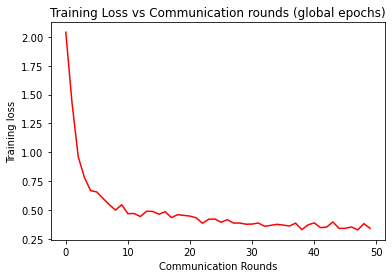

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the loss curve
plt.title('Training Loss vs Communication rounds (global epochs)')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
plt.show()
plt.savefig('save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
            format(args.dataset, args.model, args.global_epochs, args.frac,
                   args.iid, args.local_ep, args.local_bs))

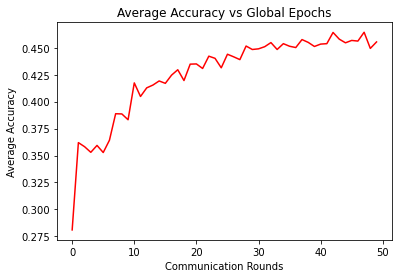

In [10]:
# Plot Average Accuracy vs Global Epochs
plt.figure()
plt.title('Average Accuracy vs Global Epochs')
plt.plot(range(len(train_accuracy)), train_accuracy, color='r')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
            format(args.dataset, args.model, args.global_epochs, args.frac,
                   args.iid, args.local_ep, args.local_bs))